In [0]:
import os
os.kill(os.getpid(), 9)

In [1]:
#Download all libraries here
import pandas as pd
import pandas_datareader as pdr
import re
import numpy as np
import os, json
import glob
!pip install colab-gitlab

#import TA
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install
!pip install Ta-Lib

#install Quandl for stock prices
!pip install Quandl
!pip install hyperas
!pip install talos

import quandl
import talib as ta

!pip install googletrans
!pip install vaderSentiment

import seaborn as sns
from googletrans import Translator
translator = Translator()
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import unicodedata


import matplotlib.pyplot as plt
import datetime 
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
#import cufflinks
#cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)

     |████████████████████████████████| 573kB 9.1MB/s 
     |████████████████████████████████| 7.4MB 30.9MB/s 
     |████████████████████████████████| 1.6MB 34.1MB/s 
     |████████████████████████████████| 471kB 48.2MB/s 
     |████████████████████████████████| 419kB 45.7MB/s 
     |████████████████████████████████| 266kB 48.1MB/s 
     |████████████████████████████████| 51kB 21.5MB/s 
     |████████████████████████████████| 317kB 41.4MB/s 
     |████████████████████████████████| 92kB 30.6MB/s 
     |████████████████████████████████| 184kB 45.0MB/s 
     |████████████████████████████████| 71kB 27.8MB/s 
     |████████████████████████████████| 51kB 22.2MB/s 
  Created wheel for colab-gitlab: filename=colab_gitlab-0.2.6-cp36-none-any.whl size=25648 sha256=13187cd18745539784db627f5ce9adfd81daa00dca8f9edaedf57e6f862cc69c
  Stored in directory: /root/.cache/pip/wheels/ba/de/92/f0d5dff3fb94945337af7e8a26efd80eec628f18a2d88aa755
  Created wheel for colab: filename=colab-1.13.5-cp36-none-any.

  Created wheel for googletrans: filename=googletrans-2.4.0-cp36-none-any.whl size=15776 sha256=278c0777e2e25a53f026d7e1aa844c10bae7dcda2ddc04be4965954d07449d45
  Stored in directory: /root/.cache/pip/wheels/50/d6/e7/a8efd5f2427d5eb258070048718fa56ee5ac57fd6f53505f95
Successfully built googletrans
     |████████████████████████████████| 133kB 6.6MB/s 


# Get prices and SMA5

In [2]:
import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#Don't forget to switch VADER lexicon to financial specific lexicon provided 'vader_lexicon.txt'

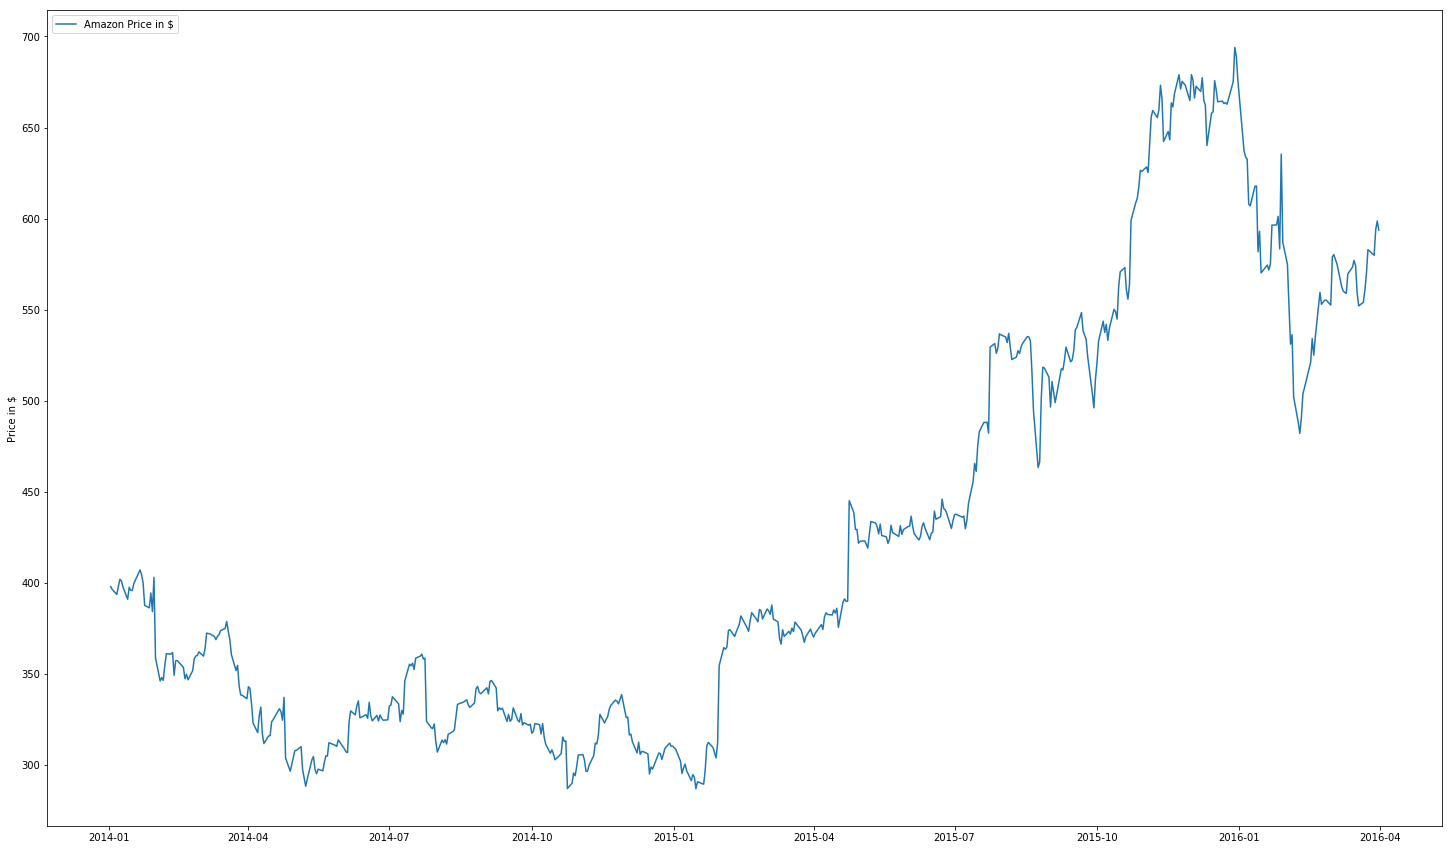

528


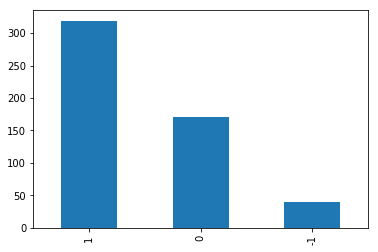

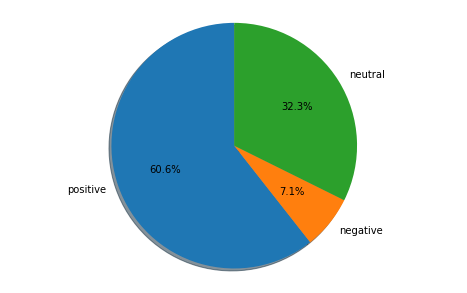

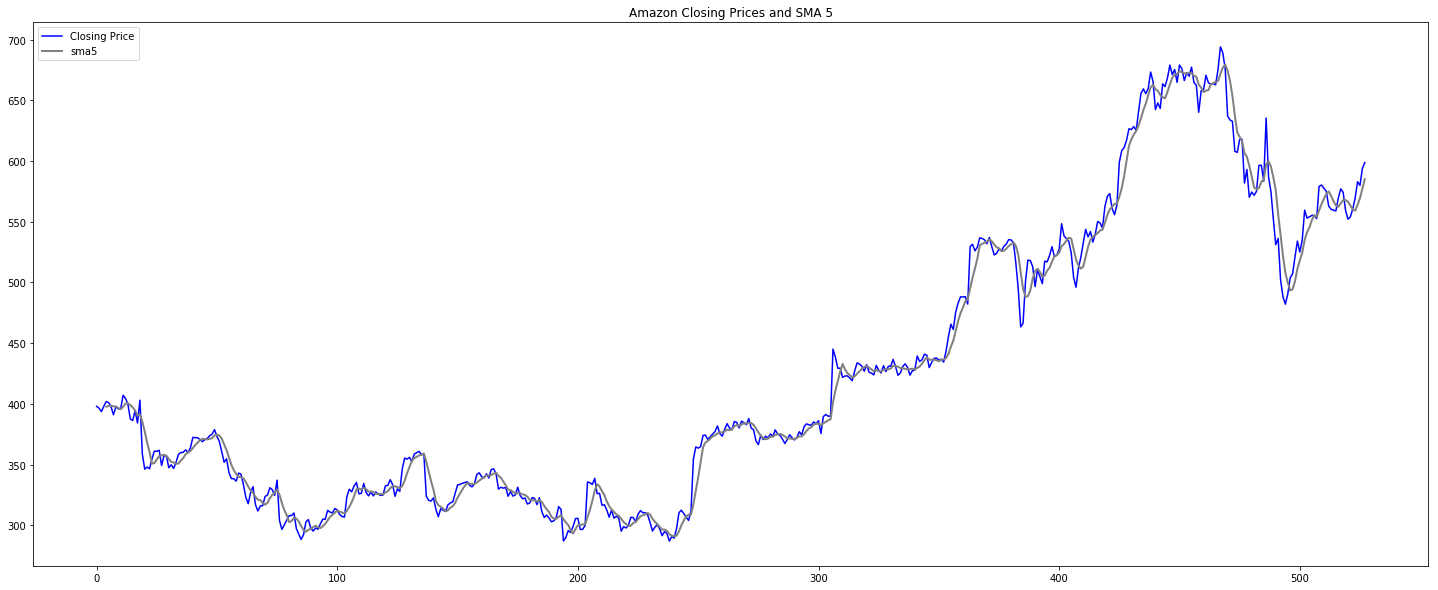

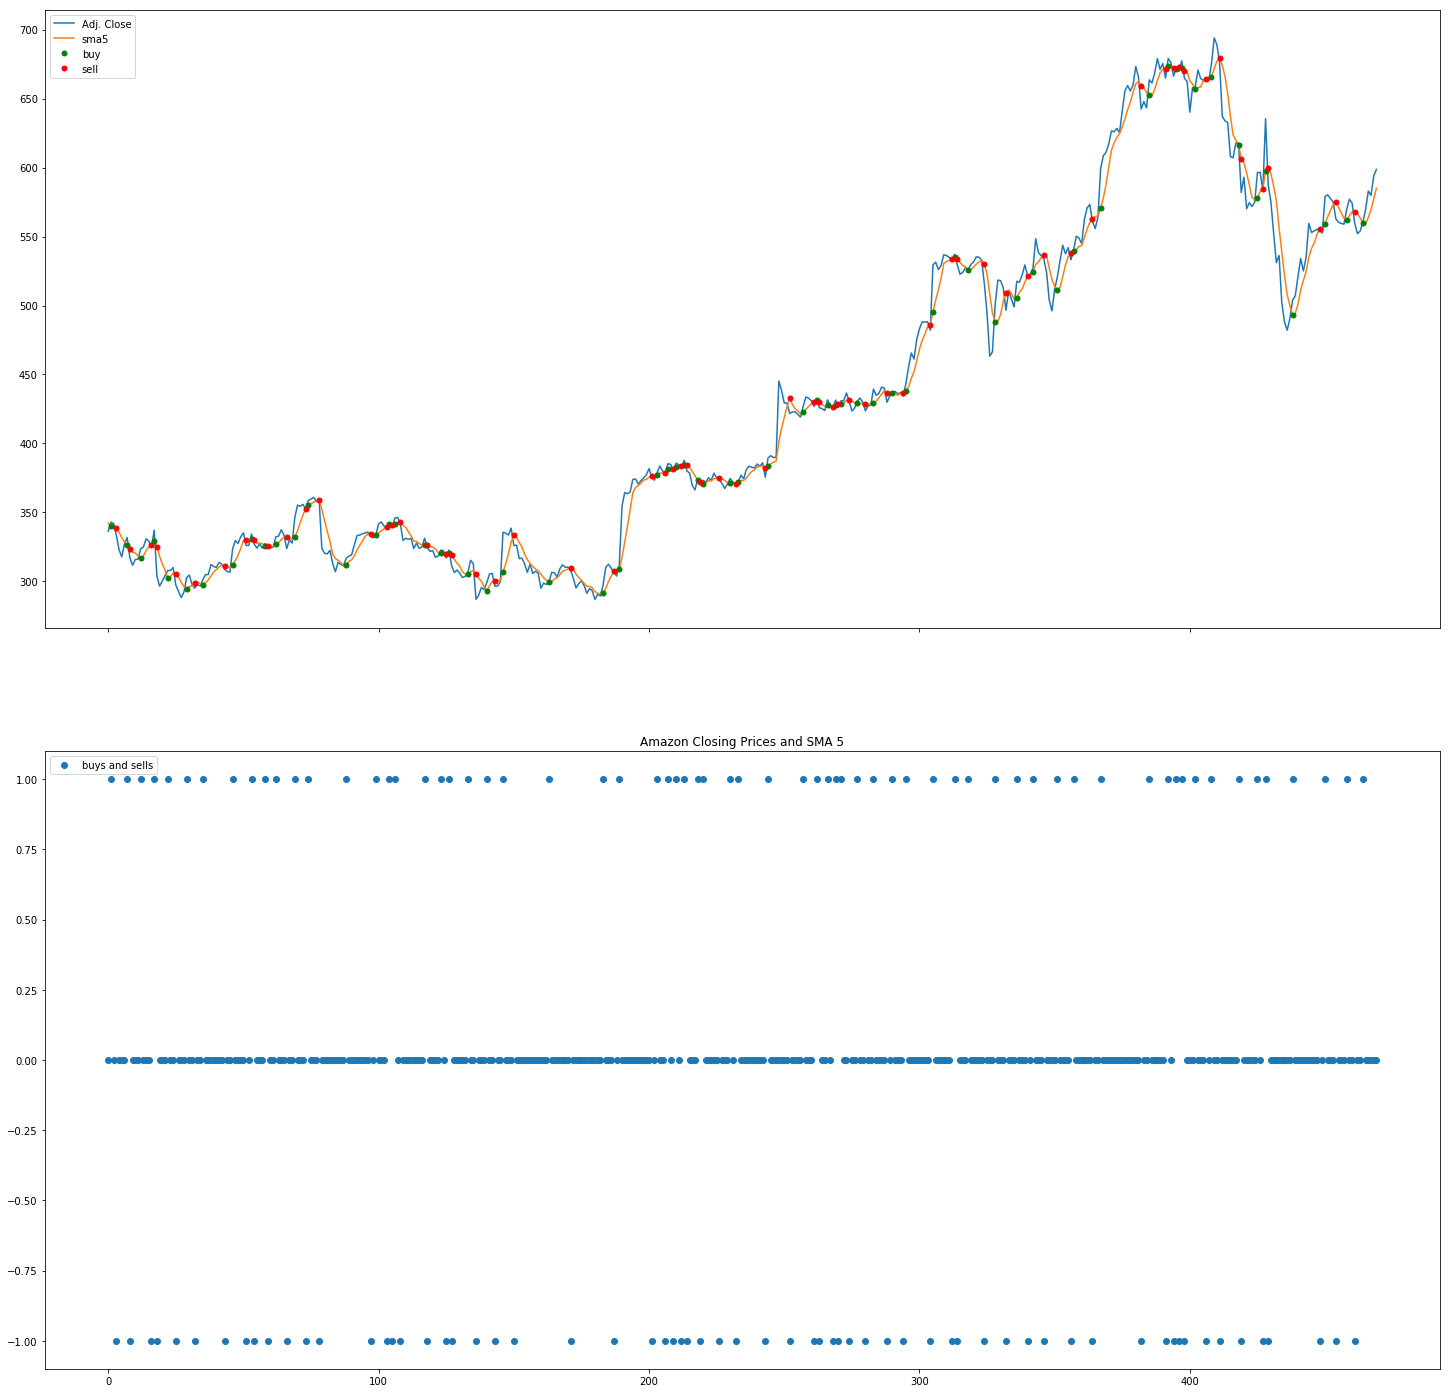

In [3]:
tweets = pd.DataFrame()
ticker = "amzn" #input("Enter ticker: ") this can be changed to any ticker matching the stocks in Data folder
ticker_name = "Amazon"
path_to_json = '/content/drive/My Drive/MScProject2019KamBansalColab/Data/stocknet-dataset/tweet/raw/AMZN' # change this url to where Data is 
json_pattern = os.path.join(path_to_json,'*.json')
file_list = glob.glob(json_pattern)

for file in file_list:
    data = pd.read_json(file, lines=True)
    tweets = tweets.append(data, ignore_index = True)
    
#randomise dataset
tweets = tweets.sample(frac=1).reset_index(drop=True)

def set_pandas_options() -> None:
    pd.options.display.max_columns = 1000
    pd.options.display.max_rows = 1000
    pd.options.display.max_colwidth = 199
    pd.options.display.width = None
    # pd.options.display.precision = 2  # set as needed

set_pandas_options()
%matplotlib inline
tweets = tweets[['created_at', 'text']]

#clean up the text
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
    return input_txt


def clean_tweets(lst):
    # remove twitter Return handles (RT @xxx:)
    lst = np.vectorize(remove_pattern)(lst, "RT @[\w]*:")
    # remove twitter handles (@xxx)
    lst = np.vectorize(remove_pattern)(lst, "@[\w]*")
    # remove URL links (httpxxx)
    lst = np.vectorize(remove_pattern)(lst, "https?://[A-Za-z0-9./]*")
    # remove special characters, numbers, punctuations (except for #)
    lst = np.core.defchararray.replace(lst, "[^a-zA-Z#]", " ")

    return lst
  
tweets['text'] = clean_tweets(tweets['text'])

#change name of column 'created_at' to date
tweets.columns=['date', 'tweets']

#remove the time and just leave the dates a yy/mm/dd
tweets['date'] = tweets['date'].apply(lambda x:x.date())

#date has now become an object - turn it back into Timeindex
tweets['date'] = pd.to_datetime(tweets['date'])

tweets['date'].min(), tweets['date'].max()

#sort date ascending
tweets = tweets.sort_values(['date'], ascending=[True])

#create a new datafram 
ticker_df = pd.DataFrame(columns=['Date', 'Tweets'])

#put all tweets from same day together

indx=0
get_tweet=""
for i in range(0,len(tweets)-1):
    get_date = tweets.date.iloc[i]
    next_date = tweets.date.iloc[i+1]
    if(str(get_date)==str(next_date)):
        get_tweet=get_tweet+tweets.tweets.iloc[i]+" "
    if(str(get_date)!=str(next_date)):
        ticker_df.set_value(indx,'Date',get_date)
        ticker_df.set_value(indx,'Tweets',get_tweet)
        indx=indx+1
        get_tweet=" "
        
ticker_df['Date'] = ticker_df['Date'].apply(lambda x:x.date())


#Get the data
quandl.ApiConfig.api_key = 'oesxGz8sxby-pkzbaDyM'

df = quandl.get("WIKI/{}".format(ticker), collapse="hourly", 
                qopts = { 'columns': ['date','open', 'high', 'low', 
                                              'close','Adj_close'] }, start_date="2014-01-01", 
                end_date="2016-03-31", 
                paginate=True)

#plot chart
fig1, ax = plt.subplots(1, sharex=True, figsize=(25,15))
ax.plot(df['Adj. Close'], label = '{} Price in $'.format(ticker_name))
ax.set_ylabel('Price in $')
plt.legend(loc='upper left')
plt.show()

#get teh columns we want
df = df[['Adj. Open', 'Adj. High', 'Adj. Low', 'Adj. Close', 'Adj. Volume']]

##make a dataframe where dateTime is not index
df = df.reset_index()

#make Date back to DateTimeIndex for ticker_df dataframe
#date has now become an object - turn it back into Timeindex
ticker_df['Date'] = pd.to_datetime(ticker_df['Date'])

#add prices to dataframe
#indx=0
for i in range (0,len(ticker_df)):
    for j in range (0,len(df)):
        get_tweet_date = ticker_df.Date.iloc[i]
        get_stock_date = df.Date.iloc[j]
        if(str(get_stock_date) == str(get_tweet_date)):
            #print(get_stock_date," ",get_tweet_date)
            ticker_df.set_value(i,'Adj. Open',(df['Adj. Open'][j]))
            ticker_df.set_value(i,'Adj. High',(df['Adj. High'][j]))
            ticker_df.set_value(i,'Adj. Low',(df['Adj. Low'][j]))
            ticker_df.set_value(i,'Adj. Close',(df['Adj. Close'][j]))
            ticker_df.set_value(i,'Adj. Volume',(df['Adj. Volume'][j]))
            break
            
ticker_df = ticker_df.dropna(how='any')

#add sentiment analysis

analyser = SentimentIntensityAnalyzer()
new_words = {'bullish': 5.0, 'long': 4.0, 'merger': 4.0, 'bearish': -5.0, 'short': -4.0, 
             'downgraded':-5.0, 'downgrade':-5.0, 'upgrade':5.0, 'lower': -3.0, 'higher': 3.0, 
             'upgraded':5.0, 'broke': -2.0, 'solid': 3.0,
             'screwed': -4.0, 'sell': -5.0, 'buy': 4.0, 'oversold': 3.0, 'overbought': -3.0}
analyser.lexicon.update(new_words)

#apply vader sentiment 
for index, row in ticker_df.T.iteritems():
    try:
        sentence_i = unicodedata.normalize('NFKD', ticker_df.loc[index, 'Tweets'])
        sentence_sentiment = analyser.polarity_scores(sentence_i)
        
        #sentence_sentiment = sentiment_analyzer_scores(sentence_i, engl=True)
        
        ticker_df.set_value(index, 'Comp', sentence_sentiment['compound'])
        ticker_df.set_value(index, 'Negative', sentence_sentiment['neg'])
        ticker_df.set_value(index, 'Neutral', sentence_sentiment['neu'])
        ticker_df.set_value(index, 'Positive', sentence_sentiment['pos'])
    except TypeError:
        #print (stocks_dataf.loc[index, 'text'])
        print (index)
        
#add a sentiment column
ticker_df['sentiment'] = ""
print(len(ticker_df))

#sentiment code 
def senti(x):
    #score = tweets['Comp']
    if x >= 0.65:
        return 1
    elif (x >= -0.65) and (x < 0.65):
        return 0
    else:
        return -1
      
#apply code to get sentiment 
ticker_df['sentiment'] = ticker_df['Comp'].apply(senti)

#reset index to consecutive numbering
ticker_df = ticker_df.reset_index(drop=True)


# how long are our tweets
#ticker_df['Tweets'].str.len().plot.hist()
ticker_df['sentiment'].value_counts().plot.bar()

#too many positives! Makes sense as price increases

#Draw sentiment the number of positive / neutral / negative

positive = 0
negative = 0
neutral = 0

for i in range (0,len(ticker_df)):
    
    get_val = ticker_df.sentiment[i]
    
    if(get_val) == -1:
        negative = negative+1
        
    if(get_val) == 1:
        positive =positive+1
    
    if(get_val) == 0:
        neutral = neutral+1

posper=(positive/(len(ticker_df)))*100
negper=(negative/(len(ticker_df)))*100
neutper=(neutral/(len(ticker_df)))*100

#plot chart

labels=['positive','negative', 'neutral']

fig, ax = plt.subplots(1, figsize=(8, 5))
arr=np.asarray([posper,negper, neutper], dtype=int)
ax.pie(arr,labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax.axis('equal')
#plt.plot()
plt.show()

sma_df = ticker_df.copy()
sma_df.head()

#Add moving averages SMA
sma_df['sma5'] = ta.SMA(np.asarray(sma_df['Adj. Close']), 5)

# set date as index now that we have merged all the data
#sma_df = sma_df.set_index('Date')

#PLot chart
fig1, ax = plt.subplots(figsize=(25, 10))


ax.plot(sma_df['Adj. Close'], color='blue', label='Closing Price')

#5 day Moving Average
ax.plot(sma_df['sma5'], lw=2., color='grey', label='sma5')

#20 day Moving Average
#ax.plot(sma_df['sma20'], lw=2., color='black', label='sma20')

plt.title('{} Closing Prices and SMA 5'.format(ticker_name))
plt.legend(loc='upper left')
plt.show()

sma_df.set_index('Date', inplace=True)
sma_df = sma_df['2014-03-31' : '2016-03-31']
sma_df = sma_df.reset_index()

sma_df['Adj. Close(-1)'] = sma_df['Adj. Close'].shift(1)
sma_df['sma5(-1)'] = sma_df['sma5'].shift(1)

#Create training Signals with SMA5
#Initialise column
sma_df['sma5sig'] = 0

sma5sig = 0


# Generate Trading Signals (buy=1 , sell=-1, do nothing=0)

for i, row in enumerate(sma_df.iterrows()):
    if row[1]['Adj. Close(-1)'] < row[1]['sma5(-1)'] and row[1]['Adj. Close'] > row[1]['sma5']:
        sma5sig = 1
    elif row[1]['Adj. Close(-1)'] > row[1]['sma5(-1)'] and row[1]['Adj. Close'] < row[1]['sma5']:
        sma5sig = -1
    else:
        sma5sig = 0
    sma_df.iloc[i, 15] = sma5sig

# Trading Signals Chart
fig1, ax = plt.subplots(2, sharex=True, figsize=(25,25))
plt.title('{} Closing Prices and SMA 5'.format(ticker_name))
ax[0].plot(sma_df['Adj. Close'], label='Adj. Close')
ax[0].plot(sma_df['sma5'], label='sma5')

# Plot the buy signals
ax[0].plot(sma_df.loc[sma_df['sma5sig'] == 1.0].index, 
         sma_df.sma5[sma_df['sma5sig'] == 1.0],
         'o', markersize=5, color='g', label='buy')
         
# Plot the sell signals
ax[0].plot(sma_df.loc[sma_df['sma5sig'] == -1.0].index, 
         sma_df.sma5[sma_df['sma5sig'] == -1.0],
         'o', markersize=5, color='r', label='sell')

ax[0].legend(loc='upper left')

ax[1].plot(sma_df['sma5sig'], marker='o', linestyle='', label= 'buys and sells')
ax[1].legend(loc='best')

plt.legend(loc='upper left')
plt.show()

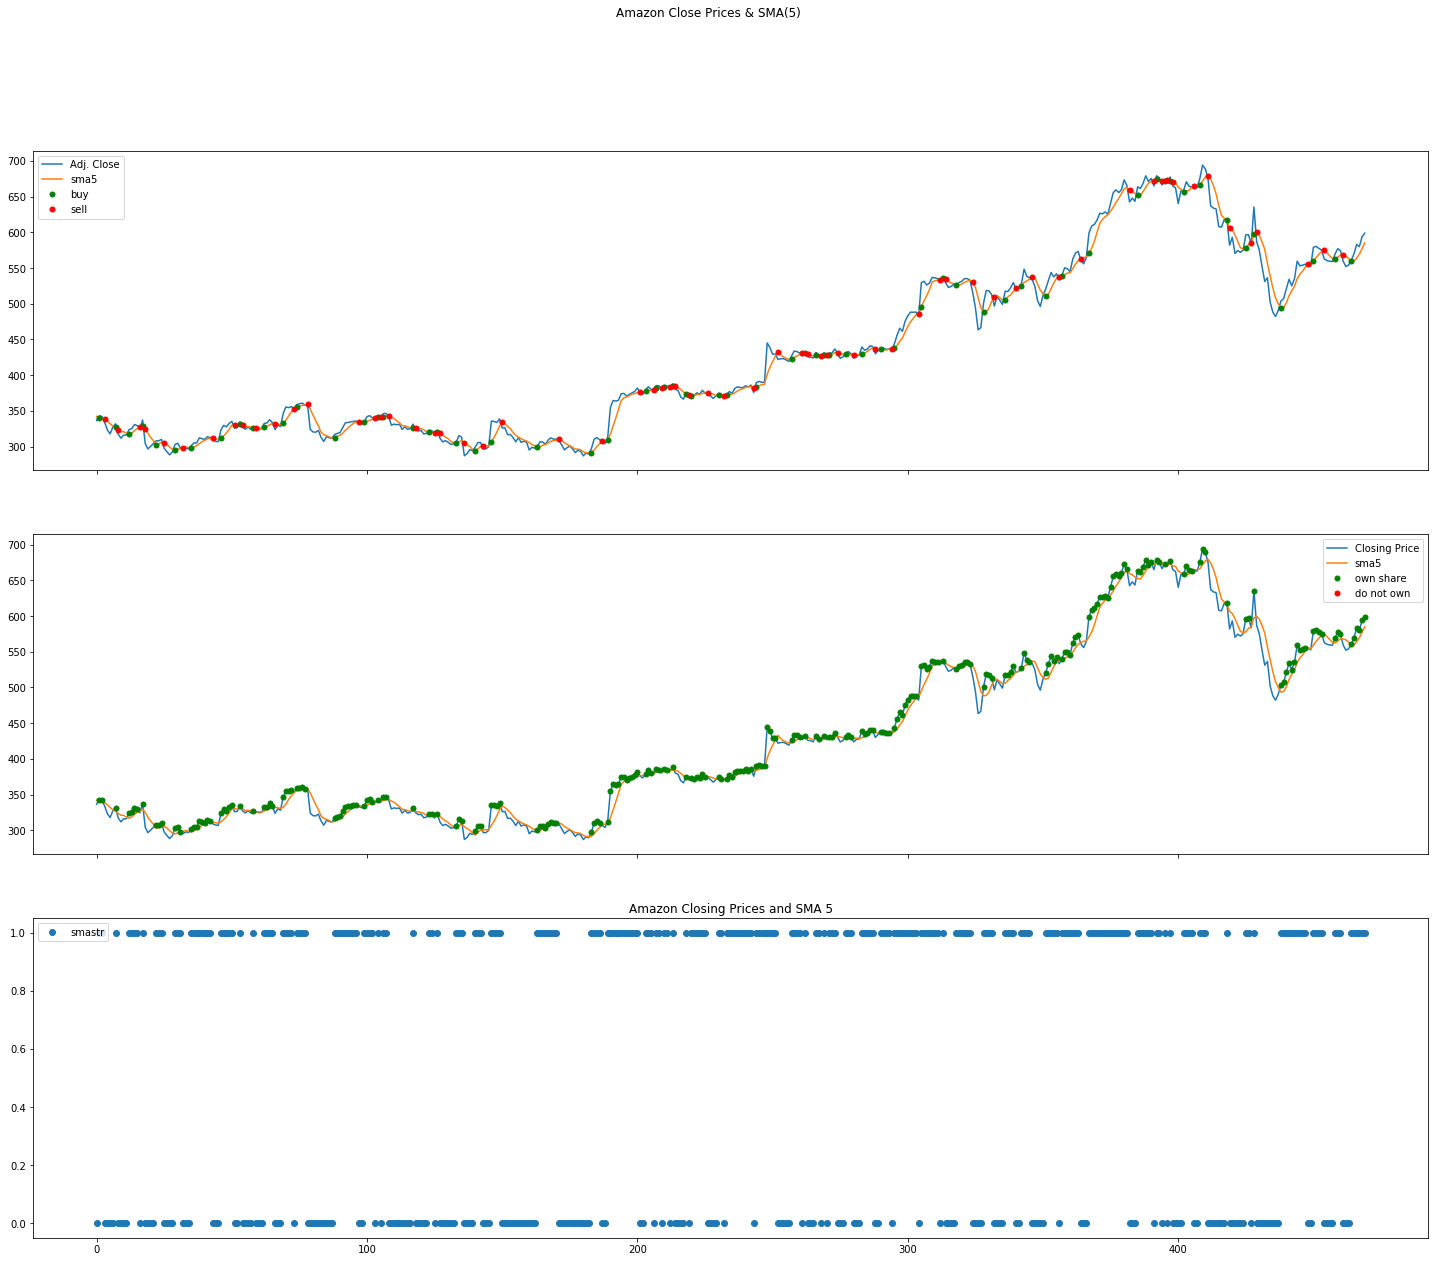

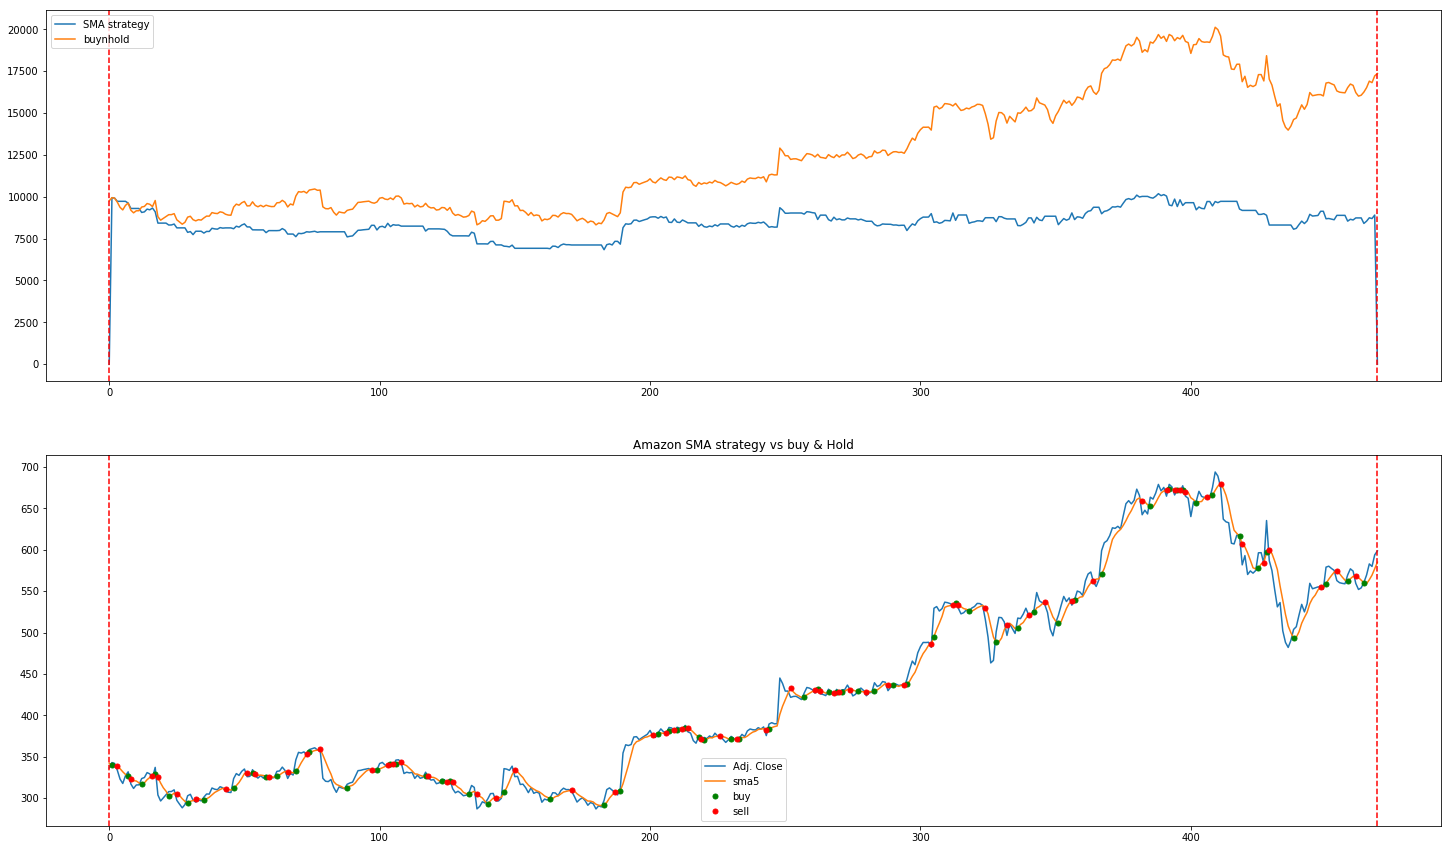

investing 10,000 pounds initially


0                 1              2             3              4  \
0                Inital Amount($)  Number Shares  Buy Price($)  Sell Price($)   
1  buy and hold            10,000             29        336.36         598.69   
2                                                                               
3          sma5            10,000            NaN        342.99         593.86   

                 5                  6          7                8  \
0  Price change($)  capital return($)  Profit($)  Total Return(%)   
1           262.33              17362    7362.01            73.62   
2                                                                   
3           250.87             8907.9    -1092.1           -10.92   

                      9  
0  Annualised Return(%)  
1                 27.47  
2                        
3                   NaN

In [4]:
#Now to create the trading strategy - price crossover trading strategy
# Generate Trading Strategy (own stock=1 , not own stock=0, short-selling not available)

sma_df['sma5str'] = 0 # initially own the stock

sma5str = 0 # initialise all as 0

for i, row in enumerate(sma_df.iterrows()):
  
    get_previous = sma_df['sma5str'].iloc[i-1]
    
    if row[1]['sma5sig'] == 1:
        sma5str = 1 #own the stock
   
    elif row[1]['sma5sig'] == -1:
        sma5str = 0 #don't own the stock
    else:
      sma5str = get_previous  # if dont have either of above, just  repeat previous period trading strategy
    
    sma_df.iloc[i, 16] = sma5str # continue to update 
    
#next we create strategy chart

fig, ax = plt.subplots(3, sharex=True, figsize=(25,20))

# Trading Signals Chart

plt.title('{} Closing Prices and SMA 5'.format(ticker_name))
ax[0].plot(sma_df['Adj. Close'], label='Adj. Close')
ax[0].plot(sma_df['sma5'], label='sma5')

# Plot the buy signals
ax[0].plot(sma_df.loc[sma_df['sma5sig'] == 1.0].index, 
         sma_df.sma5[sma_df['sma5sig'] == 1.0],
         'o', markersize=5, color='g', label='buy')
         
# Plot the sell signals
ax[0].plot(sma_df.loc[sma_df['sma5sig'] == -1.0].index, 
         sma_df.sma5[sma_df['sma5sig'] == -1.0],
         'o', markersize=5, color='r', label='sell')

ax[0].legend(loc='upper left')

ax[1].plot(sma_df['Adj. Close'], label='Closing Price')
ax[1].plot(sma_df['sma5'], label='sma5')
ax[1].legend(loc='upper left')

# Plot the buy signals
ax[1].plot(sma_df.loc[sma_df['sma5str'] == 1.0].index, 
         sma_df['Adj. Close'][sma_df['sma5str'] == 1.0],
         'o', markersize=5, color='g', label='own share')
         
# Plot the sell signals
ax[1].plot(sma_df.loc[sma_df['sma5str'] == -1.0].index, 
         sma_df['Adj. Close'][sma_df['sma5str'] == -1.0],
         'o', markersize=5, color='r', label='do not own')

ax[1].legend(loc='best')

ax[2].plot(sma_df['sma5str'], marker='o', linestyle='', label='smastr')
ax[2].legend(loc='upper left')
plt.suptitle('{} Close Prices & SMA(5)'.format(ticker_name))
plt.show()

#Next see how this compares to buy and hold strategy # Strategy Daily Returns
#Look at 
#1) Annualised Return - (number of observations root of annually scaled cumulative product of daily returns)
#2) Annualised s.d - risk metric (daily s.d. multiplied by square root fo number of periods per year) 
#3) Annualised Sharp ratio

#now to test against real money
investment = 10000
sma_df['capital']= investment
sma_df['invested'] = 0
sma_df['price'] = sma_df['Adj. Close']
sma_df['pnl'] = 0 # initially own the stock
sma_df['shares'] = int(investment / sma_df['Adj. Close'][0])
sma_df['buynhold'] = sma_df['shares'] * sma_df['Adj. Close']


sma_df['capital'] = sma_df['capital'].astype('float64') 
sma_df['invested'] = sma_df['invested'].astype('float64')
sma_df['pnl'] = sma_df['pnl'].astype('float64')
sma_df['shares'] = sma_df['shares'].astype('float64')
sma_df['buynhold'] = sma_df['buynhold'].astype('float64')

sma_df = sma_df.round(2)

for i in range(0,len(sma_df)-1):
  
  get_price = sma_df['Adj. Close'].iloc[i]

  inital = 0 
  buy_price=0
  difference_price=0
  sell_price=0
  next_date = sma_df.Date.iloc[i+1]
  capital_1 = sma_df['capital'].iloc[i-1]
  capital = sma_df['capital'].iloc[i]
  nominal = sma_df['pnl'].iloc[i]-1
  capital_invested = sma_df['Adj. Close'].iloc[i]
  invested_shares = int(sma_df['capital'].iloc[i-1] / get_price)
  #pnl = invested_shares * get_price

  get_pnl = sma_df['pnl'].iloc[i-1]
  sma5str = sma_df['sma5str'].iloc[i]
  sma5str_1 = sma_df['sma5str'].iloc[i-1]
  invested_1 = sma_df['invested'].iloc[i-1]
  invested = sma_df['invested'].iloc[i]
  pnl_1 = sma_df['pnl'].iloc[i-1]
  
  
  if(sma5str) == 0 and i==0:
    #print('i=0')
    sma_df.at[i,'capital'] = investment    
    sma_df.at[i,'invested'] = 0       
    sma_df.at[i,'pnl'] = 0     
  
  elif(sma5str) == 0 and sma5str_1 == 0 and capital_1 ==investment:
    sma_df.at[i,'invested'] = invested_1  
    sma_df.at[i,'capital'] = capital_1
    sma_df.at[i, 'pnl'] = 0
    
  elif(sma5str) == 0 and sma5str_1 == 0 and capital_1 !=investment:
    sma_df.at[i,'invested'] = invested_1  
    sma_df.at[i,'capital'] = capital_1
    sma_df.at[i, 'pnl'] = pnl_1
     
 
  elif(sma5str) == 1 and sma5str_1 == 0:
    sma_df.at[i,'invested'] = int(capital_1/ get_price)  
    sma_df.at[i,'capital'] = int(capital_1 - ((sma_df['invested'].iloc[i] *get_price)))
    sma_df.at[i, 'pnl'] = sma_df['invested'].iloc[i] * get_price
    price_buy = get_price
  
  elif(sma5str) == 0 and sma5str_1 == 1 and capital_1 !=investment:
    #print('i=0')
    differece_price = (get_price - price_buy) 
    sma_df.at[i,'capital'] = capital_1 + (invested_1 * get_price) + (difference_price * invested_1)    
    sma_df.at[i,'invested'] = 0       
    sma_df.at[i,'pnl'] = sma_df['capital'].iloc[i]      
  
  else:
    #sma_df.at[i,'capital'] = get_capital
    #sma_df.at[i,'invested'] = invested_1
    #sma_df.at[i,'pnl'] = get_pnl
    
    sma_df.at[i,'capital'] = capital_1    
    sma_df.at[i,'invested'] = invested_1       
    sma_df.at[i,'pnl'] = sma_df['invested'].iloc[i] * get_price

#now to test against real money
investment = 10000
sma_df['capital']= investment
sma_df['invested'] = 0
sma_df['price'] = sma_df['Adj. Close']
sma_df['pnl'] = 0 # initially own the stock
sma_df['shares'] = int(investment / sma_df['Adj. Close'][0])
sma_df['buynhold'] = sma_df['shares'] * sma_df['Adj. Close']


sma_df['capital'] = sma_df['capital'].astype('float64') 
sma_df['invested'] = sma_df['invested'].astype('float64')
sma_df['pnl'] = sma_df['pnl'].astype('float64')
sma_df['shares'] = sma_df['shares'].astype('float64')
sma_df['buynhold'] = sma_df['buynhold'].astype('float64')

sma_df = sma_df.round(2)


for i in range(0,len(sma_df)-1):
  
  get_price = sma_df['Adj. Close'].iloc[i]

  inital = 0 
  buy_price=0
  difference_price=0
  sell_price=0
  next_date = sma_df.Date.iloc[i+1]
  capital_1 = sma_df['capital'].iloc[i-1]
  capital = sma_df['capital'].iloc[i]
  nominal = sma_df['pnl'].iloc[i]-1
  capital_invested = sma_df['Adj. Close'].iloc[i]
  invested_shares = int(sma_df['capital'].iloc[i-1] / get_price)
  #pnl = invested_shares * get_price

  get_pnl = sma_df['pnl'].iloc[i-1]
  sma5str = sma_df['sma5str'].iloc[i]
  sma5str_1 = sma_df['sma5str'].iloc[i-1]
  invested_1 = sma_df['invested'].iloc[i-1]
  invested = sma_df['invested'].iloc[i]
  pnl_1 = sma_df['pnl'].iloc[i-1]
  
  
  if(sma5str) == 0 and i==0:
    #print('i=0')
    sma_df.at[i,'capital'] = investment    
    sma_df.at[i,'invested'] = 0       
    sma_df.at[i,'pnl'] = 0     
  
  elif(sma5str) == 0 and sma5str_1 == 0 and capital_1 ==investment:
    sma_df.at[i,'invested'] = invested_1  
    sma_df.at[i,'capital'] = capital_1
    sma_df.at[i, 'pnl'] = 0
    
  elif(sma5str) == 0 and sma5str_1 == 0 and capital_1 !=investment:
    sma_df.at[i,'invested'] = invested_1  
    sma_df.at[i,'capital'] = capital_1
    sma_df.at[i, 'pnl'] = pnl_1
     
 
  elif(sma5str) == 1 and sma5str_1 == 0:
    sma_df.at[i,'invested'] = int(capital_1/ get_price)  
    sma_df.at[i,'capital'] = int(capital_1 - ((sma_df['invested'].iloc[i] *get_price)))
    sma_df.at[i, 'pnl'] = sma_df['invested'].iloc[i] * get_price
    price_buy = get_price
  
     
    
  elif(sma5str) == 0 and sma5str_1 == 1 and capital_1 !=investment:
    #print('i=0')
    differece_price = (get_price - price_buy) 
    sma_df.at[i,'capital'] = capital_1 + (invested_1 * get_price) + (difference_price * invested_1)    
    sma_df.at[i,'invested'] = 0       
    sma_df.at[i,'pnl'] = sma_df['capital'].iloc[i]      
  
  else:
    #sma_df.at[i,'capital'] = get_capital
    #sma_df.at[i,'invested'] = invested_1
    #sma_df.at[i,'pnl'] = get_pnl
    
    sma_df.at[i,'capital'] = capital_1    
    sma_df.at[i,'invested'] = invested_1       
    sma_df.at[i,'pnl'] = sma_df['invested'].iloc[i] * get_price

sma5_df = sma_df.copy()
sma_df = sma_df[['Date', 'Adj. Close', 'Comp', 'sma5', 'sma5sig', 'sma5str', 'capital', 'invested', 'pnl', 'shares', 'buynhold']]
endYr2 = sma_df.index[-1]

#slide dataframe for 2 years

# pnl Returns Chart
fig, ax = plt.subplots(2, figsize=(25, 15))

ax[0].plot(sma_df['pnl'], label = 'SMA strategy' )
ax[0].plot(sma_df['buynhold'], label = 'buynhold')

ax[0].axvline(0, color='r', ls='--')
#ax[0].axvline(endYr1.index[0], color='r', ls='--')
ax[0].axvline(sma_df.index[-1], color='r', ls='--')

ax[0].legend(loc='upper left')

# Plot the buy signals
ax[1].plot(sma_df['Adj. Close'], label='Adj. Close')
ax[1].plot(sma_df['sma5'], label='sma5')

ax[1].plot(sma_df.loc[sma_df['sma5sig'] == 1.0].index, 
         sma_df.sma5[sma_df['sma5sig'] == 1.0],
         'o', markersize=5, color='g', label='buy')
         
# Plot the sell signals
ax[1].plot(sma_df.loc[sma_df['sma5sig'] == -1.0].index, 
         sma_df.sma5[sma_df['sma5sig'] == -1.0],
         'o', markersize=5, color='r', label='sell')

ax[1].axvline(0, color='r', ls='--')
#ax[1].axvline(endYr1.index[0], color='r', ls='--')
ax[1].axvline(sma_df.index[-1], color='r', ls='--')

ax[1].legend(loc='upper left')

plt.title('{} SMA strategy vs buy & Hold'.format(ticker_name))
plt.legend()
plt.show()

sma5BuyIndexyr1=1
sma5SellIndexyr2=468

bhBuyIndexyr1=0
bhSellIndexyr2=sma_df.index[-1]

sma5BuyPrice_yr1 = sma_df['Adj. Close'].iloc[sma5BuyIndexyr1]
sma5SellPrice_yr2 = sma_df['Adj. Close'].iloc[sma5SellIndexyr2]

bhBuyPrice_yr1 = sma_df['Adj. Close'].iloc[bhBuyIndexyr1]
bhSellPrice_yr2 = sma_df['Adj. Close'].iloc[bhSellIndexyr2]

#buy and hold profit 
initial  = 10000

bhshares_invested = int(initial / bhBuyPrice_yr1)
bhPrice_change_yr2 = bhSellPrice_yr2 - bhBuyPrice_yr1
bhcapitalReturnyr2= (sma_df['buynhold'][bhSellIndexyr2]).round(2) 
bhProfit_yr2 = bhcapitalReturnyr2 - initial
bhReturn_yr2 = ((bhProfit_yr2/initial)*100).round(2)

def annualised():
  if ((len(sma_df) > 365)):
    bhannualised_return = ((1 + bhReturn_yr2)**(365/len(sma_df))-1).round(2)
  else:
    bhannualised_return = 0
    
  return bhannualised_return
    
sma5shares_invested = int(initial / sma5BuyPrice_yr1)
sma5capital_return_yr2 = (sma_df['pnl'].loc[sma5SellIndexyr2]).round(2)
sma5Profit_yr2 = sma5capital_return_yr2 - initial
sma5Return_yr2 = ((sma5Profit_yr2/initial)*100).round(2)
sma5Price_change_yr2 = (sma5SellPrice_yr2 - sma5BuyPrice_yr1)

def annualisedSma():
  if ((len(sma_df) > 365)):
    sma_df_return = ((1 + sma5Return_yr2)**(365/len(sma_df))-1).round(2)
  else:
    sma_df_return = 0
    
  return sma_df_return
    
print('investing 10,000 pounds initially')

# Summary Results Data Table
sma5data = [{'0': '', '1': 'Inital Amount($)', '2': 'Number Shares', '3': 'Buy Price($)', '4': 'Sell Price($)', '5': 'Price change($)', '6': 'capital return($)', '7': 'Profit($)', '8': 'Total Return(%)', '9': 'Annualised Return(%)'},
        {'0': 'buy and hold', '1': '10,000', '2': bhshares_invested, '3': bhBuyPrice_yr1, '4': bhSellPrice_yr2, '5': bhPrice_change_yr2,  '6': bhcapitalReturnyr2, '7': bhProfit_yr2, '8': bhReturn_yr2, '9': annualised()},  
         
        {'0': '', '1':'' , '2': '', '3': '', '4': '', '5': '', '6': '', '7': '', '8': '', '9': ''},
        
        {'0': 'sma5', '1': '10,000', '2': 'NaN', '3': sma5BuyPrice_yr1, '4': sma5SellPrice_yr2, '5': sma5Price_change_yr2,  '6': sma5capital_return_yr2, '7': sma5Profit_yr2, '8': sma5Return_yr2, '9': annualisedSma()}]
    
table = pd.DataFrame(sma5data)

table


In [0]:
***************** end ****************************

# Technical Analysis - EMA5

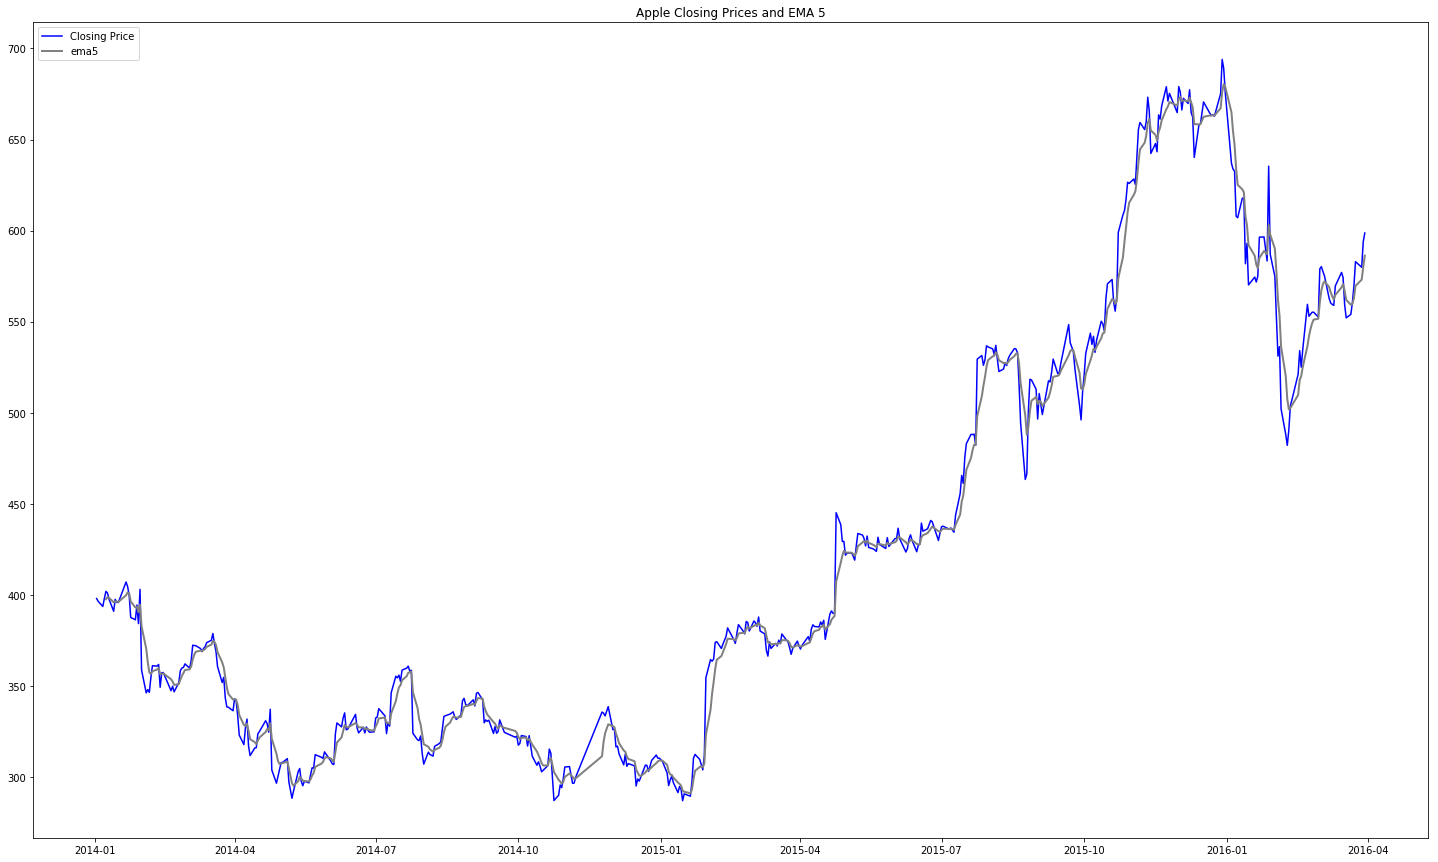

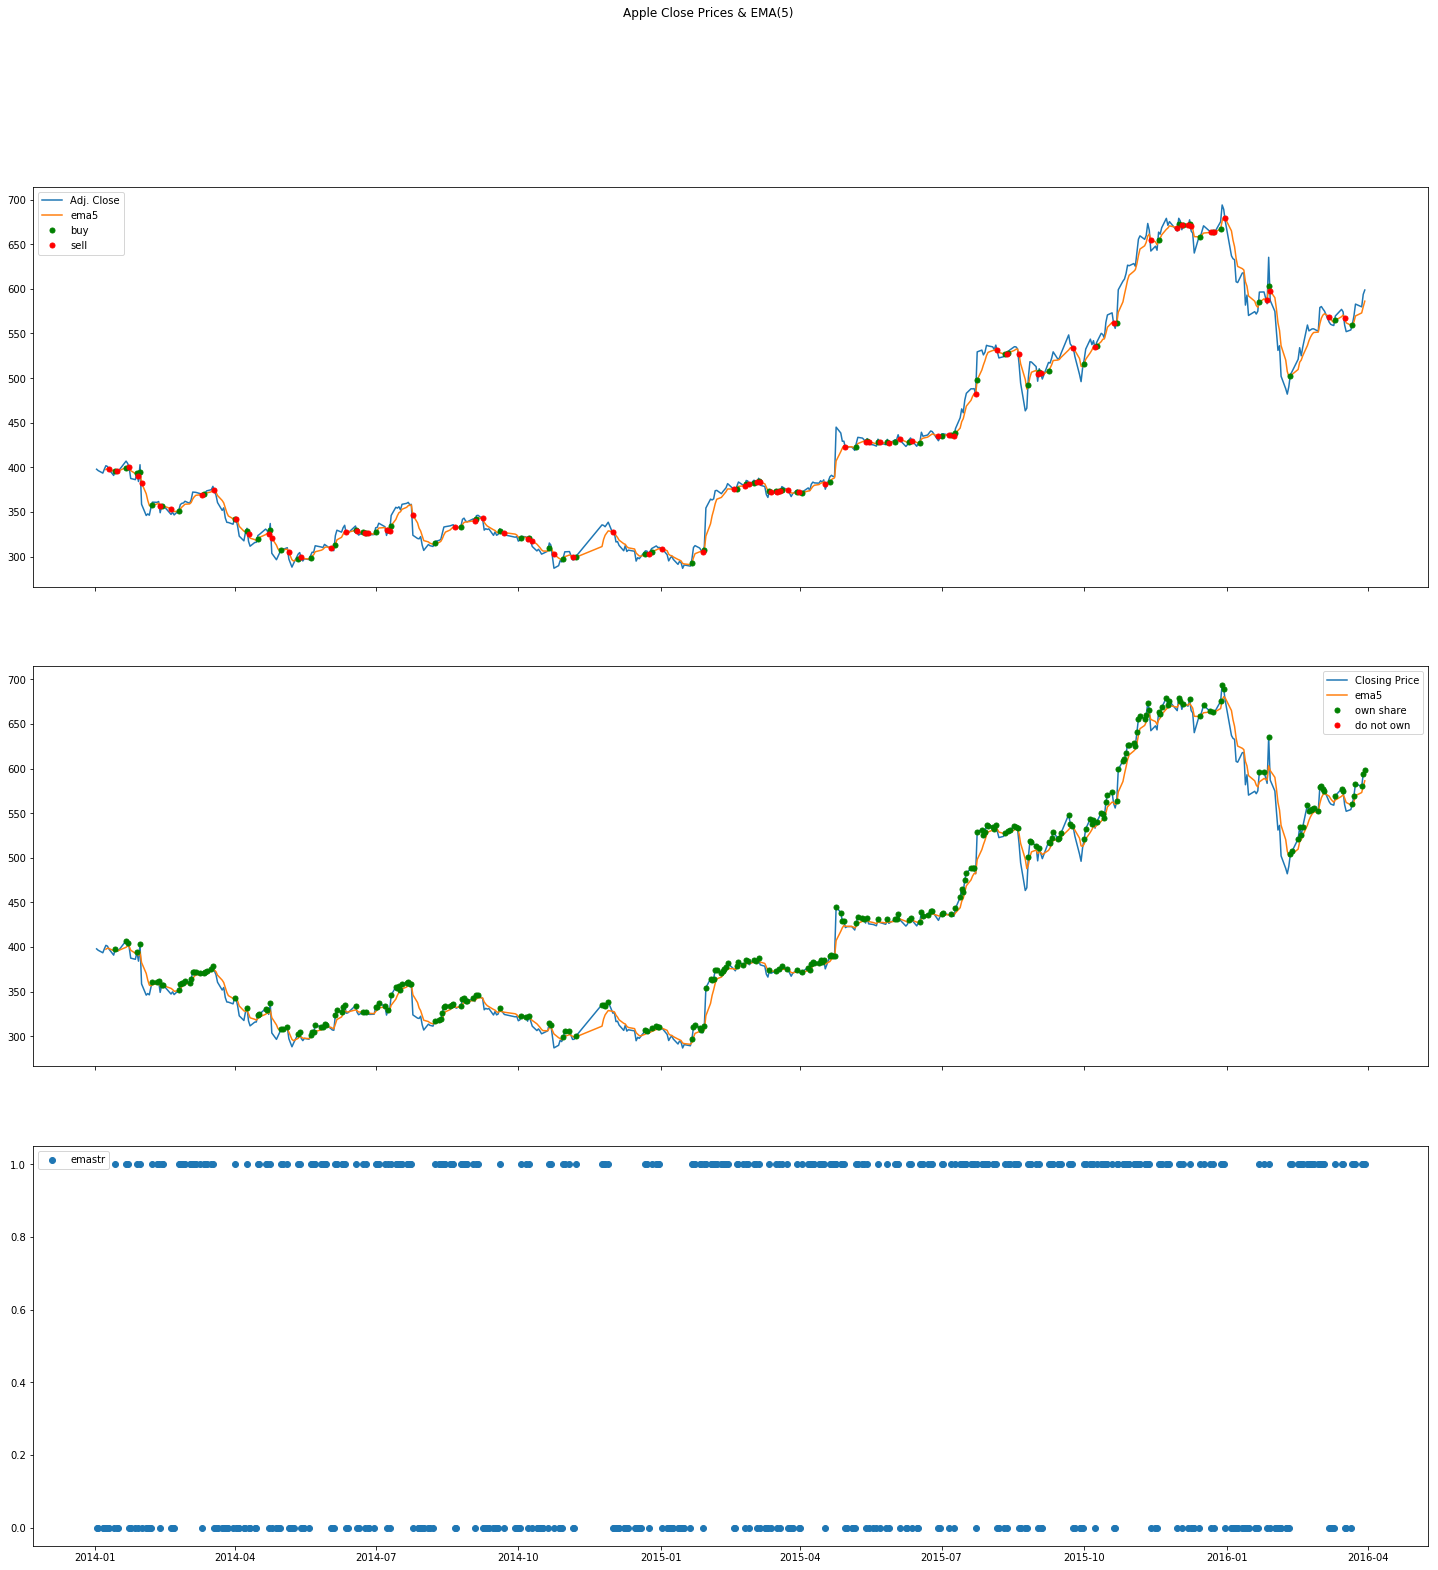

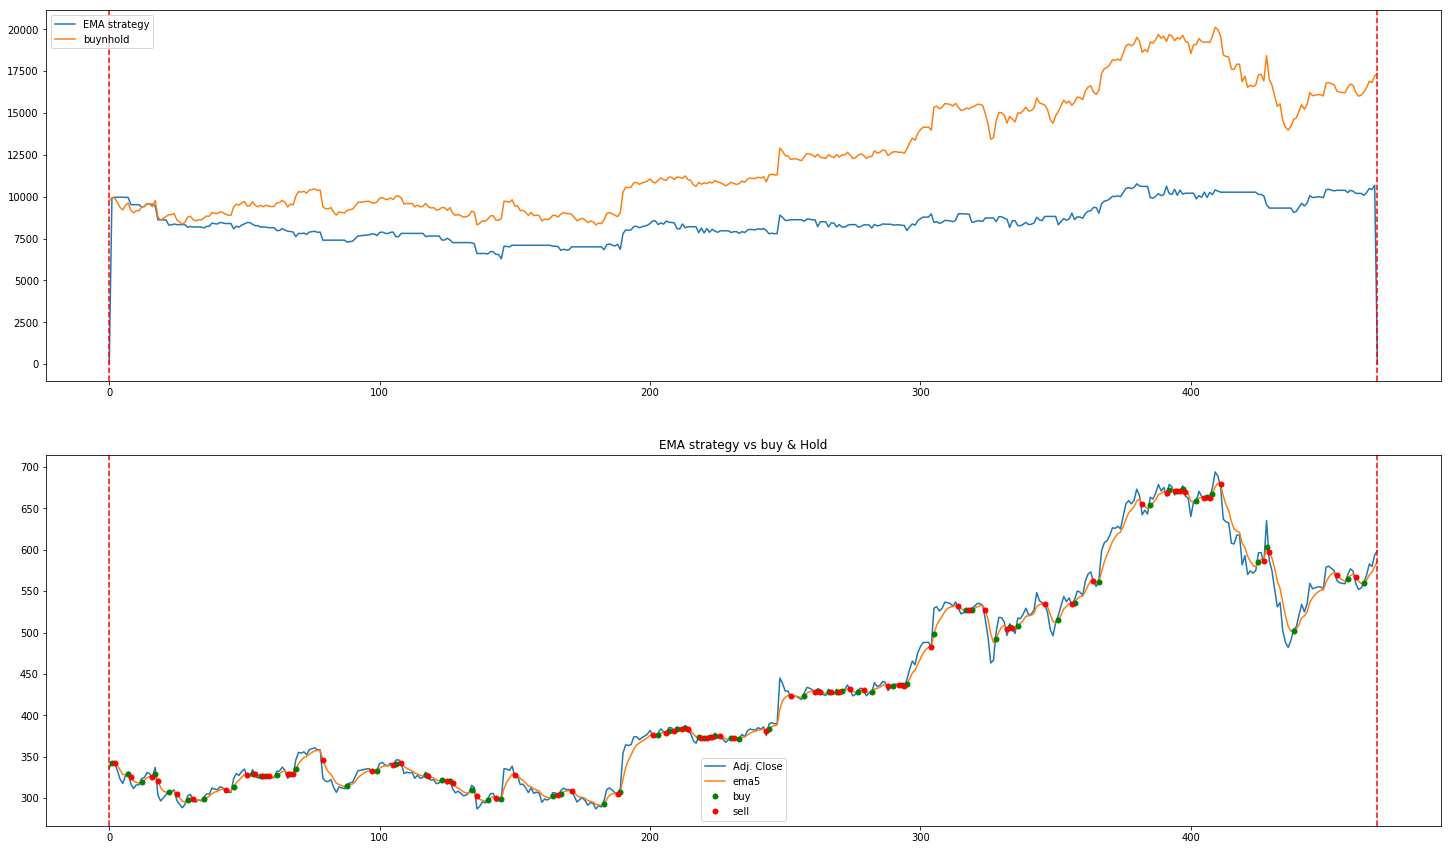

investing 10,000 pounds initially


0                 1              2             3              4  \
0                Inital Amount($)  Number Shares  Buy Price($)  Sell Price($)   
1  buy and hold            10,000             29        336.36         598.69   
2                                                                               
3          sma5            10,000            NaN        342.99         593.86   
4                                                                               
5          ema5            10,000            NaN        342.99         593.86   

                 5                  6          7                8  \
0  Price change($)  capital return($)  Profit($)  Total Return(%)   
1           262.33              17362    7362.01            73.62   
2                                                                   
3           250.87             8907.9    -1092.1           -10.92   
4                                                                   
5           250.87            10689.5     689.48             6.89   

                      9  
0  Annualised Return(%)  
1                 27.47  
2                        
3                   NaN  
4                        
5                  3.97

In [6]:
ema_df = ticker_df.copy()

# set date as index now that we have merged all the data
ema_df = ema_df.set_index('Date')

#Add moving averages SMA
ema_df['ema5'] = ta.EMA(np.asarray(ema_df['Adj. Close']), 5)
#ema_df['ema20'] = ta.SMA(np.asarray(ema_df['Adj. Close']), 20)
#aapletweet['sma100'] = ta.SMA(np.asarray(aapletweet['Adj. Close']), 100)


#PLot chart
fig1, ax = plt.subplots(figsize=(25, 15))


ax.plot(ema_df['Adj. Close'], color='blue', label='Closing Price')

#5 day Moving Average
ax.plot(ema_df['ema5'], lw=2., color='grey', label='ema5')

#20 day Moving Average
#ax.plot(ema_df['ema20'], lw=2., color='black', label='ema20')

plt.title('Apple Closing Prices and EMA 5')
plt.legend(loc='upper left')
plt.show()

#Create training Signals with SMA5
#Initialise column
ema_df['ema5sig'] = 0

#test this against one day lag
ema5sig = 0
ema_df['Adj. Close(-1)'] = ema_df['Adj. Close'].shift(1)
ema_df['ema5(-1)'] = ema_df['ema5'].shift(1)
#%%

# Generate Trading Signals (buy=1 , sell=-1, do nothing=0)
for i, r in enumerate(ema_df.iterrows()):
    if r[1]['Adj. Close(-1)'] < r[1]['ema5(-1)'] and r[1]['Adj. Close'] > r[1]['ema5']:
       ema5sig = 1
    elif r[1]['Adj. Close(-1)'] > r[1]['ema5(-1)'] and r[1]['Adj. Close'] < r[1]['ema5']:
        ema5sig = -1
    else:
        ema5sig = 0
    
    ema_df.iloc[i, 12] = ema5sig

ema_df['ema5str'] = 0 # initially own the stock

ema5str = 0 # initialise all as 0

for i, r in enumerate(ema_df.iterrows()):
    if r[1]['ema5sig'] == 1:
        ema5str = 1 #own the stock
    elif r[1]['ema5sig'] == -1:
        ema5str = 0 #don't own the stock
    else:
        ema5str = ema_df['ema5str'][i-1] # if dont have either of above, just  repeat previous period trading strategy
    ema_df.iloc[i, 15] = ema5str # continue to update 
    
#next we create strategy chart

fig2, ax = plt.subplots(3, sharex=True, figsize=(25,25))

ax[0].plot(ema_df['Adj. Close'], label='Adj. Close')
ax[0].plot(ema_df['ema5'], label='ema5')

# Plot the buy signals
ax[0].plot(ema_df.loc[ema_df['ema5sig'] == 1.0].index, 
         ema_df.ema5[ema_df['ema5sig'] == 1.0],
         'o', markersize=5, color='g', label='buy')
         
# Plot the sell signals
ax[0].plot(ema_df.loc[ema_df['ema5sig'] == -1.0].index, 
         ema_df.ema5[ema_df['ema5sig'] == -1.0],
         'o', markersize=5, color='r', label='sell')

ax[0].legend(loc='upper left')

ax[1].plot(ema_df['Adj. Close'], label='Closing Price')
ax[1].plot(ema_df['ema5'], label='ema5')
ax[1].legend(loc='upper left')

# Plot the buy signals
ax[1].plot(ema_df.loc[ema_df['ema5str'] == 1.0].index, 
         ema_df['Adj. Close'][ema_df['ema5str'] == 1.0],
         'o', markersize=5, color='g', label='own share')
         
# Plot the sell signals
ax[1].plot(ema_df.loc[ema_df['ema5str'] == -1.0].index, 
         ema_df['Adj. Close'][ema_df['ema5str'] == -1.0],
         'o', markersize=5, color='r', label='do not own')

ax[1].legend(loc='best')

ax[2].plot(ema_df['ema5str'], marker='o', linestyle='', label='emastr')
ax[2].legend(loc='upper left')
plt.suptitle('Apple Close Prices & EMA(5)')
plt.show()


#ema_df.set_index('Date', inplace=True)
ema_df = ema_df['2014-03-31' : '2016-03-31']
ema_df = ema_df.reset_index()

#ema_df = ema_df.reset_index()

# Teesting against invested funds
investment = 10000
ema_df['capital']= investment
ema_df['invested'] = 0
ema_df['price'] = ema_df['Adj. Close']
ema_df['pnl'] = 0 # initially own the stock
ema_df['shares'] = int(investment / ema_df['Adj. Close'][0])
ema_df['buynhold'] = ema_df['shares'] * ema_df['Adj. Close']


ema_df['capital'] = ema_df['capital'].astype('float64') 
ema_df['invested'] = ema_df['invested'].astype('float64')
ema_df['pnl'] = ema_df['pnl'].astype('float64')
ema_df['shares'] = ema_df['shares'].astype('float64')
ema_df['buynhold'] = ema_df['buynhold'].astype('float64')

ema_df = ema_df.round(2)


for i in range(0,len(ema_df)-1):
  
  get_price = ema_df['Adj. Close'].iloc[i]

  inital = 0 
  buy_price=0
  difference_price=0
  sell_price=0
  next_date = ema_df.Date.iloc[i+1]
  capital_1 = ema_df['capital'].iloc[i-1]
  capital = ema_df['capital'].iloc[i]
  nominal = ema_df['pnl'].iloc[i]-1
  capital_invested = ema_df['Adj. Close'].iloc[i]
  invested_shares = int(ema_df['capital'].iloc[i-1] / get_price)
  #pnl = invested_shares * get_price

  get_pnl = ema_df['pnl'].iloc[i-1]
  ema5str = ema_df['ema5str'].iloc[i]
  ema5str_1 = ema_df['ema5str'].iloc[i-1]
  invested_1 = ema_df['invested'].iloc[i-1]
  invested = ema_df['invested'].iloc[i]
  pnl_1 = ema_df['pnl'].iloc[i-1]
  
  if(ema5str) == 0 and i==0:
    #print('i=0')
    ema_df.at[i,'capital'] = investment    
    ema_df.at[i,'invested'] = 0       
    ema_df.at[i,'pnl'] = 0     
  
  elif(ema5str) == 0 and ema5str_1 == 0 and capital_1 ==investment:
    ema_df.at[i,'invested'] = invested_1  
    ema_df.at[i,'capital'] = capital_1
    ema_df.at[i, 'pnl'] = 0
    
  elif(ema5str) == 0 and ema5str_1 == 0 and capital_1 !=investment:
    ema_df.at[i,'invested'] = invested_1  
    ema_df.at[i,'capital'] = capital_1
    ema_df.at[i, 'pnl'] = pnl_1
     
 
  elif(ema5str) == 1 and ema5str_1 == 0:
    ema_df.at[i,'invested'] = int(capital_1/ get_price)  
    ema_df.at[i,'capital'] = int(capital_1 - ((ema_df['invested'].iloc[i] *get_price)))
    ema_df.at[i, 'pnl'] = ema_df['invested'].iloc[i] * get_price
    price_buy = get_price     
    
  elif(ema5str) == 0 and ema5str_1 == 1 and capital_1 !=investment:
    #print('i=0')
    differece_price = (get_price - price_buy) 
    ema_df.at[i,'capital'] = capital_1 + (invested_1 * get_price) + (difference_price * invested_1)    
    ema_df.at[i,'invested'] = 0       
    ema_df.at[i,'pnl'] = ema_df['capital'].iloc[i]      
  
  else:
    #sma_df.at[i,'capital'] = get_capital
    #sma_df.at[i,'invested'] = invested_1
    #sma_df.at[i,'pnl'] = get_pnl
    
    ema_df.at[i,'capital'] = capital_1    
    ema_df.at[i,'invested'] = invested_1       
    ema_df.at[i,'pnl'] = ema_df['invested'].iloc[i] * get_price
    
ema5_df = ema_df[['Date', 'Adj. Close', 'Comp', 'ema5', 'ema5sig', 'ema5str', 'capital', 'invested', 'pnl', 'shares', 'buynhold']]


#to save dataframe to csv
#sma_df.to_csv('/content/drive/My Drive/Colab Notebooks/sma_df_new_7.8.csv')

endYr2 = ema5_df.index[-1]

#slide dataframe for 2 years

# pnl Returns Chart
fig, ax = plt.subplots(2, figsize=(25, 15))

ax[0].plot(ema5_df['pnl'], label = 'EMA strategy' )
ax[0].plot(ema5_df['buynhold'], label = 'buynhold')

ax[0].axvline(0, color='r', ls='--')
ax[0].axvline(ema5_df.index[-1], color='r', ls='--')

#sma_df.loc[(sma_df['Date'].dt.month==12) & (sma_df['Date'].dt.day==31) & (sma_df['Date'].dt.year==2014), 'Adj. Close']


ax[0].legend(loc='upper left')

# Plot the buy signals
ax[1].plot(ema5_df['Adj. Close'], label='Adj. Close')
ax[1].plot(ema5_df['ema5'], label='ema5')

ax[1].plot(ema5_df.loc[ema_df['ema5sig'] == 1.0].index, 
         ema5_df.ema5[ema_df['ema5sig'] == 1.0],
         'o', markersize=5, color='g', label='buy')
         
# Plot the sell signals
ax[1].plot(ema5_df.loc[ema_df['ema5sig'] == -1.0].index, 
         ema5_df.ema5[ema_df['ema5sig'] == -1.0],
         'o', markersize=5, color='r', label='sell')

ax[1].axvline(0, color='r', ls='--')
ax[1].axvline(ema5_df.index[-1], color='r', ls='--')

ax[1].legend(loc='upper left')

plt.title('EMA strategy vs buy & Hold')
plt.legend()
plt.show()


ema5BuyIndexyr1=1
ema5SellIndexyr2=468

ema5BuyPrice_yr1 = ema_df['Adj. Close'].iloc[ema5BuyIndexyr1]
ema5SellPrice_yr2 = ema_df['Adj. Close'].iloc[ema5SellIndexyr2]

ema5shares_invested = int(initial / ema5BuyPrice_yr1)
ema5capital_return_yr2 = (ema_df['pnl'].loc[ema5SellIndexyr2]).round(2)
ema5Profit_yr2 = ema5capital_return_yr2 - initial
ema5Return_yr2 = ((ema5Profit_yr2/initial)*100).round(2)
ema5Price_change_yr2 = (ema5SellPrice_yr2 - ema5BuyPrice_yr1)

def annualisedEma():
  if ((len(ema_df) > 365)):
    ema_df_return = ((1 + ema5Return_yr2)**(365/len(ema_df))-1).round(2)
  else:
    ema_df_return = 0
  
  return ema_df_return


print('investing 10,000 pounds initially')

# Summary Results Data Table
ema5data = [{'0': '', '1': 'Inital Amount($)', '2': 'Number Shares', '3': 'Buy Price($)', '4': 'Sell Price($)', '5': 'Price change($)', '6': 'capital return($)', '7': 'Profit($)', '8': 'Total Return(%)', '9': 'Annualised Return(%)'},
        {'0': 'buy and hold', '1': '10,000', '2': bhshares_invested, '3': bhBuyPrice_yr1, '4': bhSellPrice_yr2, '5': bhPrice_change_yr2,  '6': bhcapitalReturnyr2, '7': bhProfit_yr2, '8': bhReturn_yr2, '9': annualised()},  
         
        {'0': '', '1':'' , '2': '', '3': '', '4': '', '5': '', '6': '', '7': '', '8': '', '9': ''},
        
        {'0': 'sma5', '1': '10,000', '2': 'NaN', '3': sma5BuyPrice_yr1, '4': sma5SellPrice_yr2, '5': sma5Price_change_yr2,  '6': sma5capital_return_yr2, '7': sma5Profit_yr2, '8': sma5Return_yr2, '9': annualisedSma()},

            
             {'0': '', '1':'' , '2': '', '3': '', '4': '', '5': '', '6': '', '7': '', '8': '', '9': ''},
        
        {'0': 'ema5', '1': '10,000', '2': 'NaN', '3': ema5BuyPrice_yr1, '4': ema5SellPrice_yr2, '5': ema5Price_change_yr2,  '6': ema5capital_return_yr2, '7': ema5Profit_yr2, '8': ema5Return_yr2, '9': annualisedEma()}]
    
    
table = pd.DataFrame(ema5data)

table

#***

#print('End of EMA 5')

# Technical Analysis - EMA20

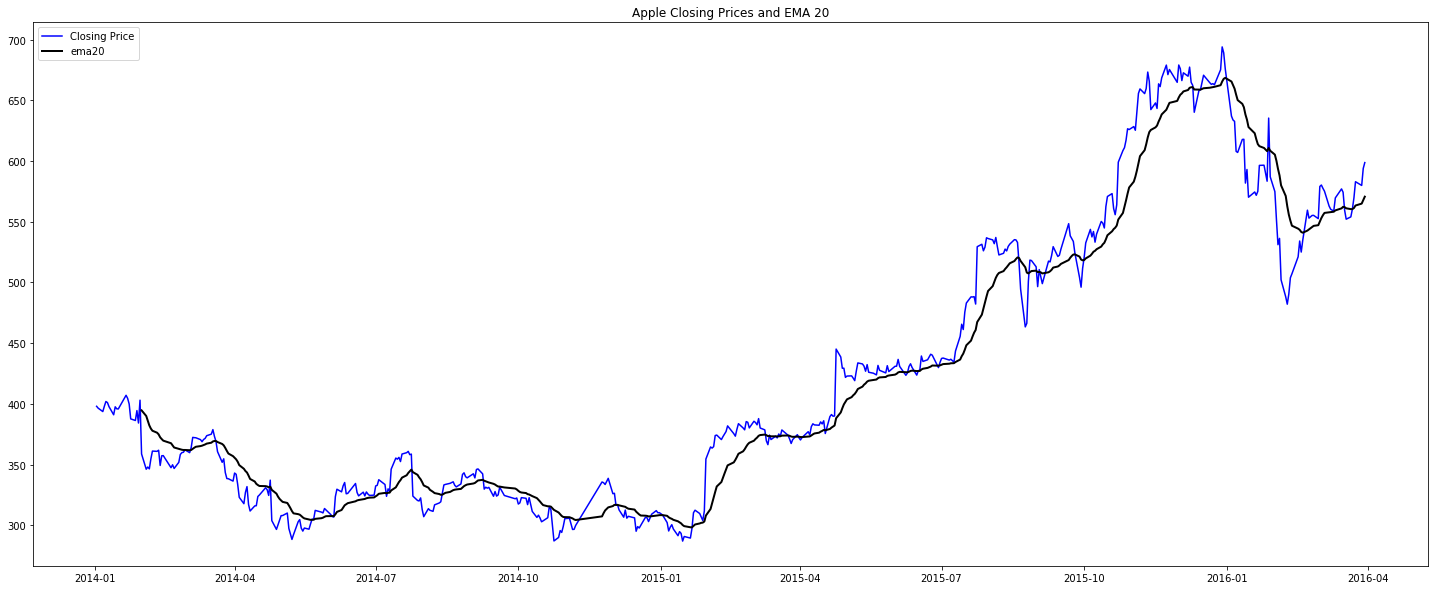

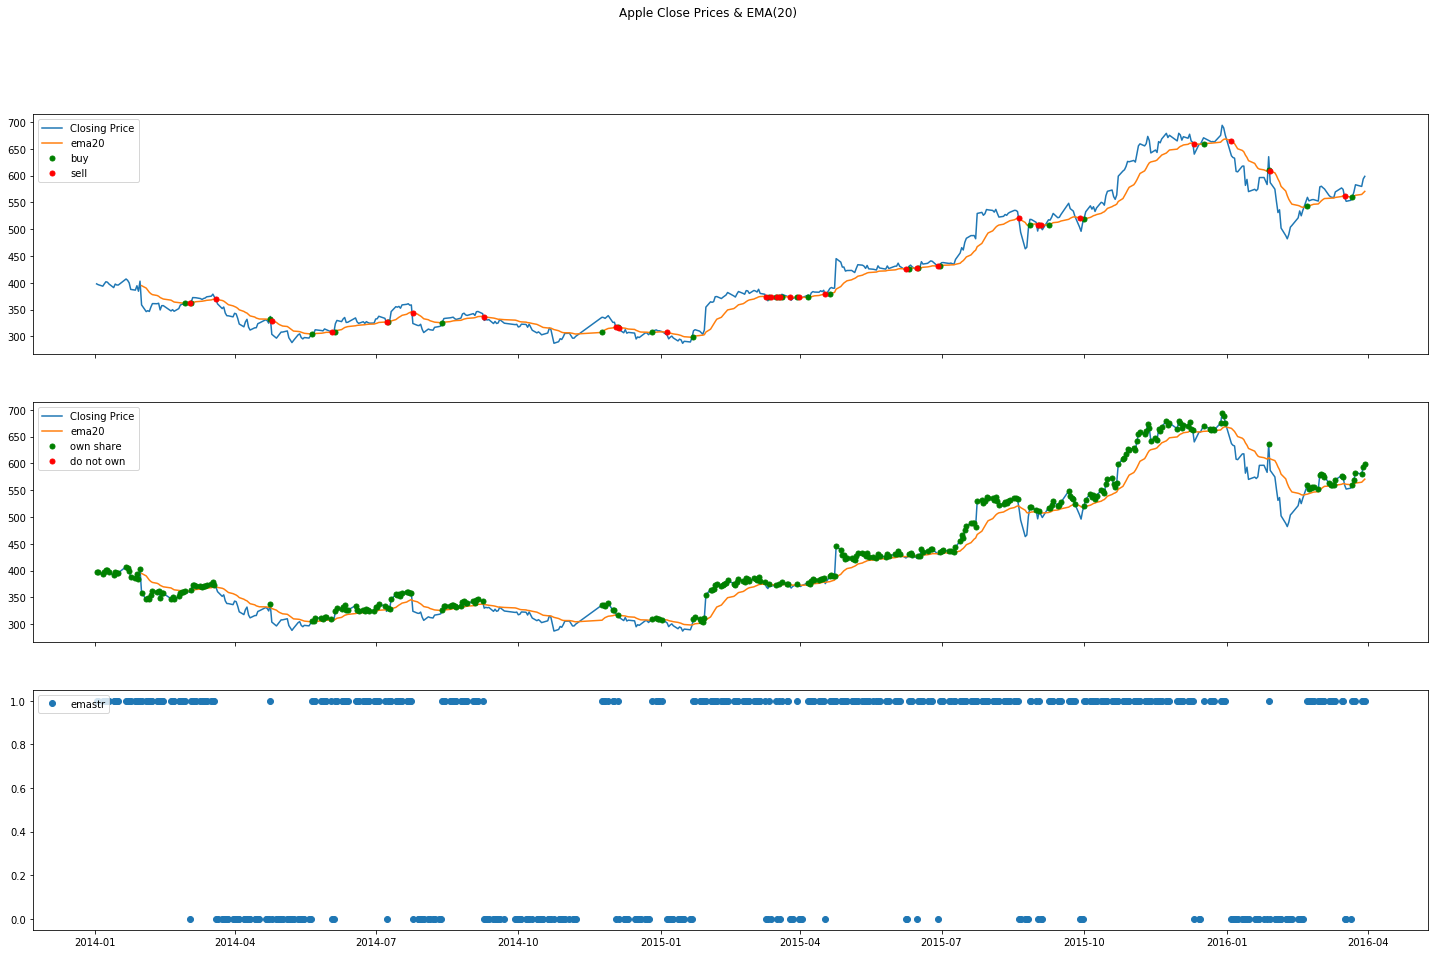

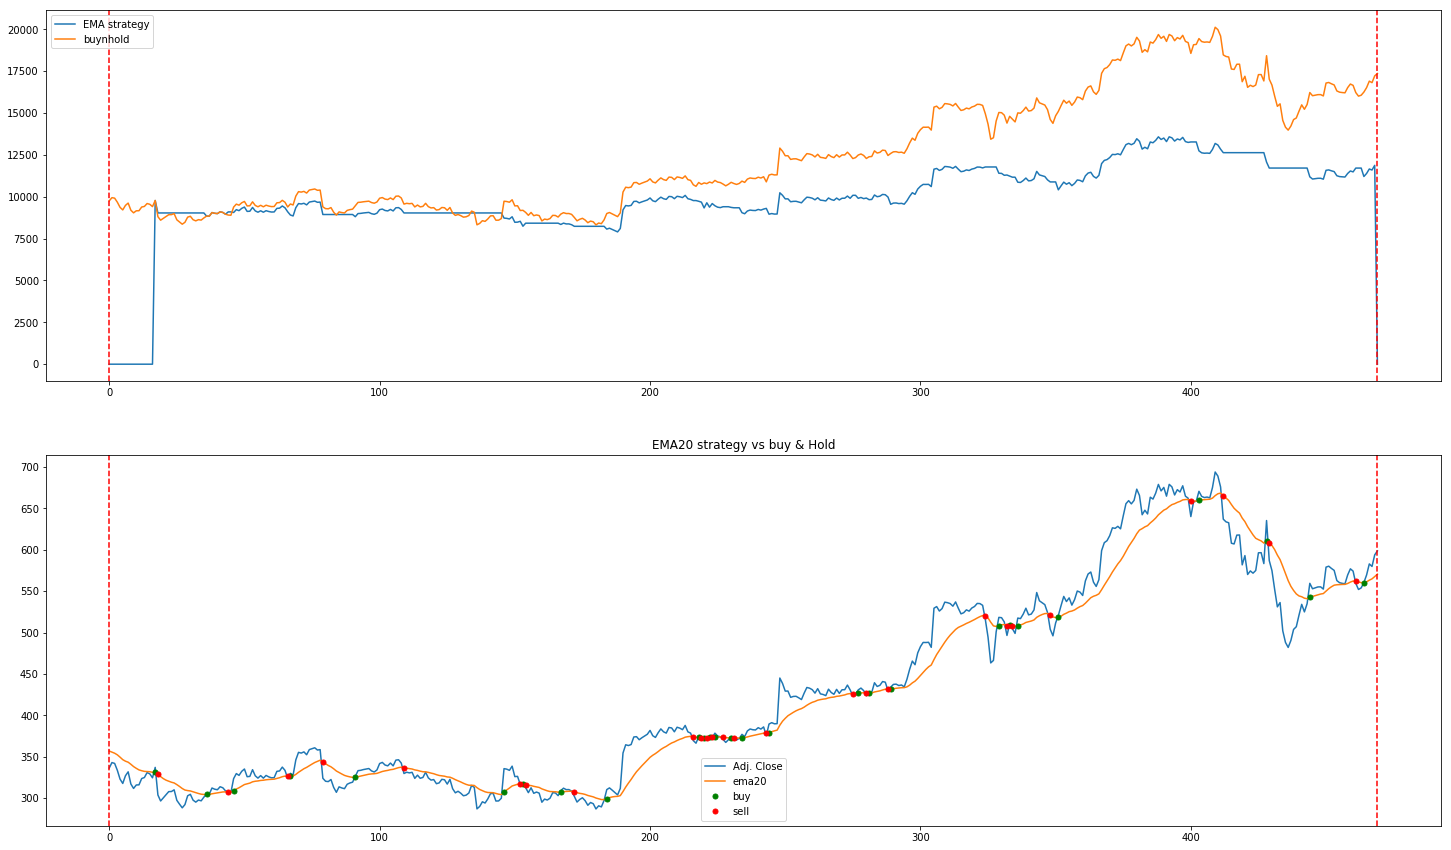

investing 10,000 pounds initially


0                 1              2             3              4  \
0                Inital Amount($)  Number Shares  Buy Price($)  Sell Price($)   
1  buy and hold            10,000             29        336.36         598.69   
2                                                                               
3          sma5            10,000            NaN        342.99         593.86   
4                                                                               
5          ema5            10,000            NaN        342.99         593.86   
6                                                                               
7         ema20            10,000            NaN        337.15         593.86   

                 5                  6          7                8  \
0  Price change($)  capital return($)  Profit($)  Total Return(%)   
1           262.33              17362    7362.01            73.62   
2                                                                   
3           250.87             8907.9    -1092.1           -10.92   
4                                                                   
5           250.87            10689.5     689.48             6.89   
6                                                                   
7           256.71            11877.2     1877.2            18.77   

                      9  
0  Annualised Return(%)  
1                 27.47  
2                        
3                   NaN  
4                        
5                  3.97  
6                        
7                  9.15

In [7]:
ema20_df = ticker_df.copy()
# set date as index now that we have merged all the data
ema20_df = ema20_df.set_index('Date')

#Add moving averages SMA
#ema_df['ema5'] = ta.EMA(np.asarray(ema_df['Adj. Close']), 5)
ema20_df['ema20'] = ta.EMA(np.asarray(ema20_df['Adj. Close']), 20)
#aapletweet['sma100'] = ta.SMA(np.asarray(aapletweet['Adj. Close']), 100)

#PLot chart
fig, ax = plt.subplots(figsize=(25, 10))


ax.plot(ema20_df['Adj. Close'], color='blue', label='Closing Price')

#5 day Moving Average
#ax.plot(ema20_df['ema20'], lw=2., color='grey', label='ema5')

#20 day Moving Average
ax.plot(ema20_df['ema20'], lw=2., color='black', label='ema20')

plt.title('Apple Closing Prices and EMA 20')
plt.legend(loc='upper left')
plt.show()

#*****

#Create training Signals with SMA5
#Initialise column
ema20_df['ema20sig'] = 0

#test this against one day lag
ema20sig = 0
ema20_df['Adj. Close(-1)'] = ema20_df['Adj. Close'].shift(1)
ema20_df['ema20(-1)'] = ema20_df['ema20'].shift(1)
#%%

# Generate Trading Signals (buy=1 , sell=-1, do nothing=0)
for i, row in enumerate(ema20_df.iterrows()):
    if row[1]['Adj. Close(-1)'] < row[1]['ema20(-1)'] and row[1]['Adj. Close'] > row[1]['ema20']:
       ema20sig = 1
    elif row[1]['Adj. Close(-1)'] > row[1]['ema20(-1)'] and row[1]['Adj. Close'] < row[1]['ema20']:
        ema20sig = -1
    else:
        ema20sig = 0
    ema20_df.iloc[i, 12] = ema20sig

ema20_df['ema20str'] = 1 # initially own the stock

ema20str = 0 # initialise all as 0

for i, row in enumerate(ema20_df.iterrows()):
  
  #get_previous = ema20_df['ema20str'].iloc[i-1]
  
  
  if row[1]['ema20sig'] == 1:
      ema20str = 1 #own the stock
  elif row[1]['ema20sig'] == -1:
      ema20str = 0 #don't own the stock
  else:
      ema20str = ema20_df['ema20str'].iloc[i-1] # if dont have either of above, just  repeat previous period trading strategy
  ema20_df.iloc[i, 15] = ema20str # continue to update
    
#next we create strategy chart

fig, ax = plt.subplots(3, sharex=True, figsize=(25,15))

ax[0].plot(ema20_df['Adj. Close'], label='Closing Price')
ax[0].plot(ema20_df['ema20'], label='ema20')

# Plot the buy signals
ax[0].plot(ema20_df.loc[ema20_df['ema20sig'] == 1.0].index, 
         ema20_df.ema20[ema20_df['ema20sig'] == 1.0],
         'o', markersize=5, color='g', label='buy')
         
# Plot the sell signals
ax[0].plot(ema20_df.loc[ema20_df['ema20sig'] == -1.0].index, 
         ema20_df.ema20[ema20_df['ema20sig'] == -1.0],
         'o', markersize=5, color='r', label='sell')

ax[0].legend(loc='upper left')

ax[1].plot(ema20_df['Adj. Close'], label='Closing Price')
ax[1].plot(ema20_df['ema20'], label='ema20')
ax[1].legend(loc='upper left')

# Plot the buy signals
ax[1].plot(ema20_df.loc[ema20_df['ema20str'] == 1.0].index, 
         ema20_df['Adj. Close'][ema20_df['ema20str'] == 1.0],
         'o', markersize=5, color='g', label='own share')
         
# Plot the sell signals
ax[1].plot(ema20_df.loc[ema20_df['ema20str'] == -1.0].index, 
         ema20_df['Adj. Close'][ema20_df['ema20str'] == -1.0],
         'o', markersize=5, color='r', label='do not own')

ax[1].legend(loc='best')

ax[2].plot(ema20_df['ema20str'], marker='o', linestyle='', label='emastr')
ax[2].legend(loc='upper left')
plt.suptitle('Apple Close Prices & EMA(20)')
plt.show()

#*******

#Finally for strategy performance metrics

#ema_df.set_index('Date', inplace=True)
ema20_df = ema20_df['2014-03-31' : '2016-03-31']
ema20_df = ema20_df.reset_index()

# Teesting against invested funds
investment = 10000
ema20_df['capital']= investment
ema20_df['invested'] = 0
ema20_df['price'] = ema20_df['Adj. Close']
ema20_df['pnl'] = 0 # initially own the stock
ema20_df['shares'] = int(investment / ema20_df['Adj. Close'][0])
ema20_df['buynhold'] = ema20_df['shares'] * ema20_df['Adj. Close']


ema20_df['capital'] = ema20_df['capital'].astype('float64') 
ema20_df['invested'] = ema20_df['invested'].astype('float64')
ema20_df['pnl'] = ema20_df['pnl'].astype('float64')
ema20_df['shares'] = ema20_df['shares'].astype('float64')
ema20_df['buynhold'] = ema20_df['buynhold'].astype('float64')

ema20_df = ema20_df.round(2)


for i in range(0,len(ema20_df)-1):
  
  get_price = ema20_df['Adj. Close'].iloc[i]

  inital = 0 
  buy_price=0
  difference_price=0
  sell_price=0
  next_date = ema20_df.Date.iloc[i+1]
  capital_1 = ema20_df['capital'].iloc[i-1]
  capital = ema20_df['capital'].iloc[i]
  nominal = ema20_df['pnl'].iloc[i]-1
  capital_invested = ema20_df['Adj. Close'].iloc[i]
  invested_shares = int(ema20_df['capital'].iloc[i-1] / get_price)
  #pnl = invested_shares * get_price

  get_pnl = ema20_df['pnl'].iloc[i-1]
  ema20 = ema20_df['ema20'].iloc[i]
  ema20str = ema20_df['ema20str'].iloc[i]
  ema20sig = ema20_df['ema20sig'].iloc[i]
  ema20str_1 = ema20_df['ema20str'].iloc[i-1]
  invested_1 = ema20_df['invested'].iloc[i-1]
  invested = ema20_df['invested'].iloc[i]
  buynhold = ema20_df['shares'].iloc[i] * get_price
  pnl_1 = ema20_df['pnl'].iloc[i-1]
  shares = ema20_df['shares'].iloc[i]
  
  
  if(ema20str) == 0 and i==0:
    #print('i=0')
    ema20_df.at[i,'capital'] = investment    
    ema20_df.at[i,'invested'] = 0       
    ema20_df.at[i,'pnl'] = 0 
    
  
  elif(ema20str) == 1 and i==0:
    #print('i=0')
    ema20_df.at[i,'invested'] = int(investment/ get_price)      
    ema20_df.at[i,'capital'] = int(initial - ((ema20_df['invested'].iloc[i] *get_price)))      
    ema20_df.at[i,'pnl'] = ema20_df['invested'].iloc[i] * get_price   
  
  elif(ema20str) == 0 and ema20str_1 == 0 and capital_1 ==investment:
    ema20_df.at[i,'invested'] = invested_1  
    ema20_df.at[i,'capital'] = capital_1
    ema20_df.at[i, 'pnl'] = 0
   
    
  elif(ema20str) == 0 and ema20str_1 == 0 and capital_1 !=investment:
    ema20_df.at[i,'invested'] = invested_1  
    ema20_df.at[i,'capital'] = capital_1
    ema20_df.at[i, 'pnl'] = pnl_1
     
 
  elif(ema20str) == 1 and ema20str_1 == 0:
    ema20_df.at[i,'invested'] = int(capital_1/ get_price)  
    ema20_df.at[i,'capital'] = int(capital_1 - ((ema20_df['invested'].iloc[i] *get_price)))
    ema20_df.at[i, 'pnl'] = ema20_df['invested'].iloc[i] * get_price
    price_buy = get_price
  
  elif(ema20str) == 0 and ema20str_1 == 1 and capital_1 !=investment:
    #print('i=0')
    differece_price = (get_price - price_buy) 
    ema20_df.at[i,'capital'] = capital_1 + (invested_1 * get_price) + (difference_price * invested_1)    
    ema20_df.at[i,'invested'] = 0       
    ema20_df.at[i,'pnl'] = ema20_df['capital'].iloc[i]
    
    
  else:
        
    ema20_df.at[i,'capital'] = capital_1    
    ema20_df.at[i,'invested'] = invested_1       
    ema20_df.at[i,'pnl'] = ema20_df['invested'].iloc[i] * get_price
    
ema20_1_df = ema20_df[['Date', 'Adj. Close', 'Comp', 'ema20', 'ema20sig', 'ema20str', 'capital', 'invested', 'pnl', 'shares', 'buynhold']]

endYr2 = ema20_1_df.index[-1]

#slide dataframe for 2 years

# pnl Returns Chart
fig, ax = plt.subplots(2, figsize=(25, 15))

ax[0].plot(ema20_1_df['pnl'], label = 'EMA strategy' )
ax[0].plot(ema20_1_df['buynhold'], label = 'buynhold')

ax[0].axvline(0, color='r', ls='--')
ax[0].axvline(ema20_df.index[-1], color='r', ls='--')

ax[0].legend(loc='upper left')

# Plot the buy signals
ax[1].plot(ema20_1_df['Adj. Close'], label='Adj. Close')
ax[1].plot(ema20_1_df['ema20'], label='ema20')

ax[1].plot(ema20_1_df.loc[ema20_1_df['ema20sig'] == 1.0].index, 
         ema20_1_df.ema20[ema20_1_df['ema20sig'] == 1.0],
         'o', markersize=5, color='g', label='buy')
         
# Plot the sell signals
ax[1].plot(ema20_1_df.loc[ema20_1_df['ema20sig'] == -1.0].index, 
         ema20_1_df.ema20[ema20_1_df['ema20sig'] == -1.0],
         'o', markersize=5, color='r', label='sell')

ax[1].axvline(0, color='r', ls='--')
ax[1].axvline(ema20_df.index[-1], color='r', ls='--')

ax[1].legend(loc='upper left')

plt.title('EMA20 strategy vs buy & Hold')
plt.legend()
plt.show()

ema20BuyIndexyr1=17
ema20SellIndexyr2=468

ema20BuyPrice_yr1 = ema20_1_df['Adj. Close'].iloc[ema20BuyIndexyr1]
ema20SellPrice_yr2 = ema20_1_df['Adj. Close'].iloc[ema20SellIndexyr2]

ema20shares_invested = int(initial / ema20BuyPrice_yr1)

ema20capital_return = ema20_1_df['pnl'][ema20SellIndexyr2]

ema20Price_change = ema20SellPrice_yr2 - ema20BuyPrice_yr1

ema20capital_return_yr2 = ema20_1_df['pnl'].loc[ema20SellIndexyr2]

ema20Profit = ema20capital_return - initial
ema20Return = ((ema20Profit/initial)*100).round(2)

def annualisedEma20():
  if ((len(ema20_df) > 365)):
    ema20RReturn = ((1 + ema20Return)**(365/len(ema20_1_df))-1).round(2)
  else:
    ema20RReturn = 0
    
  return ema20RReturn

print('investing 10,000 pounds initially')

# Summary Results Data Table
ema20data = [{'0': '', '1': 'Inital Amount($)', '2': 'Number Shares', '3': 'Buy Price($)', '4': 'Sell Price($)', '5': 'Price change($)', '6': 'capital return($)', '7': 'Profit($)', '8': 'Total Return(%)', '9': 'Annualised Return(%)'},
        {'0': 'buy and hold', '1': '10,000', '2': bhshares_invested, '3': bhBuyPrice_yr1, '4': bhSellPrice_yr2, '5': bhPrice_change_yr2,  '6': bhcapitalReturnyr2, '7': bhProfit_yr2, '8': bhReturn_yr2, '9': annualised()},  
         
        {'0': '', '1':'' , '2': '', '3': '', '4': '', '5': '', '6': '', '7': '', '8': '', '9': ''},
        
        {'0': 'sma5', '1': '10,000', '2': 'NaN', '3': sma5BuyPrice_yr1, '4': sma5SellPrice_yr2, '5': sma5Price_change_yr2,  '6': sma5capital_return_yr2, '7': sma5Profit_yr2, '8': sma5Return_yr2, '9': annualisedSma()},

            
             {'0': '', '1':'' , '2': '', '3': '', '4': '', '5': '', '6': '', '7': '', '8': '', '9': ''},
        
        {'0': 'ema5', '1': '10,000', '2': 'NaN', '3': ema5BuyPrice_yr1, '4': ema5SellPrice_yr2, '5': ema5Price_change_yr2,  '6': ema5capital_return_yr2, '7': ema5Profit_yr2, '8': ema5Return_yr2, '9': annualisedEma()},
    

            {'0': '', '1':'' , '2': '', '3': '', '4': '', '5': '', '6': '', '7': '', '8': '',  '9': ''},
        
        {'0': 'ema20', '1': '10,000', '2': 'NaN', '3': ema20BuyPrice_yr1, '4': ema20SellPrice_yr2, '5': ema20Price_change,  '6': ema20capital_return, '7': ema20Profit, '8': ema20Return, '9': annualisedEma20()}]
          
    
    
    
table = pd.DataFrame(ema20data)

table


#********




In [0]:
 #***************end************************

# Technical Analysis - BB

No handles with labels found to put in legend.


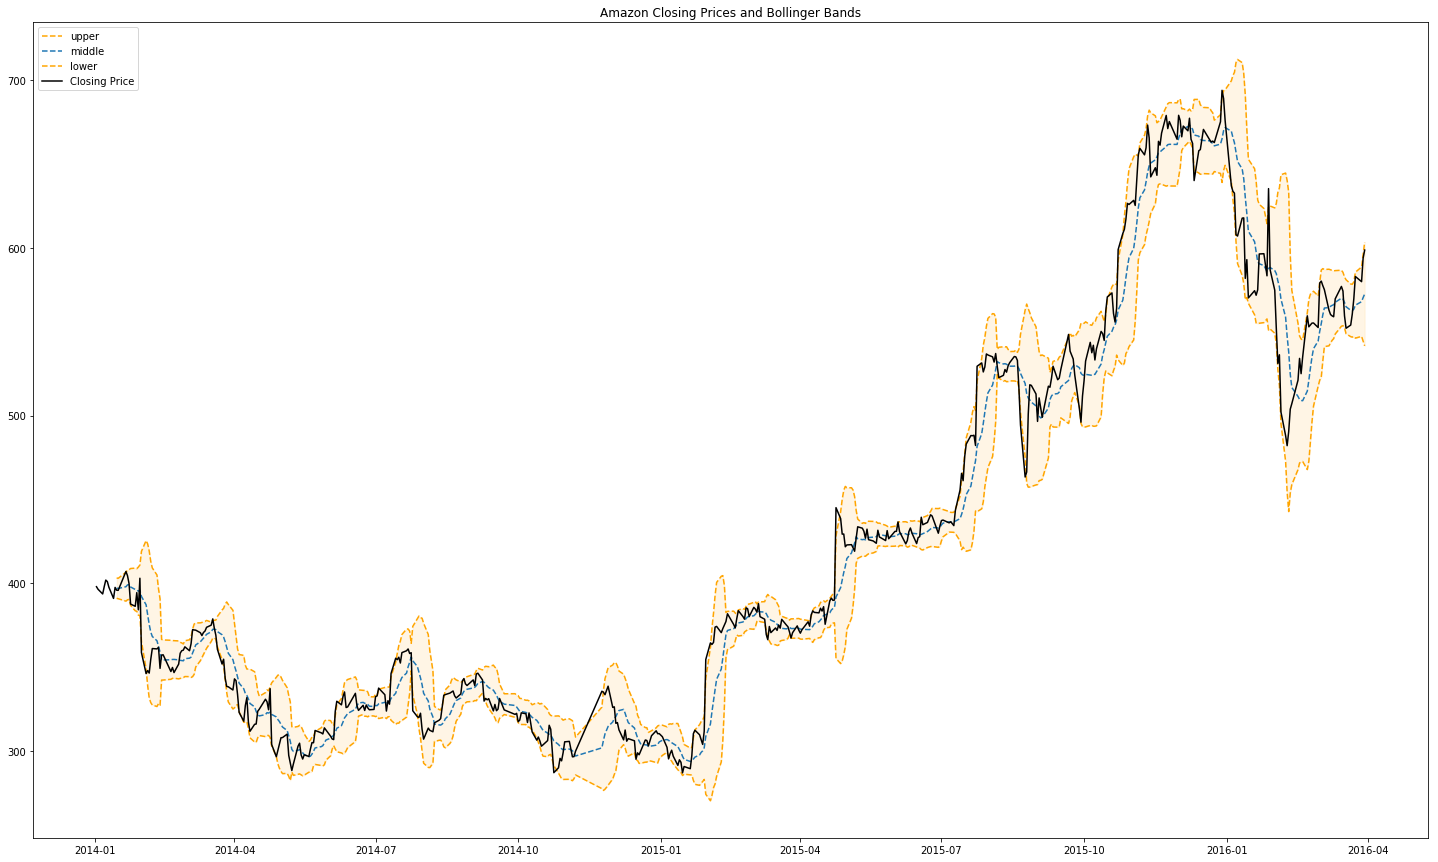

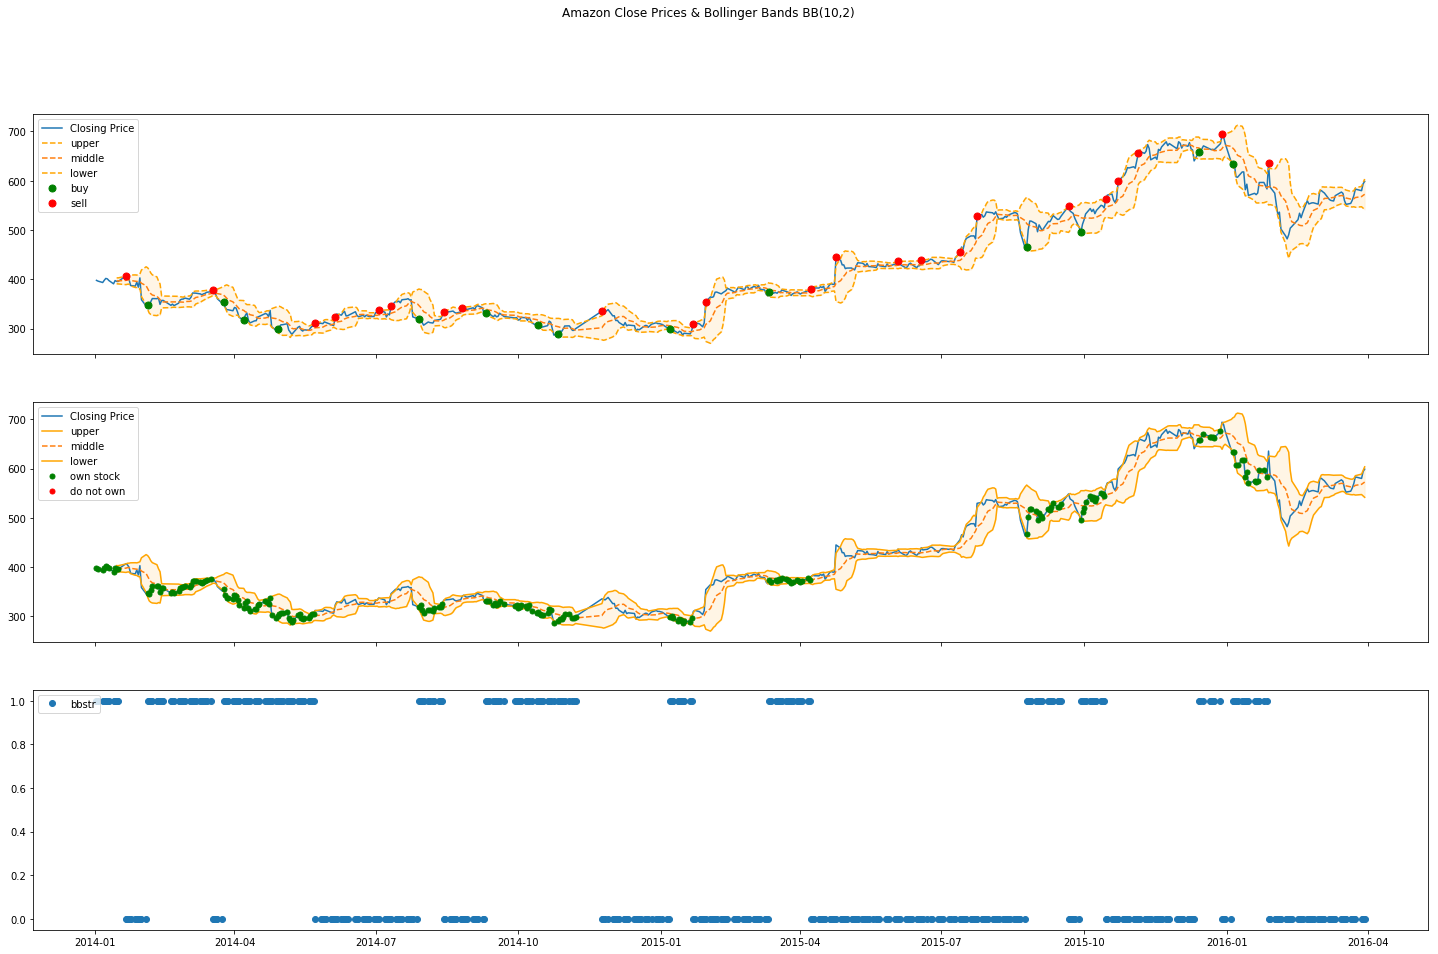

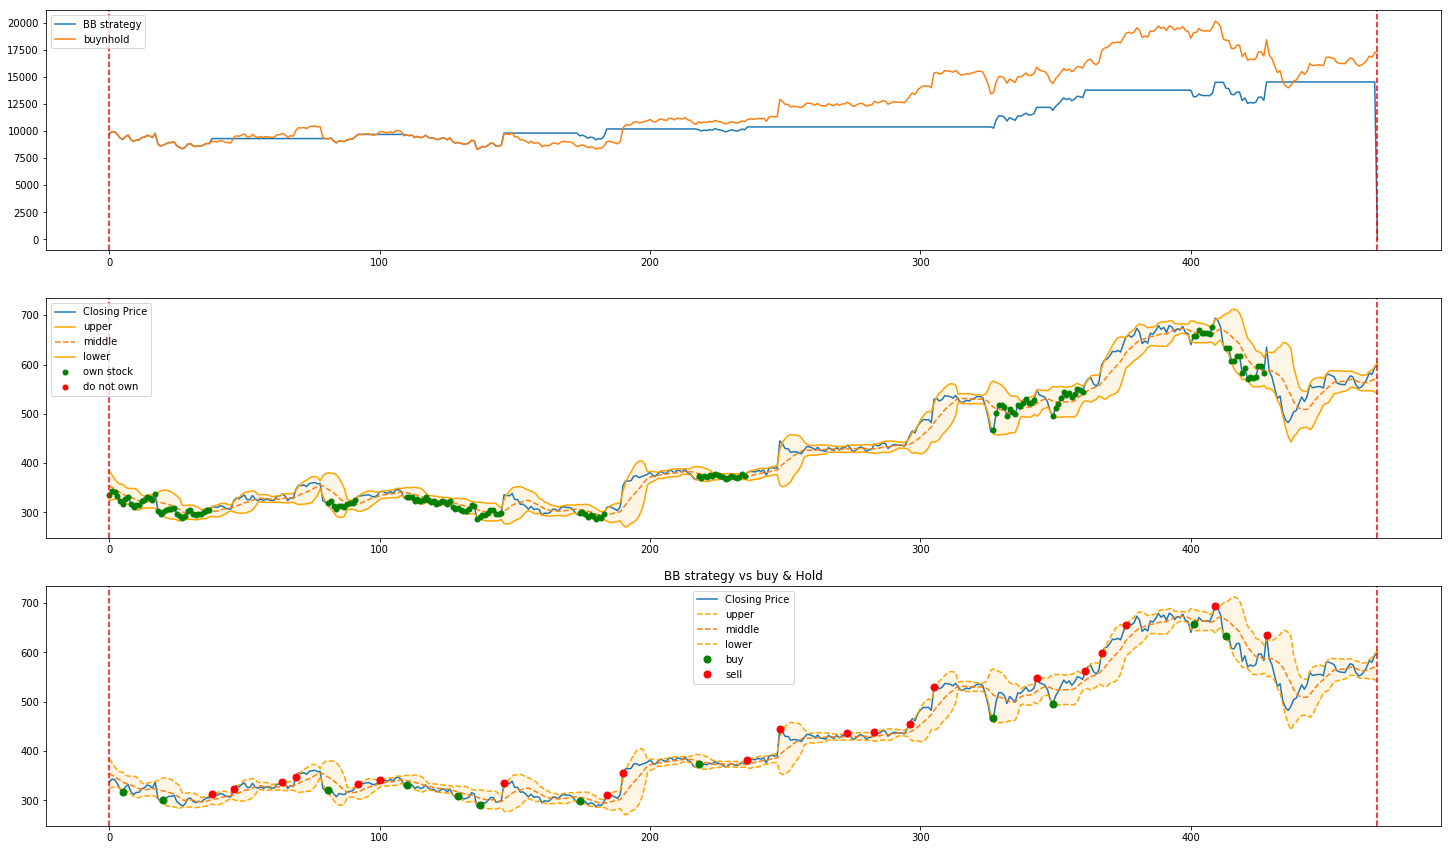

investing 10,000 pounds initially


0                 1              2             3              4  \
0                Inital Amount($)  Number Shares  Buy Price($)  Sell Price($)   
1  buy and hold            10,000             29        336.36         598.69   
2                                                                               
3          sma5            10,000            NaN        342.99         593.86   
4                                                                               
5          ema5            10,000            NaN        342.99         593.86   
6                                                                               
7         ema20            10,000            NaN        337.15         593.86   
8                                                                               
9            BB            10,000            NaN        336.36         635.35   

                 5                  6          7                8  \
0  Price change($)  capital return($)  Profit($)  Total Return(%)   
1           262.33              17362    7362.01            73.62   
2                                                                   
3           250.87             8907.9    -1092.1           -10.92   
4                                                                   
5           250.87            10689.5     689.48             6.89   
6                                                                   
7           256.71            11877.2     1877.2            18.77   
8                                                                   
9           298.99            14525.7     4525.7            45.26   

                      9  
0  Annualised Return(%)  
1                 27.47  
2                        
3                   NaN  
4                        
5                  3.97  
6                        
7                  9.15  
8                        
9                 18.64

In [8]:
boll_df = ticker_df.copy()

# set date as index now that we have merged all the data
boll_df = boll_df.set_index('Date')

#Add bollinger Bands
boll_df['upper'], boll_df['middle'], boll_df['lower'] = ta.BBANDS(np.asarray(boll_df['Adj. Close']), timeperiod=10, nbdevup=2, nbdevdn=2, matype=0)

#PLot chart
fig1, ax = plt.subplots(figsize=(25, 15))
ax.legend(loc='upper left')
ax.plot(boll_df['upper'], linestyle='--', color='orange', label='upper')
ax.plot(boll_df['middle'], linestyle='--')
ax.plot(boll_df['lower'], linestyle='--', color='orange', label='lower')
ax.fill_between(boll_df.index, boll_df['upper'], boll_df['lower'], interpolate=True, color = 'orange', alpha=0.1)
ax.plot(boll_df['Adj. Close'], color='black', label='Closing Price')

plt.title('{} Closing Prices and Bollinger Bands'.format(ticker_name))
plt.legend(loc='upper left')
plt.show()


#********

# Generate Trading Signals (buy=1 , sell=-1, do nothing=0)
boll_df['bbsig'] = 0
boll_df.columns, boll_df.shape

#Iterate over the rows
bbsig = 0

# Previous Periods Data (avoid back-testing bias)
boll_df['Close(-1)'] = boll_df['Adj. Close'].shift(1)
boll_df['lower(-1)'] = boll_df['lower'].shift(1)
boll_df['upper(-1)'] = boll_df['upper'].shift(1)

for i, row in enumerate(boll_df.iterrows()):
    if row[1]['Close(-1)'] < row[1]['lower(-1)'] and row[1]['Adj. Close'] > row[1]['lower']:
        bbsig = 1
    elif row[1]['Close(-1)'] < row[1]['upper(-1)'] and row[1]['Adj. Close'] > row[1]['upper']:
        bbsig = -1
    else:
        bbsig = 0
    boll_df.iloc[i, 14] = bbsig


boll_df['bbstr'] = 1 # initially own the stock

bbstr = 0 # initialise all as 0

# Generate Trading Signals (buy=1 , sell=-1, do nothing=0)
for i, row in enumerate(boll_df.iterrows()):
    if row[1]['bbsig'] == 1:
        bbstr = 1
    elif row[1]['bbsig'] == -1:
        bbstr = 0
    else:
        bbstr = boll_df['bbstr'].iloc[i-1]
    
    boll_df.iloc[i, 18] = bbstr

#next we create strategy chart


fig, ax = plt.subplots(3, sharex=True, figsize=(25, 15))

ax[0].plot(boll_df['Adj. Close'], label= 'Closing Price')
ax[0].legend(loc='upper left')
ax[0].plot(boll_df['upper'], linestyle='--', color='orange', label='upper')
ax[0].plot(boll_df['middle'], linestyle='--')
ax[0].plot(boll_df['lower'], linestyle='--', color='orange', label='lower')
ax[0].fill_between(boll_df.index, boll_df['upper'], boll_df['lower'], interpolate=True, color = 'orange', alpha=0.1)

# Plot the buy signals
ax[0].plot(boll_df.loc[boll_df['bbsig'] == 1.0].index, 
         boll_df['Adj. Close'][boll_df['bbsig'] == 1.0],
         'o', markersize=7, color='g', label='buy')
         
# Plot the sell signals
ax[0].plot(boll_df.loc[boll_df['bbsig'] == -1.0].index, 
         boll_df['Adj. Close'][boll_df['bbsig'] == -1.0],
         'o', markersize=7, color='r', label='sell')

ax[0].legend(loc='best')

ax[1].plot(boll_df['Adj. Close'], label= 'Closing Price')
ax[1].plot(boll_df['upper'], color='orange', label='upper')
ax[1].plot(boll_df['middle'], linestyle='--')
ax[1].plot(boll_df['lower'], color='orange', label='lower')
ax[1].fill_between(boll_df.index, boll_df['upper'], boll_df['lower'], interpolate=True, color = 'orange', alpha=0.1)
ax[1].legend(loc='upper left')

# Plot the buy signals
ax[1].plot(boll_df.loc[boll_df['bbstr'] == 1.0].index, 
         boll_df['Adj. Close'][boll_df['bbstr'] == 1.0],
         'o', markersize=5, color='g', label='own stock')
         
# Plot the sell signals
ax[1].plot(boll_df.loc[boll_df['bbstr'] == -1.0].index, 
         boll_df['Adj. Close'][boll_df['bbstr'] == -1.0],
         'o', markersize=5, color='r', label='do not own')

ax[1].legend(loc='best')

ax[2].plot(boll_df['bbstr'], marker='o', linestyle='', label='bbstr')
ax[2].legend(loc='upper left')
plt.suptitle('{} Close Prices & Bollinger Bands BB(10,2)'.format(ticker_name))
plt.show()

#********

#ema_df.set_index('Date', inplace=True)
boll_df = boll_df['2014-03-31' : '2016-03-31']
boll_df = boll_df.reset_index()

#now to test against real money
bb_investment = 10000
boll_df['capital']= investment
boll_df['invested'] = 0
boll_df['price'] = boll_df['Adj. Close']
boll_df['pnl'] = 0 # initially own the stock
boll_df['shares'] = int(investment / boll_df['Adj. Close'][0])
boll_df['buynhold'] = boll_df['shares'] * boll_df['Adj. Close']


boll_df['capital'] = boll_df['capital'].astype('float64') 
boll_df['invested'] = boll_df['invested'].astype('float64')
boll_df['pnl'] = boll_df['pnl'].astype('float64')
boll_df['shares'] = boll_df['shares'].astype('float64')
boll_df['buynhold'] = boll_df['buynhold'].astype('float64')

boll_df = boll_df.round(2)


for i in range(0,len(boll_df)-1):
  
  bb_get_price = boll_df['Adj. Close'].iloc[i]

  bb_initial = 0 
  bb_buy_price=0
  bb_difference_price=0
  bb_sell_price=0
  bb_next_date = boll_df.Date.iloc[i+1]
  bb_capital_1 = boll_df['capital'].iloc[i-1]
  bb_capital = boll_df['capital'].iloc[i]
  bb_nominal = boll_df['pnl'].iloc[i]-1
  bb_capital_invested = boll_df['Adj. Close'].iloc[i]
  bb_invested_shares = int(boll_df['capital'].iloc[i-1] / bb_get_price)
  #pnl = invested_shares * get_price

  bb_get_pnl = boll_df['pnl'].iloc[i-1]
  bbstr = boll_df['bbstr'].iloc[i]
  bbstr_1 = boll_df['bbstr'].iloc[i-1]
  bb_invested_1 = boll_df['invested'].iloc[i-1]
  bb_invested = boll_df['invested'].iloc[i]
  bb_pnl_1 = boll_df['pnl'].iloc[i-1]
  
  
  if(bbstr) == 0 and i==0:
    #print('i=0')
    boll_df.at[i,'capital'] = bb_investment    
    boll_df.at[i,'invested'] = 0       
    boll_df.at[i,'pnl'] = 0  
    
  elif(bbstr) == 1 and i==0:
    #print('i=0')
    boll_df.at[i,'invested'] = int(bb_investment/ bb_get_price)      
    boll_df.at[i,'capital'] = int(10000 - ((boll_df['invested'].iloc[i] * bb_get_price)))      
    boll_df.at[i,'pnl'] = boll_df['invested'].iloc[i] * bb_get_price  
  
  elif(bbstr) == 0 and bbstr_1 == 0 and bb_capital_1 == bb_investment:
    boll_df.at[i,'invested'] = bb_invested_1  
    boll_df.at[i,'capital'] = bb_capital_1
    boll_df.at[i, 'pnl'] = 0
    
  elif(bbstr) == 0 and bbstr_1 == 0 and bb_capital_1 != bb_investment:
    boll_df.at[i,'invested'] = bb_invested_1  
    boll_df.at[i,'capital'] = bb_capital_1
    boll_df.at[i, 'pnl'] = bb_pnl_1
     
 
  elif(bbstr) == 1 and bbstr_1 == 0:
    boll_df.at[i,'invested'] = int(bb_capital_1/ bb_get_price)  
    boll_df.at[i,'capital'] = int(bb_capital_1 - ((boll_df['invested'].iloc[i] * bb_get_price)))
    boll_df.at[i, 'pnl'] = boll_df['invested'].iloc[i] * bb_get_price
    bb_price_buy = bb_get_price
           
  elif(bbstr) == 0 and bbstr_1 == 1 and bb_capital_1 != bb_investment:
    #print('i=0')
    bb_differece_price = (bb_get_price - bb_buy_price) 
    boll_df.at[i,'capital'] = bb_capital_1 + (bb_invested_1 * bb_get_price) + (bb_difference_price * bb_invested_1)    
    boll_df.at[i,'invested'] = 0       
    boll_df.at[i,'pnl'] = boll_df['capital'].iloc[i]      
  
  else:
    
    boll_df.at[i,'capital'] = bb_capital_1    
    boll_df.at[i,'invested'] = bb_invested_1       
    boll_df.at[i,'pnl'] = boll_df['invested'].iloc[i] * bb_get_price

boll_LSTM = boll_df.copy()
boll_df = boll_df[['Date', 'Adj. Close', 'Comp', 'upper', 'middle', 'lower', 'bbsig', 'bbstr', 'capital', 'invested', 'pnl', 'shares', 'buynhold']]


BollEndYr2 = boll_df.index[-1]

#slide dataframe for 2 years

# pnl Returns Chart
fig, ax = plt.subplots(3, figsize=(25, 15))

ax[0].plot(boll_df['pnl'], label = 'BB strategy' )
ax[0].plot(boll_df['buynhold'], label = 'buynhold')

ax[0].axvline(0, color='r', ls='--')
ax[0].axvline(boll_df.index[-1], color='r', ls='--')

#sma_df.loc[(sma_df['Date'].dt.month==12) & (sma_df['Date'].dt.day==31) & (sma_df['Date'].dt.year==2014), 'Adj. Close']

ax[0].legend(loc='upper left')

ax[1].plot(boll_df['Adj. Close'], label= 'Closing Price')
ax[1].plot(boll_df['upper'], color='orange', label='upper')
ax[1].plot(boll_df['middle'], linestyle='--')
ax[1].plot(boll_df['lower'], color='orange', label='lower')
ax[1].fill_between(boll_df.index, boll_df['upper'], boll_df['lower'], interpolate=True, color = 'orange', alpha=0.1)
ax[1].legend(loc='upper left')

# Plot the buy signals
ax[1].plot(boll_df.loc[boll_df['bbstr'] == 1.0].index, 
         boll_df['Adj. Close'][boll_df['bbstr'] == 1.0],
         'o', markersize=5, color='g', label='own stock')
         
# Plot the sell signals
ax[1].plot(boll_df.loc[boll_df['bbstr'] == -1.0].index, 
         boll_df['Adj. Close'][boll_df['bbstr'] == -1.0],
         'o', markersize=5, color='r', label='do not own')

ax[1].legend(loc='best')

ax[1].axvline(0, color='r', ls='--')
ax[1].axvline(boll_df.index[-1], color='r', ls='--')

ax[1].legend(loc='upper left')

ax[2].plot(boll_df['Adj. Close'], label= 'Closing Price')
ax[2].legend(loc='upper left')
ax[2].plot(boll_df['upper'], linestyle='--', color='orange', label='upper')
ax[2].plot(boll_df['middle'], linestyle='--')
ax[2].plot(boll_df['lower'], linestyle='--', color='orange', label='lower')
ax[2].fill_between(boll_df.index, boll_df['upper'], boll_df['lower'], interpolate=True, color = 'orange', alpha=0.1)

# Plot the buy signals
ax[2].plot(boll_df.loc[boll_df['bbsig'] == 1.0].index, 
         boll_df['Adj. Close'][boll_df['bbsig'] == 1.0],
         'o', markersize=7, color='g', label='buy')
         
# Plot the sell signals
ax[2].plot(boll_df.loc[boll_df['bbsig'] == -1.0].index, 
         boll_df['Adj. Close'][boll_df['bbsig'] == -1.0],
         'o', markersize=7, color='r', label='sell')

ax[2].axvline(0, color='r', ls='--')
ax[2].axvline(boll_df.index[-1], color='r', ls='--')

ax[2].legend(loc='best')

plt.title('BB strategy vs buy & Hold')
plt.legend()
plt.show()

#*******************************
bollBuyIndexyr1=0
bollSellIndexyr2=428

bollBuyPrice_yr1 = boll_df['Adj. Close'].iloc[bollBuyIndexyr1]
bollSellPrice_yr2 = boll_df['Adj. Close'].iloc[bollSellIndexyr2]

bollshares_invested = int(initial / bollBuyPrice_yr1)

bollcapital_return = boll_df['pnl'][bollSellIndexyr2]

bollPrice_change = bollSellPrice_yr2 - bollBuyPrice_yr1

bollProfit = (bollcapital_return - initial).round(2)

bollReturn = ((bollProfit/initial)*100).round(2)



def annualisedBoll():
  if ((len(ema_df) > 365)):
    boll_df_return = ((1 + bollReturn)**(365/len(boll_df))-1).round(2)
  else:
    boll_df_return = 0
  
  return boll_df_return
  

print('investing 10,000 pounds initially')

# Summary Results Data Table
boll_data = [{'0': '', '1': 'Inital Amount($)', '2': 'Number Shares', '3': 'Buy Price($)', '4': 'Sell Price($)', '5': 'Price change($)', '6': 'capital return($)', '7': 'Profit($)', '8': 'Total Return(%)', '9': 'Annualised Return(%)'},
        {'0': 'buy and hold', '1': '10,000', '2': bhshares_invested, '3': bhBuyPrice_yr1, '4': bhSellPrice_yr2, '5': bhPrice_change_yr2,  '6': bhcapitalReturnyr2, '7': bhProfit_yr2, '8': bhReturn_yr2, '9': annualised()},  
         
        {'0': '', '1':'' , '2': '', '3': '', '4': '', '5': '', '6': '', '7': '', '8': '', '9': ''},
        
        {'0': 'sma5', '1': '10,000', '2': 'NaN', '3': sma5BuyPrice_yr1, '4': sma5SellPrice_yr2, '5': sma5Price_change_yr2,  '6': sma5capital_return_yr2, '7': sma5Profit_yr2, '8': sma5Return_yr2, '9': annualisedSma()},

            
             {'0': '', '1':'' , '2': '', '3': '', '4': '', '5': '', '6': '', '7': '', '8': '', '9': ''},
        
        {'0': 'ema5', '1': '10,000', '2': 'NaN', '3': ema5BuyPrice_yr1, '4': ema5SellPrice_yr2, '5': ema5Price_change_yr2,  '6': ema5capital_return_yr2, '7': ema5Profit_yr2, '8': ema5Return_yr2, '9': annualisedEma()},
    

            {'0': '', '1':'' , '2': '', '3': '', '4': '', '5': '', '6': '', '7': '', '8': '',  '9': ''},
        
        {'0': 'ema20', '1': '10,000', '2': 'NaN', '3': ema20BuyPrice_yr1, '4': ema20SellPrice_yr2, '5': ema20Price_change,  '6': ema20capital_return, '7': ema20Profit, '8': ema20Return, '9': annualisedEma20()},
         
              {'0': '', '1':'' , '2': '', '3': '', '4': '', '5': '', '6': '', '7': '', '8': '', '9': ''},
        
        {'0': 'BB', '1': '10,000', '2': 'NaN', '3': bollBuyPrice_yr1, '4': bollSellPrice_yr2, '5': bollPrice_change,  '6': bollcapital_return, '7': bollProfit, '8': bollReturn, '9': annualisedBoll()}]    

table = pd.DataFrame(boll_data)

table

#**********



In [0]:
#*********end*********************

# Technical Analysis - RSI

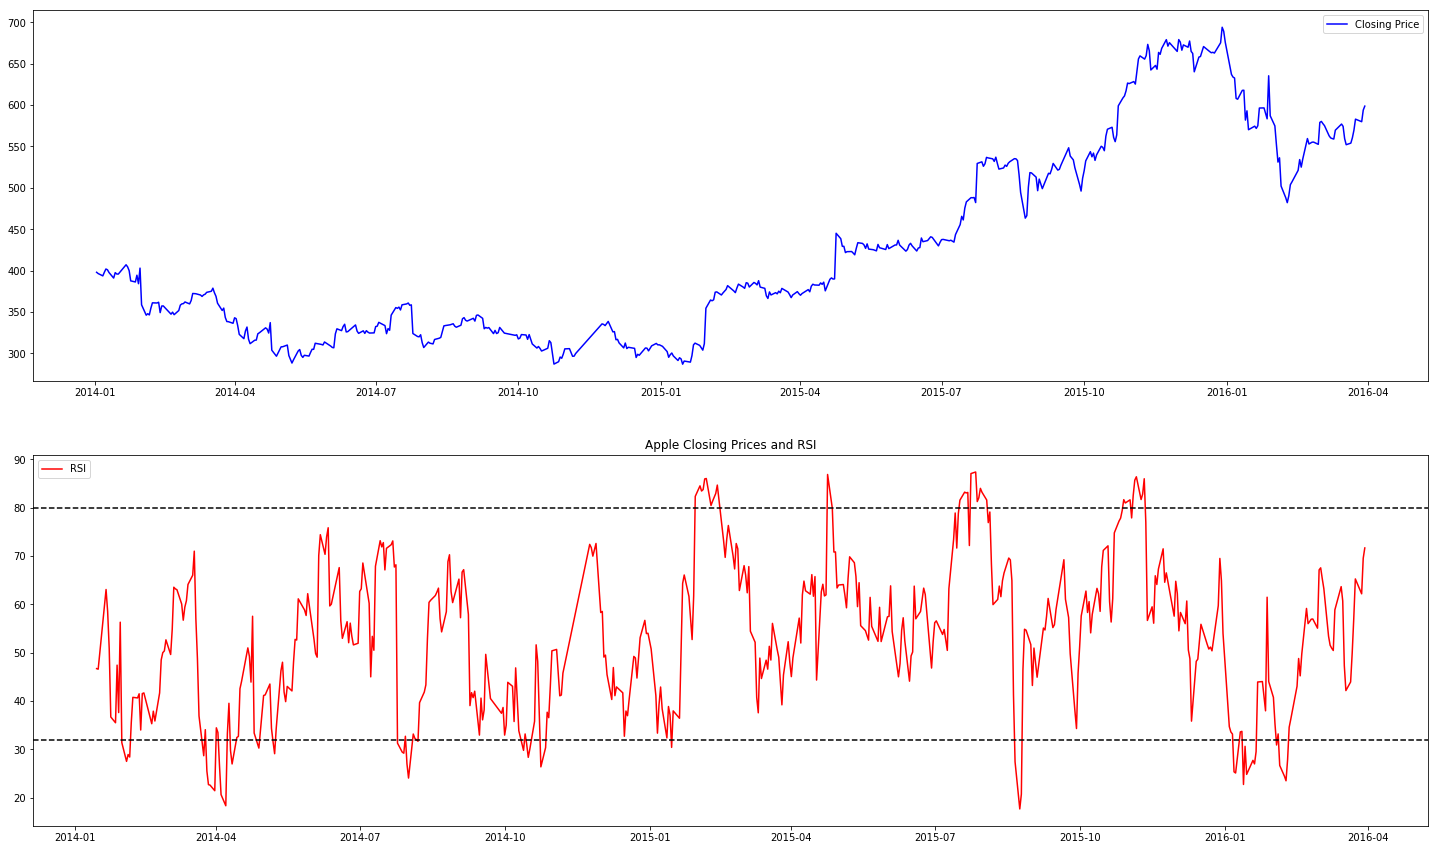

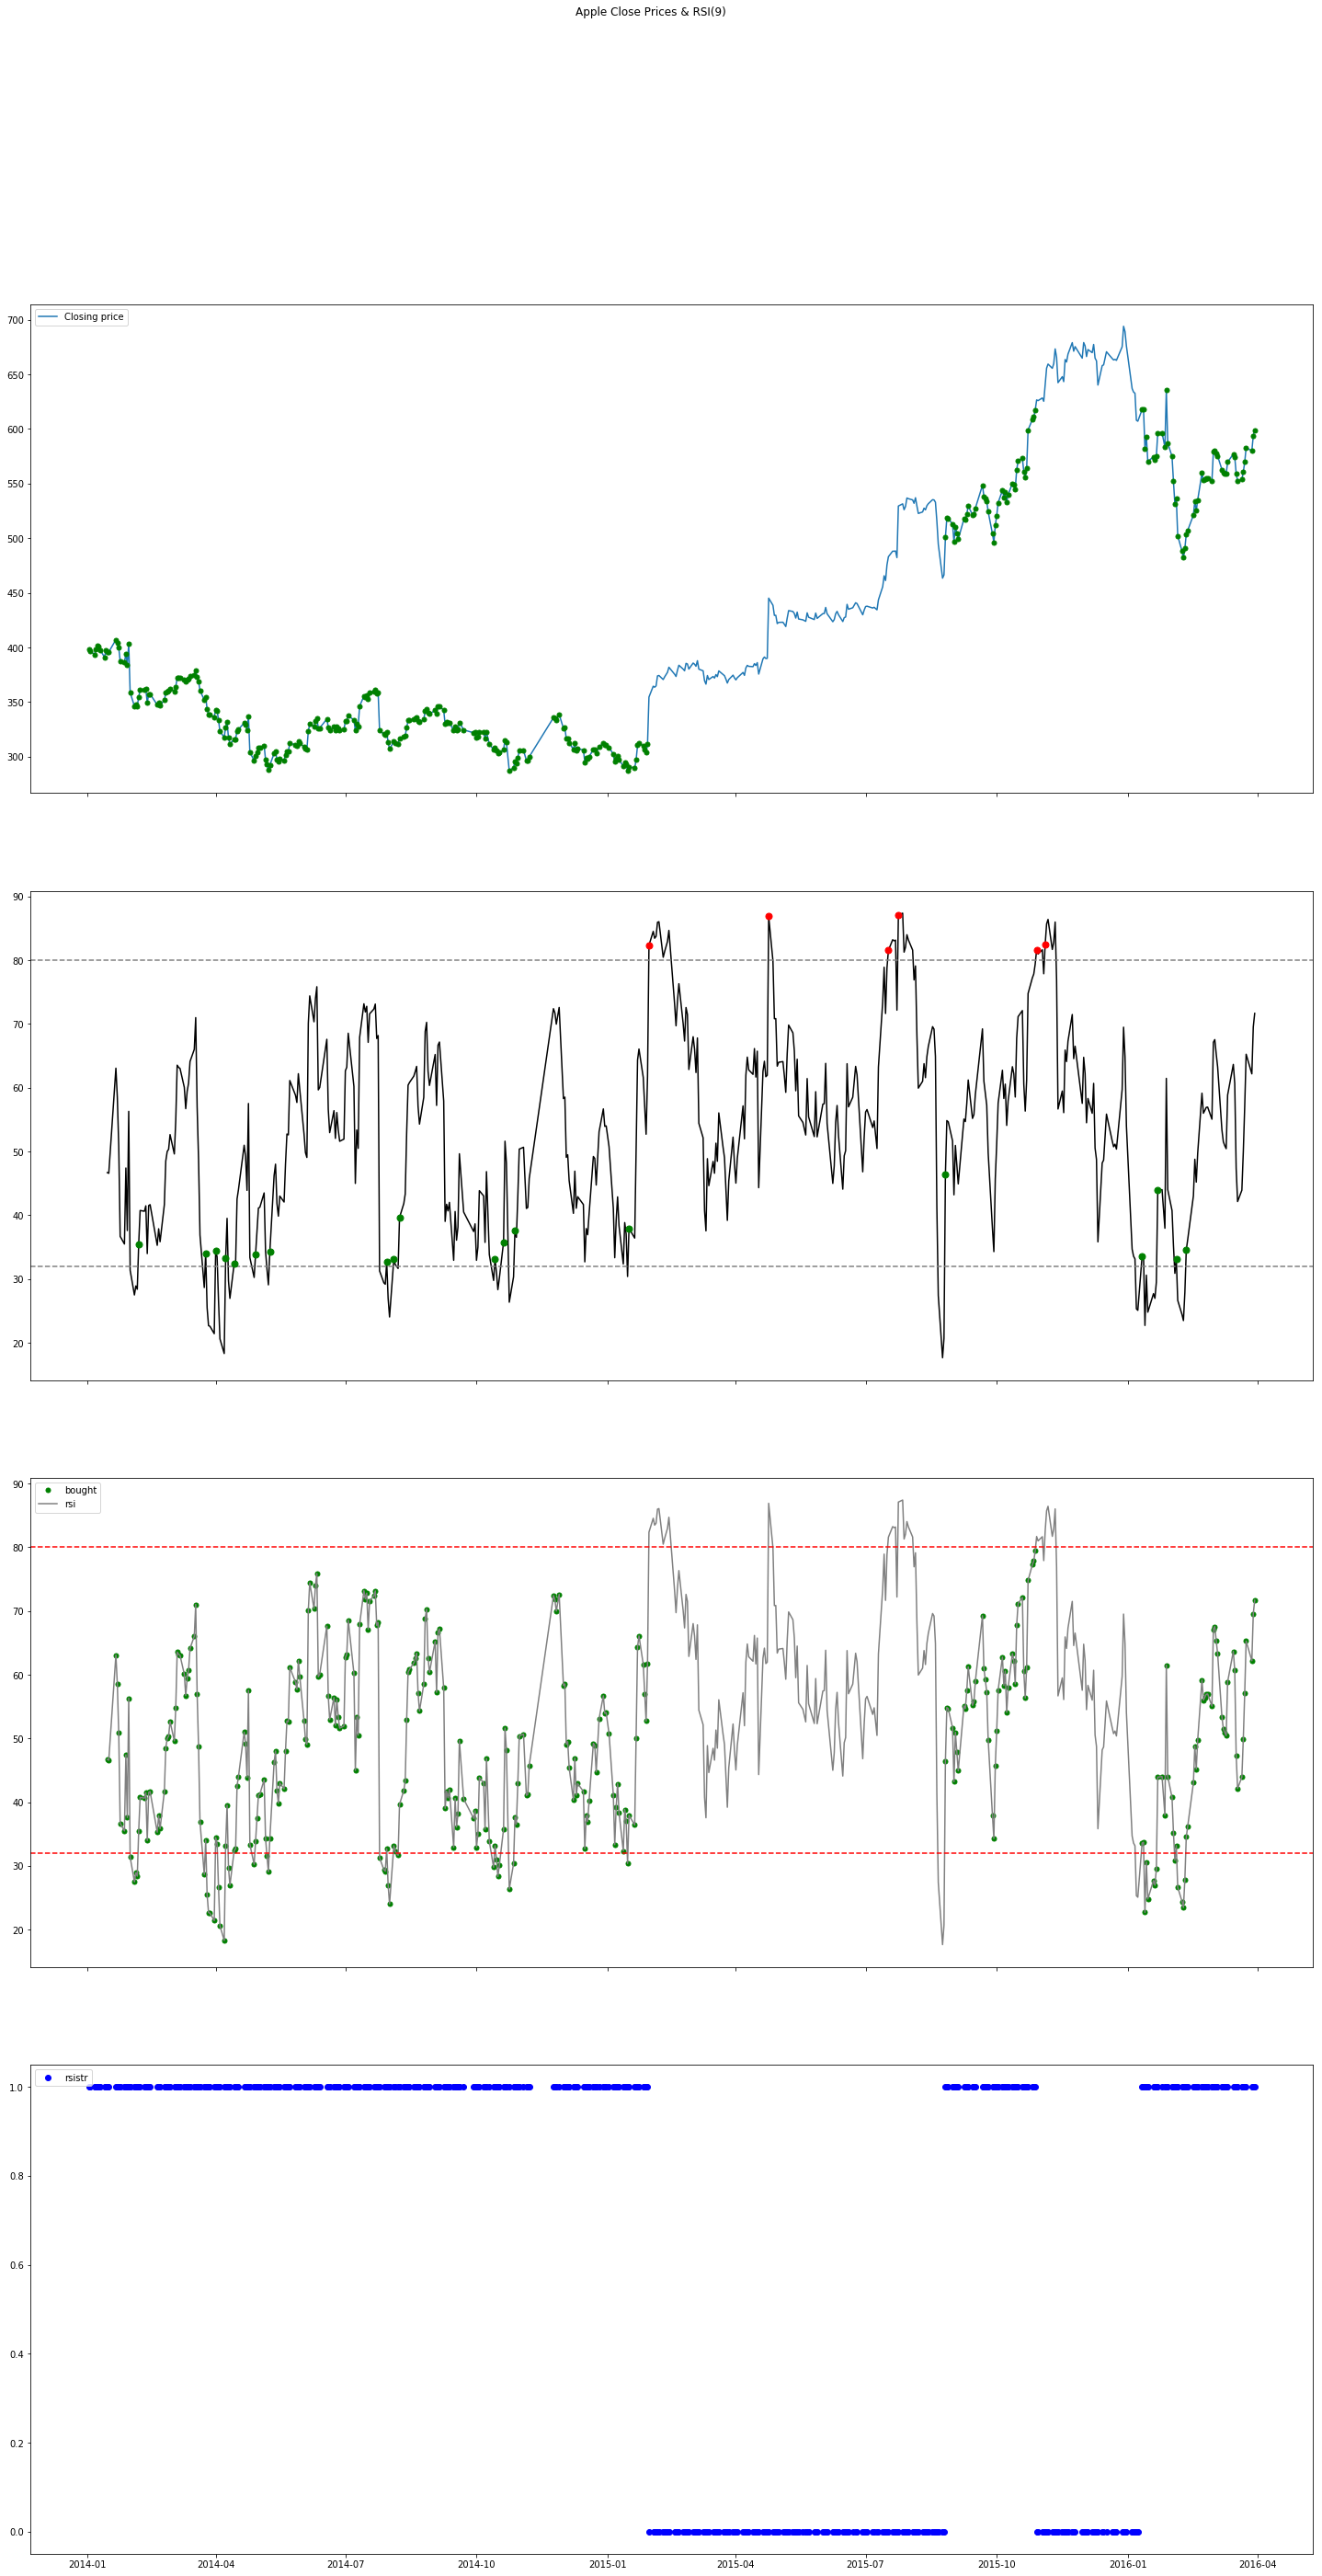

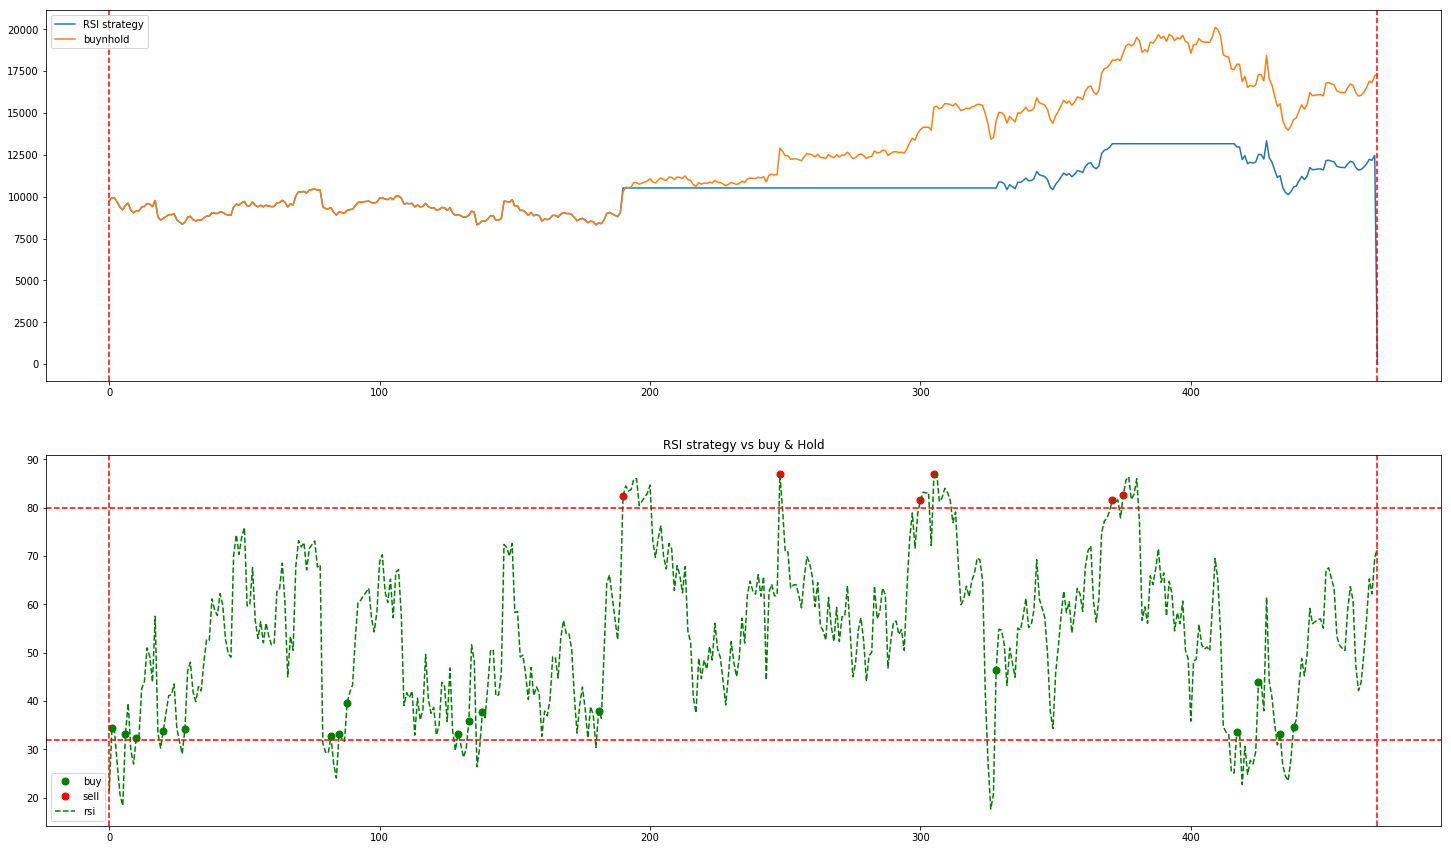

investing 10,000 pounds initially


0                 1              2             3  \
0                 Inital Amount($)  Number Shares  Buy Price($)   
1   buy and hold            10,000             29        336.36   
2                                                                 
3           sma5            10,000            NaN        342.99   
4                                                                 
5           ema5            10,000            NaN        342.99   
6                                                                 
7          ema20            10,000            NaN        337.15   
8                                                                 
9             BB            10,000            NaN        336.36   
10                                                                
11           RSI            10,000            NaN        342.99   

                4                5                  6          7  \
0   Sell Price($)  Price change($)  capital return($)  Profit($)   
1          598.69           262.33              17362    7362.01   
2                                                                  
3          593.86           250.87             8907.9    -1092.1   
4                                                                  
5          593.86           250.87            10689.5     689.48   
6                                                                  
7          593.86           256.71            11877.2     1877.2   
8                                                                  
9          635.35           298.99            14525.7     4525.7   
10                                                                 
11         593.86           250.87            12471.1    2471.06   

                  8                     9  
0   Total Return(%)  Annualised Return(%)  
1             73.62                 27.47  
2                                          
3            -10.92                   NaN  
4                                          
5              6.89                  3.97  
6                                          
7             18.77                  9.15  
8                                          
9             45.26                 18.64  
10                                         
11            24.71                 11.45

In [9]:
rsi_df = ticker_df.copy()

# set date as index now that we have merged all the data
rsi_df = rsi_df.set_index('Date')

#Add moving averages SMA
rsi_df['rsi']=ta.RSI(np.asarray(rsi_df['Adj. Close']), timeperiod=9)

#PLot chart
fig1, ax = plt.subplots(2, figsize=(25, 15))


ax[0].plot(rsi_df['Adj. Close'], color='blue', label='Closing Price')
ax[0].legend(loc='best')

#rsi
ax[1].plot(rsi_df['rsi'], color='red', label='RSI')
ax[1].axhline(y=80, ls='--', color ='black')
ax[1].axhline(y=32, ls='--', color ='black')


plt.title('Apple Closing Prices and RSI')
plt.legend(loc='upper left')
plt.show()

#***********

rsi_df.columns, rsi_df.shape

#Create training Signals with SMA5
#Initialise column
rsi_df['rsisig'] = 0

#test this against one day lag
rsisig = 0
rsi_df['Adj. Close(-1)'] = rsi_df['Adj. Close'].shift(1)
rsi_df['rsi(-1)'] = rsi_df['rsi'].shift(1)
#%%

# Generate Trading Signals (buy=1 , sell=-1, do nothing=0)
for i, row in enumerate(rsi_df.iterrows()):
    if row[1]['rsi(-1)'] < 32 and row[1]['rsi'] > 32:
        rsisig = 1
    elif row[1]['rsi(-1)'] < 80 and row[1]['rsi'] > 80:
        rsisig = -1
    else:
        rsisig = 0
    rsi_df.iloc[i, 12] = rsisig
    

rsi_df['rsistr'] = 1 # initially own the stock
rsistr = 0 # initialise all as 0

for i, row in enumerate(rsi_df.iterrows()):
    if row[1]['rsisig'] == 1:
        rsistr = 1
    elif row[1]['rsisig'] == -1:
        rsistr = 0
    else:
        rsistr = rsi_df['rsistr'][i-1]
    rsi_df.iloc[i, 15] = rsistr

#next we create strategy chart

fig, ax = plt.subplots(4, sharex=True, figsize=(25, 45))

ax[0].plot(rsi_df['Adj. Close'], label='Closing price')
ax[0].legend(loc='upper left')

# Plot the buy signals
ax[0].plot(rsi_df.loc[rsi_df['rsistr'] == 1.0].index, 
         rsi_df['Adj. Close'][rsi_df['rsistr'] == 1.0],
         'o', markersize=5, color='g', label='buy')
         
# Plot the sell signals
ax[0].plot(rsi_df.loc[rsi_df['rsistr'] == -1.0].index, 
         rsi_df['Adj. Close'][rsi_df['rsistr'] == -1.0],
         'o', markersize=5, color='r', label='sell')

ax[1].plot(rsi_df['rsi'], color='black', label='RSI')
ax[1].axhline(y=80, ls='--', color ='grey')
ax[1].axhline(y=32, ls='--', color ='grey')


# Plot the buy signals
ax[1].plot(rsi_df.loc[rsi_df['rsisig'] == 1.0].index, 
         rsi_df['rsi'][rsi_df['rsisig'] == 1.0],
         'o', markersize=7, color='g', label='buy')
         
# Plot the sell signals
ax[1].plot(rsi_df.loc[rsi_df['rsisig'] == -1.0].index, 
         rsi_df['rsi'][rsi_df['rsisig'] == -1.0],
         'o', markersize=7, color='r', label='sell')

# Plot the buy signals
ax[2].plot(rsi_df.loc[rsi_df['rsistr'] == 1.0].index, 
         rsi_df['rsi'][rsi_df['rsistr'] == 1.0],
         'o', markersize=5, color='g', label='bought')
         
# Plot the sell signals
ax[2].plot(rsi_df.loc[rsi_df['rsistr'] == -1.0].index, 
         rsi_df['rsi'][rsi_df['rsistr'] == -1.0],
         'o', markersize=5, color='r', label='')

ax[2].plot(rsi_df['rsi'], color='grey', label='rsi')
ax[2].legend(loc='upper left')



ax[2].axhline(y=80, ls='--', color ='red')
ax[2].axhline(y=32, ls='--', color ='red')

ax[3].plot(rsi_df['rsistr'], marker='o', linestyle='', color='blue', label='rsistr')
ax[3].legend(loc='upper left')

plt.suptitle('Apple Close Prices & RSI(9)')
plt.show()



#ema_df.set_index('Date', inplace=True)
rsi_df = rsi_df['2014-03-31' : '2016-03-31']
rsi_df = rsi_df.reset_index()



# Teesting against invested funds
investment = 10000
rsi_df['capital']= investment
rsi_df['invested'] = 0
rsi_df['price'] = rsi_df['Adj. Close']
rsi_df['pnl'] = 0 # initially own the stock
rsi_df['shares'] = int(investment / rsi_df['Adj. Close'][0])
rsi_df['buynhold'] = rsi_df['shares'] * rsi_df['Adj. Close']


rsi_df['capital'] = rsi_df['capital'].astype('float64') 
rsi_df['invested'] = rsi_df['invested'].astype('float64')
rsi_df['pnl'] = rsi_df['pnl'].astype('float64')
rsi_df['shares'] = rsi_df['shares'].astype('float64')
rsi_df['buynhold'] = rsi_df['buynhold'].astype('float64')

rsi_df = rsi_df.round(2)


for i in range(0,len(rsi_df)-1):
  
  get_price = rsi_df['Adj. Close'].iloc[i]

  inital = 0 
  buy_price=0
  difference_price=0
  sell_price=0
  next_date = rsi_df.Date.iloc[i+1]
  capital_1 = rsi_df['capital'].iloc[i-1]
  capital = rsi_df['capital'].iloc[i]
  nominal = rsi_df['pnl'].iloc[i]-1
  capital_invested = rsi_df['Adj. Close'].iloc[i]
  invested_shares = int(rsi_df['capital'].iloc[i-1] / get_price)
  #pnl = invested_shares * get_price

  get_pnl = rsi_df['pnl'].iloc[i-1]
  rsi = rsi_df['rsi'].iloc[i]
  rsistr = rsi_df['rsistr'].iloc[i]
  rsisig = rsi_df['rsisig'].iloc[i]
  rsistr_1 = rsi_df['rsistr'].iloc[i-1]
  invested_1 = rsi_df['invested'].iloc[i-1]
  invested = rsi_df['invested'].iloc[i]
  buynhold = rsi_df['shares'].iloc[i] * get_price
  pnl_1 = rsi_df['pnl'].iloc[i-1]
  shares = rsi_df['shares'].iloc[i]
  
  
  if(rsistr) == 0 and i==0:
    #print('i=0')
    rsi_df.at[i,'capital'] = investment    
    rsi_df.at[i,'invested'] = 0       
    rsi_df.at[i,'pnl'] = 0 
    
  
  elif(rsistr) == 1 and i==0:
    #print('i=0')
    rsi_df.at[i,'invested'] = int(investment/ get_price)      
    rsi_df.at[i,'capital'] = int(initial - ((rsi_df['invested'].iloc[i] *get_price)))      
    rsi_df.at[i,'pnl'] = rsi_df['invested'].iloc[i] * get_price   
  
  elif(rsistr) == 0 and rsistr_1 == 0 and capital_1 ==investment:
    rsi_df.at[i,'invested'] = invested_1  
    rsi_df.at[i,'capital'] = capital_1
    rsi_df.at[i, 'pnl'] = 0
   
    
  elif(rsistr) == 0 and rsistr_1 == 0 and capital_1 !=investment:
    rsi_df.at[i,'invested'] = invested_1  
    rsi_df.at[i,'capital'] = capital_1
    rsi_df.at[i, 'pnl'] = pnl_1
     
 
  elif(rsistr) == 1 and rsistr_1 == 0:
    rsi_df.at[i,'invested'] = int(capital_1/ get_price)  
    rsi_df.at[i,'capital'] = int(capital_1 - ((rsi_df['invested'].iloc[i] *get_price)))
    rsi_df.at[i, 'pnl'] = rsi_df['invested'].iloc[i] * get_price
    price_buy = get_price
  
  elif(rsistr) == 0 and rsistr_1 == 1 and capital_1 !=investment:
    #print('i=0')
    differece_price = (get_price - price_buy) 
    rsi_df.at[i,'capital'] = capital_1 + (invested_1 * get_price) + (difference_price * invested_1)    
    rsi_df.at[i,'invested'] = 0       
    rsi_df.at[i,'pnl'] = rsi_df['capital'].iloc[i]
    
    
  else:
    rsi_df.at[i,'capital'] = capital_1    
    rsi_df.at[i,'invested'] = invested_1       
    rsi_df.at[i,'pnl'] = rsi_df['invested'].iloc[i] * get_price
    
rsi_df = rsi_df[['Date', 'Adj. Close', 'Comp', 'rsi', 'rsisig', 'rsistr', 'capital', 'invested', 'pnl', 'shares', 'buynhold']]


endYr2 = rsi_df.index[-1]
#slide dataframe for 2 years

# pnl Returns Chart
fig, ax = plt.subplots(2, figsize=(25, 15))

ax[0].plot(rsi_df['pnl'], label = 'RSI strategy' )
ax[0].plot(rsi_df['buynhold'], label = 'buynhold')

ax[0].axvline(0, color='r', ls='--')
ax[0].axvline(rsi_df.index[-1], color='r', ls='--')

ax[0].legend(loc='upper left')

# Plot the buy signals

# Plot the buy signals
ax[1].plot(rsi_df.loc[rsi_df['rsisig'] == 1.0].index, 
         rsi_df['rsi'][rsi_df['rsisig'] == 1.0],
         'o', markersize=7, color='g', label='buy')
         
# Plot the sell signals
ax[1].plot(rsi_df.loc[rsi_df['rsisig'] == -1.0].index, 
         rsi_df['rsi'][rsi_df['rsisig'] == -1.0],
         'o', markersize=7, color='r', label='sell')

#Add RSI
ax[1].plot(rsi_df['rsi'], color='green', ls='--', label='rsi')
ax[1].axhline(y=80, ls='--', color ='red')
ax[1].axhline(y=32, ls='--', color ='red')

ax[1].axvline(0, color='r', ls='--')
ax[1].axvline(rsi_df.index[-1], color='r', ls='--')

ax[1].legend(loc='upper left')

plt.title('RSI strategy vs buy & Hold')
plt.legend()
plt.show()


#******

rsiBuyIndexyr1=1
rsiSellIndexyr2=468

rsiBuyPrice_yr1 = rsi_df['Adj. Close'].iloc[rsiBuyIndexyr1]
rsiSellPrice_yr2 = rsi_df['Adj. Close'].iloc[rsiSellIndexyr2]

rsishares_invested = int(initial / rsiBuyPrice_yr1)

rsiPrice_change = (rsiSellPrice_yr2 - rsiBuyPrice_yr1)

rsicapital_return_yr2 = rsi_df['pnl'][rsiSellIndexyr2]

rsiProfit_yr2 = (rsicapital_return_yr2 - initial).round(2)

rsiReturn_yr2 = ((rsiProfit_yr2/initial)*100).round(2)

def annualisedRSI():
  if (len(rsi_df) > 365):
    rsi_df_return = ((1 + rsiReturn_yr2)**(365/len(rsi_df))-1).round(2)
  else:
    rsi_df_return = 0
    
  return rsi_df_return


print('investing 10,000 pounds initially')

# Summary Results Data Table
rsi_data = [{'0': '', '1': 'Inital Amount($)', '2': 'Number Shares', '3': 'Buy Price($)', '4': 'Sell Price($)', '5': 'Price change($)', '6': 'capital return($)', '7': 'Profit($)', '8': 'Total Return(%)', '9': 'Annualised Return(%)'},
        {'0': 'buy and hold', '1': '10,000', '2': bhshares_invested, '3': bhBuyPrice_yr1, '4': bhSellPrice_yr2, '5': bhPrice_change_yr2,  '6': bhcapitalReturnyr2, '7': bhProfit_yr2, '8': bhReturn_yr2, '9': annualised()},  
         
        {'0': '', '1':'' , '2': '', '3': '', '4': '', '5': '', '6': '', '7': '', '8': '', '9': ''},
        
        {'0': 'sma5', '1': '10,000', '2': 'NaN', '3': sma5BuyPrice_yr1, '4': sma5SellPrice_yr2, '5': sma5Price_change_yr2,  '6': sma5capital_return_yr2, '7': sma5Profit_yr2, '8': sma5Return_yr2, '9': annualisedSma()},

            
             {'0': '', '1':'' , '2': '', '3': '', '4': '', '5': '', '6': '', '7': '', '8': '', '9': ''},
        
        {'0': 'ema5', '1': '10,000', '2': 'NaN', '3': ema5BuyPrice_yr1, '4': ema5SellPrice_yr2, '5': ema5Price_change_yr2,  '6': ema5capital_return_yr2, '7': ema5Profit_yr2, '8': ema5Return_yr2, '9': annualisedEma()},
    

            {'0': '', '1':'' , '2': '', '3': '', '4': '', '5': '', '6': '', '7': '', '8': '',  '9': ''},
        
        {'0': 'ema20', '1': '10,000', '2': 'NaN', '3': ema20BuyPrice_yr1, '4': ema20SellPrice_yr2, '5': ema20Price_change,  '6': ema20capital_return, '7': ema20Profit, '8': ema20Return, '9': annualisedEma20()},
         
              {'0': '', '1':'' , '2': '', '3': '', '4': '', '5': '', '6': '', '7': '', '8': '', '9': ''},
        
        {'0': 'BB', '1': '10,000', '2': 'NaN', '3': bollBuyPrice_yr1, '4': bollSellPrice_yr2, '5': bollPrice_change,  '6': bollcapital_return, '7': bollProfit, '8': bollReturn, '9': annualisedBoll()},   

            {'0': '', '1':'' , '2': '', '3': '', '4': '', '5': '', '6': '', '7': '', '8': '', '9': ''},
        
        {'0': 'RSI', '1': '10,000', '2': 'NaN', '3': rsiBuyPrice_yr1, '4': rsiSellPrice_yr2, '5': rsiPrice_change,  '6': rsicapital_return_yr2, '7': rsiProfit_yr2, '8': rsiReturn_yr2, '9': annualisedRSI()}]
  

table = pd.DataFrame(rsi_data)

table

#******




# Technical Analysis - EMA5 & 20 

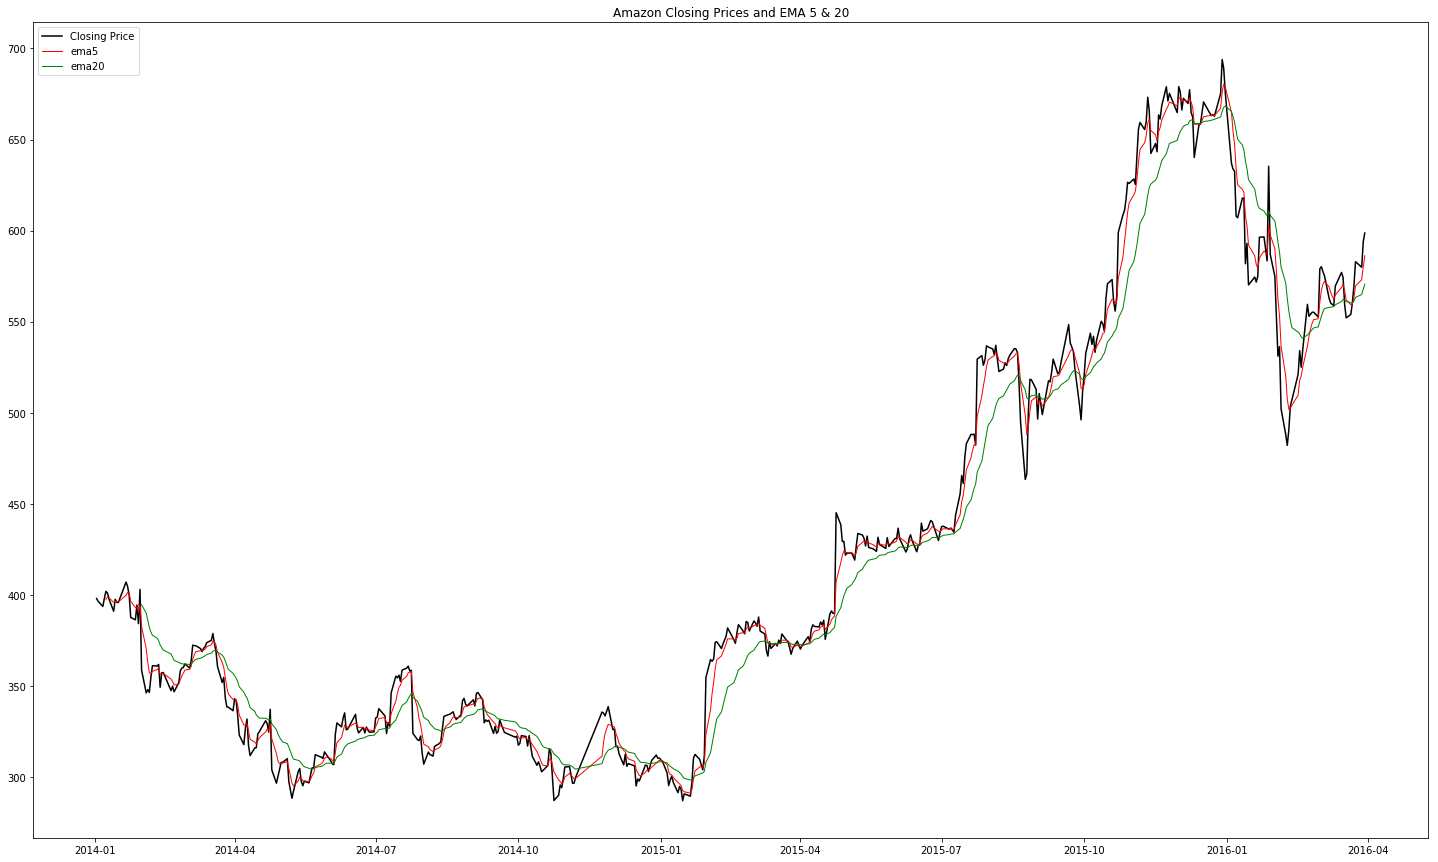

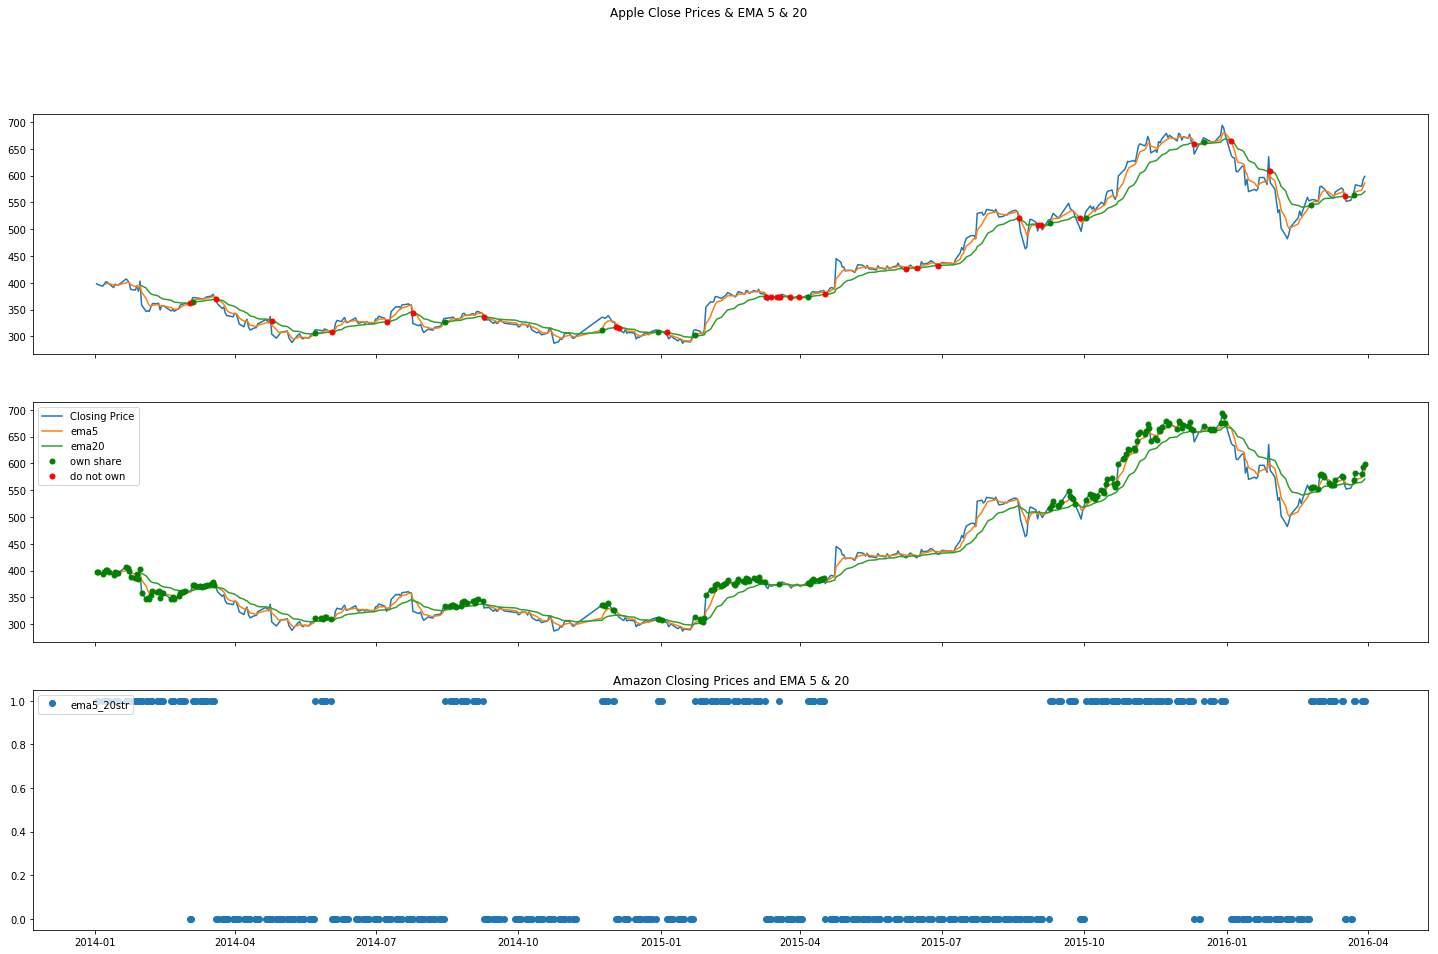

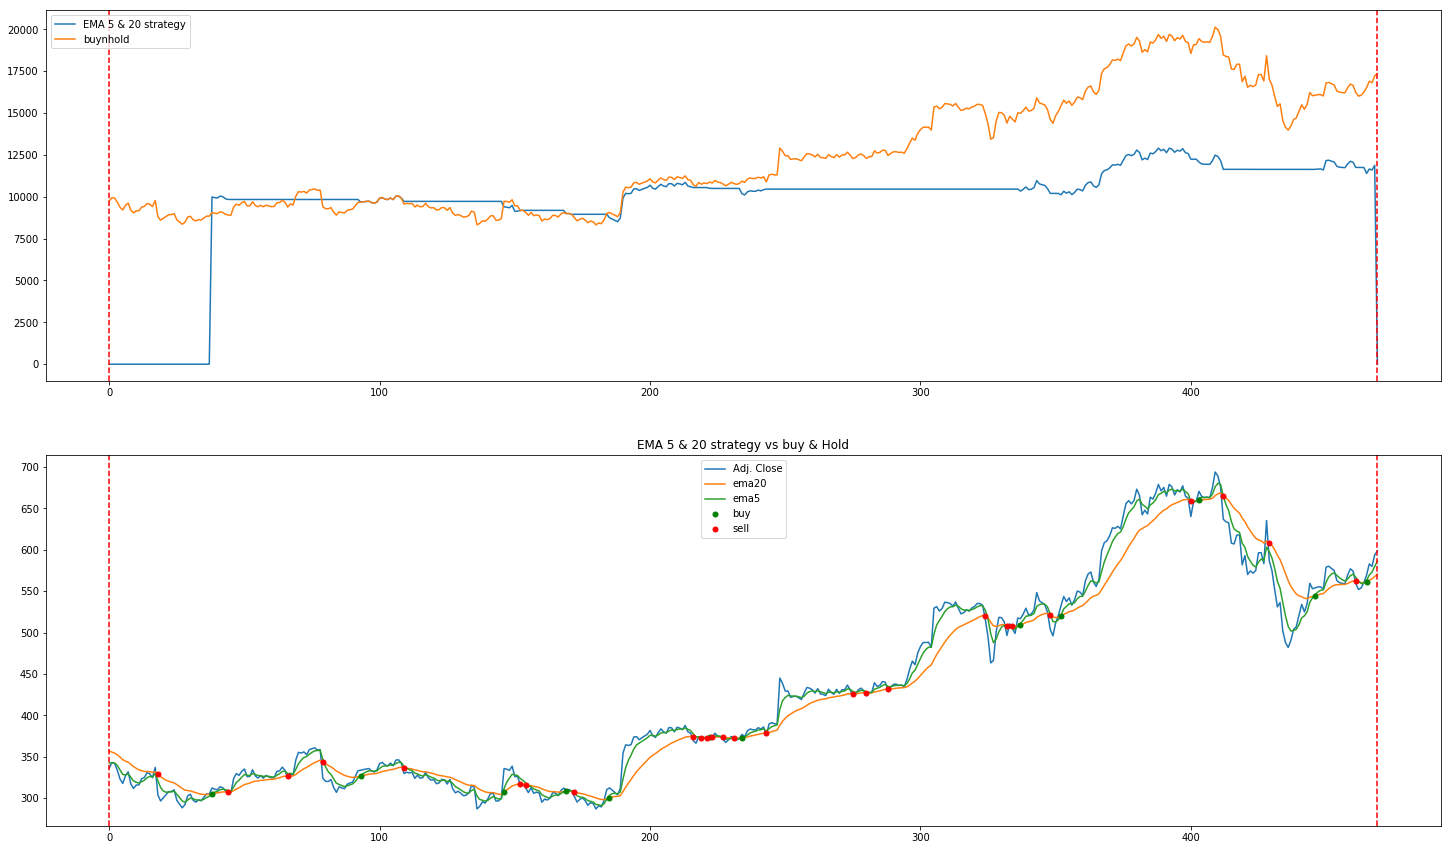

investing 10,000 pounds initially


0                 1              2             3  \
0                 Inital Amount($)  Number Shares  Buy Price($)   
1   buy and hold            10,000             29        336.36   
2                                                                 
3           sma5            10,000            NaN        342.99   
4                                                                 
5           ema5            10,000            NaN        342.99   
6                                                                 
7          ema20            10,000            NaN        337.15   
8                                                                 
9             BB            10,000            NaN        336.36   
10                                                                
11           RSI            10,000            NaN        342.99   
12                                                                
13       ema5_20            10,000            NaN        312.24   

                4                5                  6          7  \
0   Sell Price($)  Price change($)  capital return($)  Profit($)   
1          598.69           262.33              17362    7362.01   
2                                                                  
3          593.86           250.87             8907.9    -1092.1   
4                                                                  
5          593.86           250.87            10689.5     689.48   
6                                                                  
7          593.86           256.71            11877.2     1877.2   
8                                                                  
9          635.35           298.99            14525.7     4525.7   
10                                                                 
11         593.86           250.87            12471.1    2471.06   
12                                                                 
13         593.86           281.62            11877.2     1877.2   

                  8                     9  
0   Total Return(%)  Annualised Return(%)  
1             73.62                 27.47  
2                                          
3            -10.92                 27.47  
4                                          
5              6.89                  3.97  
6                                          
7             18.77                  9.15  
8                                          
9             45.26                 18.64  
10                                         
11            24.71                 11.45  
12                                         
13            18.77                  9.15

In [10]:
ema5_20_df = ticker_df.copy()
# set date as index now that we have merged all the data
ema5_20_df = ema5_20_df.set_index('Date')

#Add moving averages SMA
ema5_20_df['ema5'] = ta.EMA(np.asarray(ema5_20_df['Adj. Close']), 5)
ema5_20_df['ema20'] = ta.EMA(np.asarray(ema5_20_df['Adj. Close']), 20)
#aapletweet['sma100'] = ta.SMA(np.asarray(aapletweet['Adj. Close']), 100)

#PLot chart
fig1, ax = plt.subplots(figsize=(25, 15))


ax.plot(ema5_20_df['Adj. Close'], color='black', label='Closing Price')

#5 day Moving Average
ax.plot(ema5_20_df['ema5'], lw=1., color='red', label='ema5')

#20 day Moving Average
ax.plot(ema5_20_df['ema20'], lw=1., color='green', label='ema20')

plt.title('{} Closing Prices and EMA 5 & 20'.format(ticker_name))
plt.legend(loc='upper left')
plt.show()

#*******

#Create training Signals with SMA5
#Initialise column
ema5_20_df['ema5_20sig'] = 0

#test this against one day lag
ema5_20sig = 0

ema5_20_df['Adj. Close(-1)'] = ema5_20_df['Adj. Close'].shift(1)
ema5_20_df['ema20(-1)'] = ema5_20_df['ema20'].shift(1)
ema5_20_df['ema5(-1)'] = ema5_20_df['ema5'].shift(1)

# Generate Trading Signals (buy=1 , sell=-1, do nothing=0)
for i, row in enumerate(ema5_20_df.iterrows()):
    if row[1]['ema5(-1)'] < row[1]['ema20(-1)']  and row[1]['ema5'] > row[1]['ema20']:
       ema5_20sig = 1
    elif row[1]['Adj. Close(-1)'] >  row[1]['ema20(-1)']  and row[1]['Adj. Close'] < row[1]['ema20']:
        ema5_20sig = -1
    else:
        ema5_20sig = 0
    ema5_20_df.iloc[i, 13] = ema5_20sig




ema5_20_df['ema5_20str'] = 1 # initially own the stock

ema5_20str = 0 # initialise all as 0

for i, row in enumerate(ema5_20_df.iterrows()):
    if row[1]['ema5_20sig'] == 1:
        ema5_20str = 1 #own the stock
    elif row[1]['ema5_20sig'] == -1:
        ema5_20str = 0 #don't own the stock
    else:
        ema5_20str = ema5_20_df['ema5_20str'][i-1] # if dont have either of above, just  repeat previous period trading strategy
    ema5_20_df.iloc[i, 17] = ema5_20str # continue to update
    
    
#next we create strategy chart

fig, ax = plt.subplots(3, sharex=True, figsize=(25,15))

plt.title('{} Closing Prices and EMA 5 & 20'.format(ticker_name))
ax[0].plot(ema5_20_df['Adj. Close'], label='Adj. Close')
ax[0].plot(ema5_20_df['ema5'], label='ema5')
ax[0].plot(ema5_20_df['ema20'], label='ema20')

# Plot the buy signals
ax[0].plot(ema5_20_df.loc[ema5_20_df['ema5_20sig'] == 1.0].index, 
         ema5_20_df.ema5[ema5_20_df['ema5_20sig'] == 1.0],
         'o', markersize=5, color='g', label='buy')
         
# Plot the sell signals
ax[0].plot(ema5_20_df.loc[ema5_20_df['ema5_20sig'] == -1.0].index, 
         ema5_20_df.ema20[ema5_20_df['ema5_20sig'] == -1.0],
         'o', markersize=5, color='r', label='sell')

ax[1].plot(ema5_20_df['Adj. Close'], label='Closing Price')
ax[1].plot(ema5_20_df['ema5'], label='ema5')
ax[1].plot(ema5_20_df['ema20'], label='ema20')
ax[1].legend(loc='upper left')

# Plot the buy signals
ax[1].plot(ema5_20_df.loc[ema5_20_df['ema5_20str'] == 1.0].index, 
         ema5_20_df['Adj. Close'][ema5_20_df['ema5_20str'] == 1.0],
         'o', markersize=5, color='g', label='own share')
         
# Plot the sell signals
ax[1].plot(ema5_20_df.loc[ema5_20_df['ema5_20str'] == -1.0].index, 
         ema5_20_df['Adj. Close'][ema5_20_df['ema5_20str'] == -1.0],
         'o', markersize=5, color='r', label='do not own')

ax[1].legend(loc='best')


ax[2].plot(ema5_20_df['ema5_20str'], marker='o', linestyle='', label='ema5_20str')
ax[2].legend(loc='upper left')
plt.suptitle('Apple Close Prices & EMA 5 & 20')
plt.show()    

#******

#Finally for strategy performance metrics

#ema_df.set_index('Date', inplace=True)
ema5_20_df = ema5_20_df['2014-03-31' : '2016-03-31']
ema5_20_df = ema5_20_df.reset_index()

# Teesting against invested funds
investment = 10000
ema5_20_df['capital']= investment
ema5_20_df['invested'] = 0
ema5_20_df['price'] = ema5_20_df['Adj. Close']
ema5_20_df['pnl'] = 0 # initially own the stock
ema5_20_df['shares'] = int(investment / ema5_20_df['Adj. Close'][0])
ema5_20_df['buynhold'] = ema5_20_df['shares'] * ema5_20_df['Adj. Close']


ema5_20_df['capital'] = ema5_20_df['capital'].astype('float64') 
ema5_20_df['invested'] = ema5_20_df['invested'].astype('float64')
ema5_20_df['pnl'] = ema5_20_df['pnl'].astype('float64')
ema5_20_df['shares'] = ema5_20_df['shares'].astype('float64')
ema5_20_df['buynhold'] = ema5_20_df['buynhold'].astype('float64')

ema5_20_df = ema5_20_df.round(2)


for i in range(0,len(ema5_20_df)-1):
  
  get_price = ema5_20_df['Adj. Close'].iloc[i]

  inital = 0 
  buy_price=0
  difference_price=0
  sell_price=0
  next_date = ema5_20_df.Date.iloc[i+1]
  capital_1 = ema5_20_df['capital'].iloc[i-1]
  capital = ema5_20_df['capital'].iloc[i]
  nominal = ema5_20_df['pnl'].iloc[i]-1
  capital_invested = ema5_20_df['Adj. Close'].iloc[i]
  invested_shares = int(ema5_20_df['capital'].iloc[i-1] / get_price)
  #pnl = invested_shares * get_price

  get_pnl = ema5_20_df['pnl'].iloc[i-1]
  ema5 = ema5_20_df['ema5'].iloc[i]
  ema20 = ema5_20_df['ema20'].iloc[i]
  ema5_20str = ema5_20_df['ema5_20str'].iloc[i]
  ema5_20sig = ema5_20_df['ema5_20sig'].iloc[i]
  ema5_20str_1 = ema5_20_df['ema5_20str'].iloc[i-1]
  invested_1 = ema5_20_df['invested'].iloc[i-1]
  invested = ema5_20_df['invested'].iloc[i]
  buynhold = ema5_20_df['shares'].iloc[i] * get_price
  pnl_1 = ema5_20_df['pnl'].iloc[i-1]
  shares = ema5_20_df['shares'].iloc[i]
  
  
  if(ema5_20str) == 0 and i==0:
    #print('i=0')
    ema5_20_df.at[i,'capital'] = investment    
    ema5_20_df.at[i,'invested'] = 0       
    ema5_20_df.at[i,'pnl'] = 0 
    
  
  elif(ema5_20str) == 1 and i==0:
    #print('i=0')
    ema5_20_df.at[i,'invested'] = int(investment/ get_price)      
    ema5_20_df.at[i,'capital'] = int(initial - ((ema5_20_df['invested'].iloc[i] *get_price)))      
    ema5_20_df.at[i,'pnl'] = ema5_20_df['invested'].iloc[i] * get_price   
  
  elif(ema5_20str) == 0 and ema5_20str_1 == 0 and capital_1 ==investment:
    ema5_20_df.at[i,'invested'] = invested_1  
    ema5_20_df.at[i,'capital'] = capital_1
    ema5_20_df.at[i, 'pnl'] = 0
   
  elif(ema5_20str) == 0 and ema5_20str_1 == 0 and capital_1 !=investment:
    ema5_20_df.at[i,'invested'] = invested_1  
    ema5_20_df.at[i,'capital'] = capital_1
    ema5_20_df.at[i, 'pnl'] = pnl_1
     
  elif(ema5_20str) == 1 and ema5_20str_1 == 0:
    ema5_20_df.at[i,'invested'] = int(capital_1/ get_price)  
    ema5_20_df.at[i,'capital'] = int(capital_1 - ((ema5_20_df['invested'].iloc[i] *get_price)))
    ema5_20_df.at[i, 'pnl'] = ema5_20_df['invested'].iloc[i] * get_price
    price_buy = get_price
  
  elif(ema5_20str) == 0 and ema5_20str_1 == 1 and capital_1 !=investment:
    #print('i=0')
    differece_price = (get_price - price_buy) 
    ema5_20_df.at[i,'capital'] = capital_1 + (invested_1 * get_price) + (difference_price * invested_1)    
    ema5_20_df.at[i,'invested'] = 0       
    ema5_20_df.at[i,'pnl'] = ema5_20_df['capital'].iloc[i]
    
    
  else: 
    ema5_20_df.at[i,'capital'] = capital_1    
    ema5_20_df.at[i,'invested'] = invested_1       
    ema5_20_df.at[i,'pnl'] = ema5_20_df['invested'].iloc[i] * get_price
    
ema5_20_df = ema5_20_df[['Date', 'Adj. Close', 'Comp', 'ema5', 'ema20', 'ema5_20sig', 'ema5_20str', 'capital', 'invested', 'pnl', 'shares', 'buynhold']]
endYr2 = ema5_20_df.index[-1]
#slide dataframe for 2 years

# pnl Returns Chart
fig, ax = plt.subplots(2, figsize=(25, 15))

ax[0].plot(ema5_20_df['pnl'], label = 'EMA 5 & 20 strategy' )
ax[0].plot(ema5_20_df['buynhold'], label = 'buynhold')

ax[0].axvline(0, color='r', ls='--')
ax[0].axvline(ema5_20_df.index[-1], color='r', ls='--')

#sma_df.loc[(sma_df['Date'].dt.month==12) & (sma_df['Date'].dt.day==31) & (sma_df['Date'].dt.year==2014), 'Adj. Close']


ax[0].legend(loc='upper left')

# Plot the buy signals
ax[1].plot(ema5_20_df['Adj. Close'], label='Adj. Close')
ax[1].plot(ema5_20_df['ema20'], label='ema20')
ax[1].plot(ema5_20_df['ema5'], label='ema5')

ax[1].plot(ema5_20_df.loc[ema5_20_df['ema5_20sig'] == 1.0].index, 
         ema5_20_df.ema20[ema5_20_df['ema5_20sig'] == 1.0],
         'o', markersize=5, color='g', label='buy')
         
# Plot the sell signals
ax[1].plot(ema5_20_df.loc[ema5_20_df['ema5_20sig'] == -1.0].index, 
         ema5_20_df.ema20[ema5_20_df['ema5_20sig'] == -1.0],
         'o', markersize=5, color='r', label='sell')

ax[1].axvline(0, color='r', ls='--')
ax[1].axvline(ema5_20_df.index[-1], color='r', ls='--')

ax[1].legend(loc='upper left')

plt.title('EMA 5 & 20 strategy vs buy & Hold')
plt.legend()
plt.show()

#*********

ema5_20buyPrice_yr_1 = ema5_20_df['Adj. Close'].iloc[0]
ema5_20sellPrice_yr_2 = ema5_20_df.loc[(ema5_20_df['Date'].dt.month==12) & (ema5_20_df['Date'].dt.day==31) & (ema5_20_df['Date'].dt.year==2015), 'Adj. Close']

ema5_20BuyIndexyr1=38
ema5_20SellIndexyr2=468

ema5_20BuyPrice_yr1 = ema5_20_df['Adj. Close'].iloc[ema5_20BuyIndexyr1]
ema5_20SellPrice_yr2 = ema5_20_df['Adj. Close'].iloc[ema5_20SellIndexyr2]

ema5_20shares_invested = int(initial / ema5_20BuyPrice_yr1)

ema5_20Price_change = (ema5_20SellPrice_yr2 - ema5_20BuyPrice_yr1)

ema5_20capital_return = ema5_20_df['pnl'].loc[ema5_20SellIndexyr2]

ema5_20Profit = ema5_20capital_return - initial

ema5_20Return = ((ema5_20Profit/initial)*100).round(2)

def annualisedEma520():
  if (len(ema5_20_df) > 365):
    ema5_20_returnAnnualised = ((1 + ema5_20Return)**(365/len(ema5_20_df))-1).round(2)
  else:
    ema5_20_returnAnnualised = 0
    
  return ema5_20_returnAnnualised

print('investing 10,000 pounds initially')

# Summary Results Data Table
ema5_20data = [{'0': '', '1': 'Inital Amount($)', '2': 'Number Shares', '3': 'Buy Price($)', '4': 'Sell Price($)', '5': 'Price change($)', '6': 'capital return($)', '7': 'Profit($)', '8': 'Total Return(%)', '9': 'Annualised Return(%)'},
        {'0': 'buy and hold', '1': '10,000', '2': bhshares_invested, '3': bhBuyPrice_yr1, '4': bhSellPrice_yr2, '5': bhPrice_change_yr2,  '6': bhcapitalReturnyr2, '7': bhProfit_yr2, '8': bhReturn_yr2, '9': annualised()},  
         
        {'0': '', '1':'' , '2': '', '3': '', '4': '', '5': '', '6': '', '7': '', '8': '', '9': ''},
        
        {'0': 'sma5', '1': '10,000', '2': 'NaN', '3': sma5BuyPrice_yr1, '4': sma5SellPrice_yr2, '5': sma5Price_change_yr2,  '6': sma5capital_return_yr2, '7': sma5Profit_yr2, '8': sma5Return_yr2, '9': annualised()},

            
             {'0': '', '1':'' , '2': '', '3': '', '4': '', '5': '', '6': '', '7': '', '8': '', '9': ''},
        
        {'0': 'ema5', '1': '10,000', '2': 'NaN', '3': ema5BuyPrice_yr1, '4': ema5SellPrice_yr2, '5': ema5Price_change_yr2,  '6': ema5capital_return_yr2, '7': ema5Profit_yr2, '8': ema5Return_yr2, '9': annualisedEma()},
    

            {'0': '', '1':'' , '2': '', '3': '', '4': '', '5': '', '6': '', '7': '', '8': '',  '9': ''},
        
        {'0': 'ema20', '1': '10,000', '2': 'NaN', '3': ema20BuyPrice_yr1, '4': ema20SellPrice_yr2, '5': ema20Price_change,  '6': ema20capital_return, '7': ema20Profit, '8': ema20Return, '9': annualisedEma20()},
         
              {'0': '', '1':'' , '2': '', '3': '', '4': '', '5': '', '6': '', '7': '', '8': '', '9': ''},
        
        {'0': 'BB', '1': '10,000', '2': 'NaN', '3': bollBuyPrice_yr1, '4': bollSellPrice_yr2, '5': bollPrice_change,  '6': bollcapital_return, '7': bollProfit, '8': bollReturn, '9': annualisedBoll()},   

            {'0': '', '1':'' , '2': '', '3': '', '4': '', '5': '', '6': '', '7': '', '8': '', '9': ''},
        
        {'0': 'RSI', '1': '10,000', '2': 'NaN', '3': rsiBuyPrice_yr1, '4': rsiSellPrice_yr2, '5': rsiPrice_change,  '6': rsicapital_return_yr2, '7': rsiProfit_yr2, '8': rsiReturn_yr2, '9': annualisedRSI()},
  

                   {'0': '', '1':'' , '2': '', '3': '', '4': '', '5': '', '6': '', '7': '', '8': '', '9': ''},
  
        
        {'0': 'ema5_20', '1': '10,000', '2': 'NaN', '3': ema5_20BuyPrice_yr1, '4': ema5_20SellPrice_yr2, '5': ema5_20Price_change,  '6': ema5_20capital_return, '7': ema5_20Profit, '8': ema5_20Return, '9': annualisedEma520()},
        ]
    
    
   
table = pd.DataFrame(ema5_20data)

table

#********



In [0]:
#*********** end*******************

# Technical Analysis - SMA5 & 20

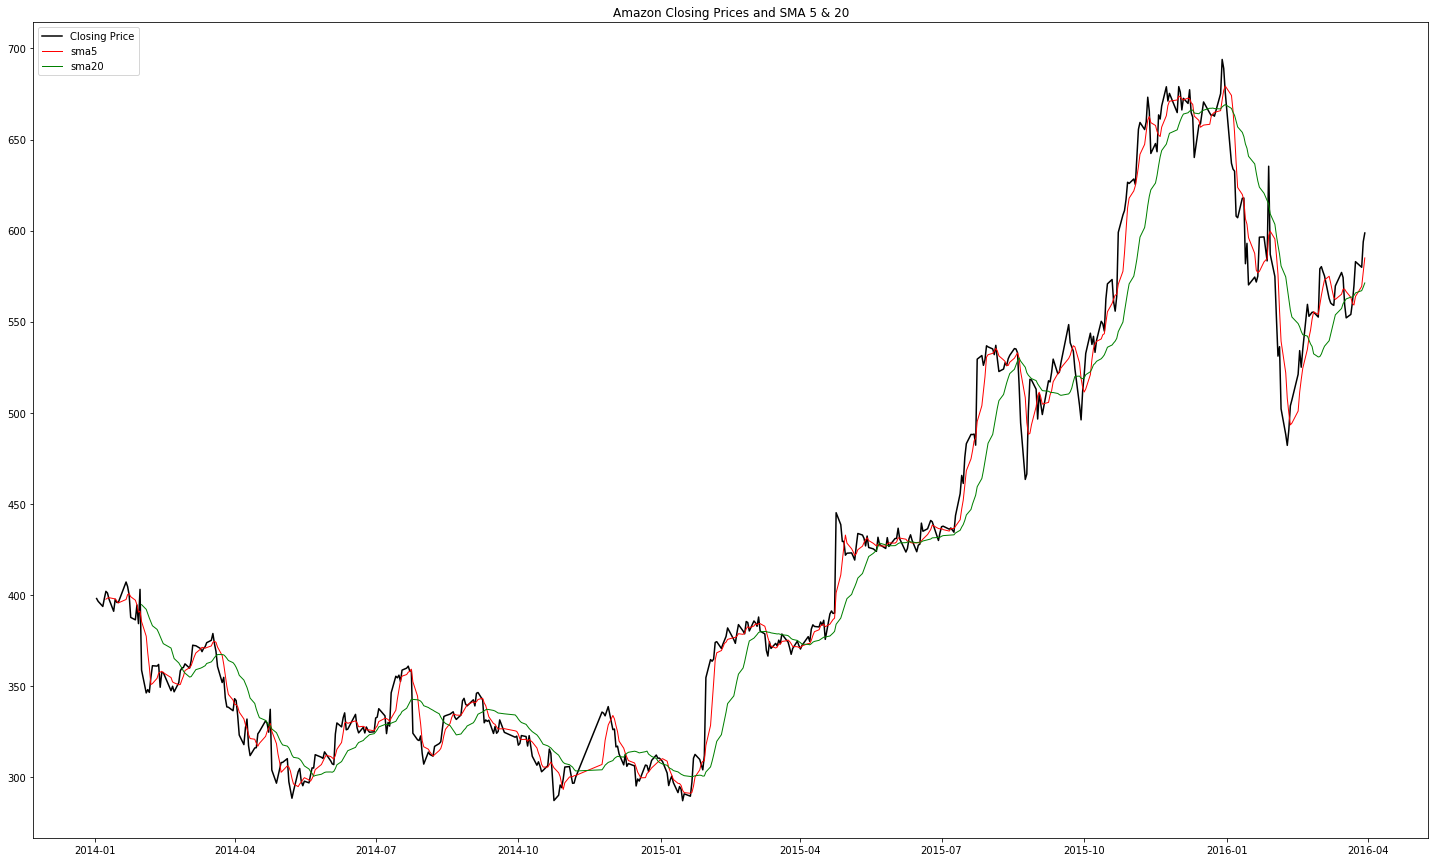

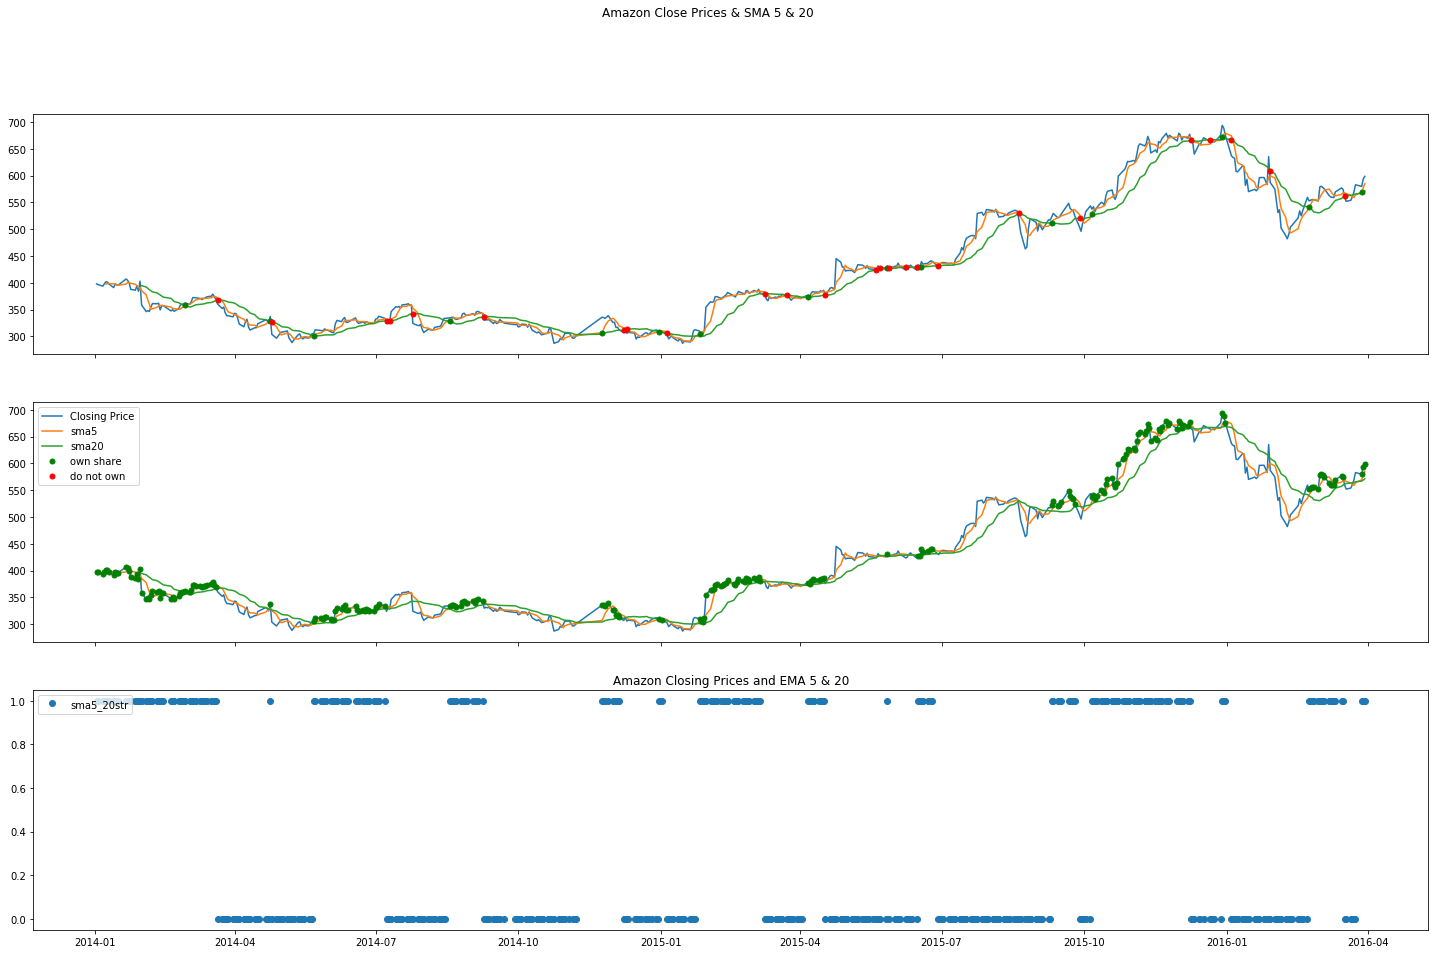

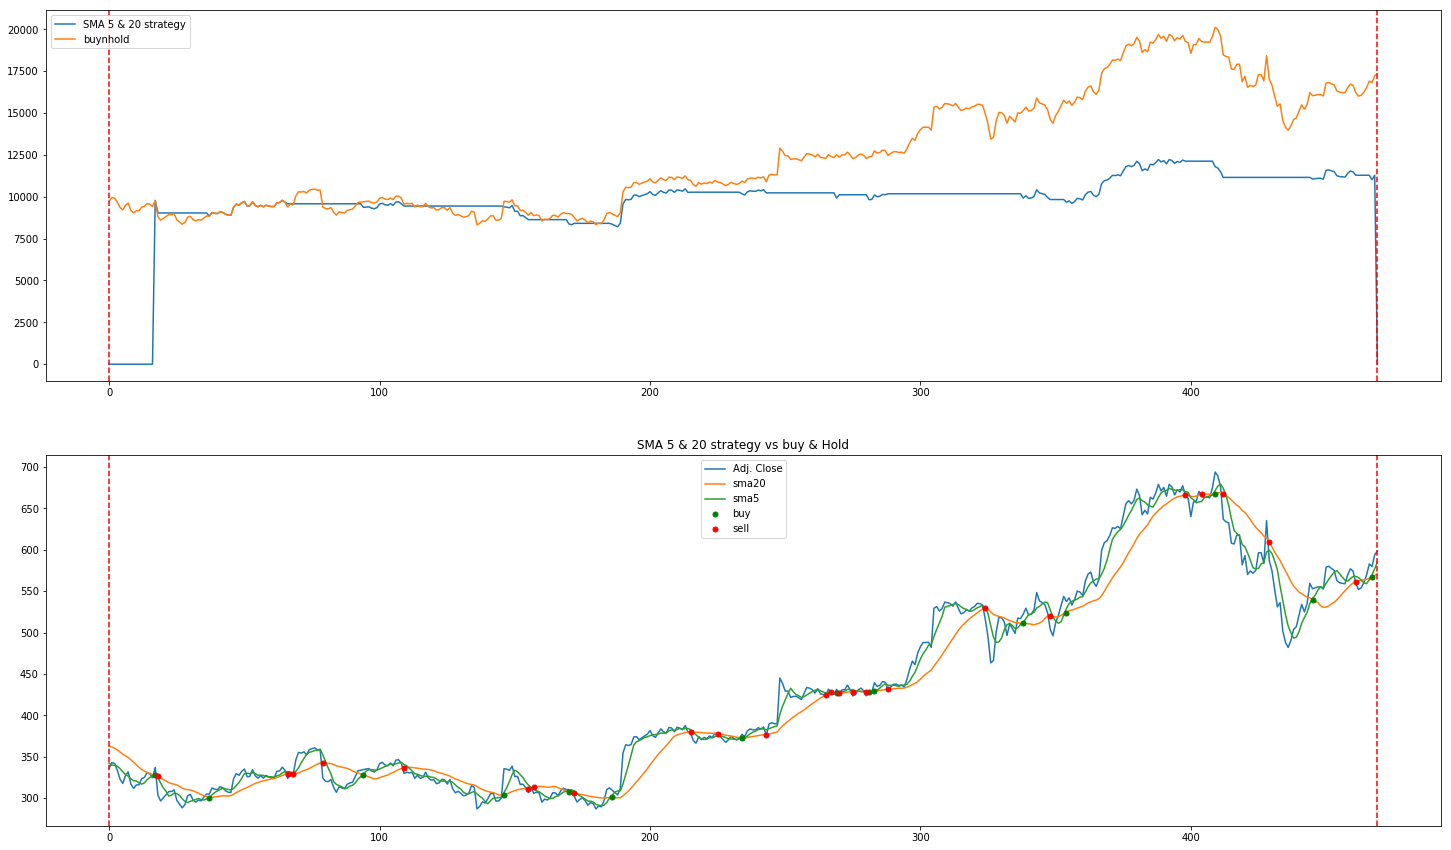

investing 10,000 pounds initially


0                 1              2             3  \
0                 Inital Amount($)  Number Shares  Buy Price($)   
1   buy and hold            10,000             29        336.36   
2                                                                 
3           sma5            10,000            NaN        342.99   
4                                                                 
5           ema5            10,000            NaN        342.99   
6                                                                 
7          ema20            10,000            NaN        337.15   
8                                                                 
9             BB            10,000            NaN        336.36   
10                                                                
11           RSI            10,000            NaN        342.99   
12                                                                
13       ema5_20            10,000            NaN        312.24   
14                                                                
15       sma5_20            10,000            NaN        337.15   

                4                5                  6          7  \
0   Sell Price($)  Price change($)  capital return($)  Profit($)   
1          598.69           262.33              17362    7362.01   
2                                                                  
3          593.86           250.87             8907.9    -1092.1   
4                                                                  
5          593.86           250.87            10689.5     689.48   
6                                                                  
7          593.86           256.71            11877.2     1877.2   
8                                                                  
9          635.35           298.99            14525.7     4525.7   
10                                                                 
11         593.86           250.87            12471.1    2471.06   
12                                                                 
13         593.86           281.62            11877.2     1877.2   
14                                                                 
15         593.86           256.71            11283.3    1283.34   

                  8                     9  
0   Total Return(%)  Annualised Return(%)  
1             73.62                 27.47  
2                                          
3            -10.92                   NaN  
4                                          
5              6.89                  3.97  
6                                          
7             18.77                  9.15  
8                                          
9             45.26                 18.64  
10                                         
11            24.71                 11.45  
12                                         
13            18.77                  9.15  
14                                         
15            12.83                  6.69

In [11]:
sma5_20_df = ticker_df.copy()
# set date as index now that we have merged all the data
sma5_20_df = sma5_20_df.set_index('Date')

#Add moving averages SMA
sma5_20_df['sma5'] = ta.SMA(np.asarray(sma5_20_df['Adj. Close']), 5)
sma5_20_df['sma20'] = ta.SMA(np.asarray(sma5_20_df['Adj. Close']), 20)
#aapletweet['sma100'] = ta.SMA(np.asarray(aapletweet['Adj. Close']), 100)



#PLot chart
fig1, ax = plt.subplots(figsize=(25, 15))


ax.plot(sma5_20_df['Adj. Close'], color='black', label='Closing Price')

#5 day Moving Average
ax.plot(sma5_20_df['sma5'], lw=1., color='red', label='sma5')

#20 day Moving Average
ax.plot(sma5_20_df['sma20'], lw=1., color='green', label='sma20')

plt.title('{} Closing Prices and SMA 5 & 20'.format(ticker_name))
plt.legend(loc='upper left')
plt.show()

#*******

#Create training Signals with SMA5
#Initialise column
sma5_20_df['sma5_20sig'] = 0

#test this against one day lag
sma5_20sig = 0

sma5_20_df['Adj. Close(-1)'] = sma5_20_df['Adj. Close'].shift(1)
sma5_20_df['sma20(-1)'] = sma5_20_df['sma20'].shift(1)
sma5_20_df['sma5(-1)'] = sma5_20_df['sma5'].shift(1)

# Generate Trading Signals (buy=1 , sell=-1, do nothing=0)
for i, row in enumerate(sma5_20_df.iterrows()):
    if row[1]['sma5(-1)'] < row[1]['sma20(-1)']  and row[1]['sma5'] > row[1]['sma20']:
       sma5_20sig = 1
    elif row[1]['Adj. Close(-1)'] >  row[1]['sma20(-1)']  and row[1]['Adj. Close'] < row[1]['sma20']:
        sma5_20sig = -1
    else:
        sma5_20sig = 0
    sma5_20_df.iloc[i, 13] = sma5_20sig




sma5_20_df['sma5_20str'] = 1 # initially own the stock

sma5_20str = 0 # initialise all as 0

for i, row in enumerate(sma5_20_df.iterrows()):
    if row[1]['sma5_20sig'] == 1:
        sma5_20str = 1 #own the stock
    elif row[1]['sma5_20sig'] == -1:
        sma5_20str = 0 #don't own the stock
    else:
        sma5_20str = sma5_20_df['sma5_20str'][i-1] # if dont have either of above, just  repeat previous period trading strategy
    sma5_20_df.iloc[i, 17] = sma5_20str # continue to update
    
    
#next we create strategy chart

fig, ax = plt.subplots(3, sharex=True, figsize=(25,15))

plt.title('{} Closing Prices and EMA 5 & 20'.format(ticker_name))
ax[0].plot(sma5_20_df['Adj. Close'], label='Adj. Close')
ax[0].plot(sma5_20_df['sma5'], label='sma5')
ax[0].plot(sma5_20_df['sma20'], label='sma20')

# Plot the buy signals
ax[0].plot(sma5_20_df.loc[sma5_20_df['sma5_20sig'] == 1.0].index, 
         sma5_20_df.sma5[sma5_20_df['sma5_20sig'] == 1.0],
         'o', markersize=5, color='g', label='buy')
         
# Plot the sell signals
ax[0].plot(sma5_20_df.loc[sma5_20_df['sma5_20sig'] == -1.0].index, 
         sma5_20_df.sma20[sma5_20_df['sma5_20sig'] == -1.0],
         'o', markersize=5, color='r', label='sell')

ax[1].plot(sma5_20_df['Adj. Close'], label='Closing Price')
ax[1].plot(sma5_20_df['sma5'], label='sma5')
ax[1].plot(sma5_20_df['sma20'], label='sma20')
ax[1].legend(loc='upper left')

# Plot the buy signals
ax[1].plot(sma5_20_df.loc[sma5_20_df['sma5_20str'] == 1.0].index, 
         sma5_20_df['Adj. Close'][sma5_20_df['sma5_20str'] == 1.0],
         'o', markersize=5, color='g', label='own share')
         
# Plot the sell signals
ax[1].plot(sma5_20_df.loc[sma5_20_df['sma5_20str'] == -1.0].index, 
         sma5_20_df['Adj. Close'][sma5_20_df['sma5_20str'] == -1.0],
         'o', markersize=5, color='r', label='do not own')

ax[1].legend(loc='best')


ax[2].plot(sma5_20_df['sma5_20str'], marker='o', linestyle='', label='sma5_20str')
ax[2].legend(loc='upper left')
plt.suptitle('{} Close Prices & SMA 5 & 20'.format(ticker_name))
plt.show()    

#******

#Finally for strategy performance metrics

#ema_df.set_index('Date', inplace=True)
sma5_20_df = sma5_20_df['2014-03-31' : '2016-03-31']
sma5_20_df = sma5_20_df.reset_index()

# Teesting against invested funds
investment = 10000
sma5_20_df['capital']= investment
sma5_20_df['invested'] = 0
sma5_20_df['price'] = sma5_20_df['Adj. Close']
sma5_20_df['pnl'] = 0 # initially own the stock
sma5_20_df['shares'] = int(investment / sma5_20_df['Adj. Close'][0])
sma5_20_df['buynhold'] = sma5_20_df['shares'] * sma5_20_df['Adj. Close']


sma5_20_df['capital'] = sma5_20_df['capital'].astype('float64') 
sma5_20_df['invested'] = sma5_20_df['invested'].astype('float64')
sma5_20_df['pnl'] = sma5_20_df['pnl'].astype('float64')
sma5_20_df['shares'] = sma5_20_df['shares'].astype('float64')
sma5_20_df['buynhold'] = sma5_20_df['buynhold'].astype('float64')

sma5_20_df = sma5_20_df.round(2)


for i in range(0,len(sma5_20_df)-1):
  
  get_price = sma5_20_df['Adj. Close'].iloc[i]

  inital = 0 
  buy_price=0
  difference_price=0
  sell_price=0
  next_date = sma5_20_df.Date.iloc[i+1]
  capital_1 = sma5_20_df['capital'].iloc[i-1]
  capital = sma5_20_df['capital'].iloc[i]
  nominal = sma5_20_df['pnl'].iloc[i]-1
  capital_invested = sma5_20_df['Adj. Close'].iloc[i]
  invested_shares = int(sma5_20_df['capital'].iloc[i-1] / get_price)
  #pnl = invested_shares * get_price

  get_pnl = sma5_20_df['pnl'].iloc[i-1]
  sma5 = sma5_20_df['sma5'].iloc[i]
  sma20 = sma5_20_df['sma20'].iloc[i]
  sma5_20str = sma5_20_df['sma5_20str'].iloc[i]
  sma5_20sig = sma5_20_df['sma5_20sig'].iloc[i]
  sma5_20str_1 = sma5_20_df['sma5_20str'].iloc[i-1]
  invested_1 = sma5_20_df['invested'].iloc[i-1]
  invested = sma5_20_df['invested'].iloc[i]
  buynhold = sma5_20_df['shares'].iloc[i] * get_price
  pnl_1 = sma5_20_df['pnl'].iloc[i-1]
  shares = sma5_20_df['shares'].iloc[i]
  
  
  if(sma5_20str) == 0 and i==0:
    #print('i=0')
    sma5_20_df.at[i,'capital'] = investment    
    sma5_20_df.at[i,'invested'] = 0       
    sma5_20_df.at[i,'pnl'] = 0 
    
  
  elif(sma5_20str) == 1 and i==0:
    #print('i=0')
    sma5_20_df.at[i,'invested'] = int(investment/ get_price)      
    sma5_20_df.at[i,'capital'] = int(initial - ((sma5_20_df['invested'].iloc[i] *get_price)))      
    sma5_20_df.at[i,'pnl'] = sma5_20_df['invested'].iloc[i] * get_price   
  
  elif(sma5_20str) == 0 and sma5_20str_1 == 0 and capital_1 ==investment:
    ema5_20_df.at[i,'invested'] = invested_1  
    ema5_20_df.at[i,'capital'] = capital_1
    ema5_20_df.at[i, 'pnl'] = 0
   
  elif(sma5_20str) == 0 and sma5_20str_1 == 0 and capital_1 !=investment:
    sma5_20_df.at[i,'invested'] = invested_1  
    sma5_20_df.at[i,'capital'] = capital_1
    sma5_20_df.at[i, 'pnl'] = pnl_1
     
  elif(sma5_20str) == 1 and sma5_20str_1 == 0:
    sma5_20_df.at[i,'invested'] = int(capital_1/ get_price)  
    sma5_20_df.at[i,'capital'] = int(capital_1 - ((sma5_20_df['invested'].iloc[i] *get_price)))
    sma5_20_df.at[i, 'pnl'] = sma5_20_df['invested'].iloc[i] * get_price
    price_buy = get_price
  
  elif(sma5_20str) == 0 and sma5_20str_1 == 1 and capital_1 !=investment:
    #print('i=0')
    differece_price = (get_price - price_buy) 
    sma5_20_df.at[i,'capital'] = capital_1 + (invested_1 * get_price) + (difference_price * invested_1)    
    sma5_20_df.at[i,'invested'] = 0       
    sma5_20_df.at[i,'pnl'] = sma5_20_df['capital'].iloc[i]
    
    
  else: 
    sma5_20_df.at[i,'capital'] = capital_1    
    sma5_20_df.at[i,'invested'] = invested_1       
    sma5_20_df.at[i,'pnl'] = sma5_20_df['invested'].iloc[i] * get_price
    
sma5_20_df = sma5_20_df[['Date', 'Adj. Close', 'Comp', 'sma5', 'sma20', 'sma5_20sig', 'sma5_20str', 'capital', 'invested', 'pnl', 'shares', 'buynhold']]
endYr2 = sma5_20_df.index[-1]
#slide dataframe for 2 years

# pnl Returns Chart
fig, ax = plt.subplots(2, figsize=(25, 15))

ax[0].plot(sma5_20_df['pnl'], label = 'SMA 5 & 20 strategy' )
ax[0].plot(sma5_20_df['buynhold'], label = 'buynhold')

ax[0].axvline(0, color='r', ls='--')
ax[0].axvline(sma5_20_df.index[-1], color='r', ls='--')

#sma_df.loc[(sma_df['Date'].dt.month==12) & (sma_df['Date'].dt.day==31) & (sma_df['Date'].dt.year==2014), 'Adj. Close']


ax[0].legend(loc='upper left')

# Plot the buy signals
ax[1].plot(sma5_20_df['Adj. Close'], label='Adj. Close')
ax[1].plot(sma5_20_df['sma20'], label='sma20')
ax[1].plot(sma5_20_df['sma5'], label='sma5')

ax[1].plot(sma5_20_df.loc[sma5_20_df['sma5_20sig'] == 1.0].index, 
         sma5_20_df.sma20[sma5_20_df['sma5_20sig'] == 1.0],
         'o', markersize=5, color='g', label='buy')
         
# Plot the sell signals
ax[1].plot(sma5_20_df.loc[sma5_20_df['sma5_20sig'] == -1.0].index, 
         sma5_20_df.sma20[sma5_20_df['sma5_20sig'] == -1.0],
         'o', markersize=5, color='r', label='sell')

ax[1].axvline(0, color='r', ls='--')
ax[1].axvline(sma5_20_df.index[-1], color='r', ls='--')

ax[1].legend(loc='upper left')

plt.title('SMA 5 & 20 strategy vs buy & Hold')
plt.legend()
plt.show()

#*********

sma5_20buyPrice_yr_1 = sma5_20_df['Adj. Close'].iloc[0]
sma5_20sellPrice_yr_2 = sma5_20_df.loc[(sma5_20_df['Date'].dt.month==12) & (sma5_20_df['Date'].dt.day==31) & (sma5_20_df['Date'].dt.year==2015), 'Adj. Close']

sma5_20BuyIndexyr1=17
sma5_20SellIndexyr2=468

sma5_20BuyPrice_yr1 = sma5_20_df['Adj. Close'].iloc[sma5_20BuyIndexyr1]
sma5_20SellPrice_yr2 = sma5_20_df['Adj. Close'].iloc[sma5_20SellIndexyr2]

sma5_20shares_invested = int(initial / sma5_20BuyPrice_yr1)

sma5_20Price_change = (sma5_20SellPrice_yr2 - sma5_20BuyPrice_yr1)

sma5_20capital_return = sma5_20_df['pnl'].loc[sma5_20SellIndexyr2]

sma5_20Profit = sma5_20capital_return - initial

sma5_20Return = ((sma5_20Profit/initial)*100).round(2)

def annualisedSma520():
  if (len(sma5_20_df) > 365):
    sma5_20_returnAnnualised = ((1 + sma5_20Return)**(365/len(sma5_20_df))-1).round(2) 
  else:
    sma5_20_returnAnnualised = 0
    
  return sma5_20_returnAnnualised

print('investing 10,000 pounds initially')

# Summary Results Data Table
sma5_20data = [{'0': '', '1': 'Inital Amount($)', '2': 'Number Shares', '3': 'Buy Price($)', '4': 'Sell Price($)', '5': 'Price change($)', '6': 'capital return($)', '7': 'Profit($)', '8': 'Total Return(%)', '9': 'Annualised Return(%)'},
        {'0': 'buy and hold', '1': '10,000', '2': bhshares_invested, '3': bhBuyPrice_yr1, '4': bhSellPrice_yr2, '5': bhPrice_change_yr2,  '6': bhcapitalReturnyr2, '7': bhProfit_yr2, '8': bhReturn_yr2, '9': annualised()},  
         
        {'0': '', '1':'' , '2': '', '3': '', '4': '', '5': '', '6': '', '7': '', '8': '', '9': ''},
        
        {'0': 'sma5', '1': '10,000', '2': 'NaN', '3': sma5BuyPrice_yr1, '4': sma5SellPrice_yr2, '5': sma5Price_change_yr2,  '6': sma5capital_return_yr2, '7': sma5Profit_yr2, '8': sma5Return_yr2, '9': annualisedSma()},

            
             {'0': '', '1':'' , '2': '', '3': '', '4': '', '5': '', '6': '', '7': '', '8': '', '9': ''},
        
        {'0': 'ema5', '1': '10,000', '2': 'NaN', '3': ema5BuyPrice_yr1, '4': ema5SellPrice_yr2, '5': ema5Price_change_yr2,  '6': ema5capital_return_yr2, '7': ema5Profit_yr2, '8': ema5Return_yr2, '9': annualisedEma()},
    

            {'0': '', '1':'' , '2': '', '3': '', '4': '', '5': '', '6': '', '7': '', '8': '',  '9': ''},
        
        {'0': 'ema20', '1': '10,000', '2': 'NaN', '3': ema20BuyPrice_yr1, '4': ema20SellPrice_yr2, '5': ema20Price_change,  '6': ema20capital_return, '7': ema20Profit, '8': ema20Return, '9': annualisedEma20()},
         
              {'0': '', '1':'' , '2': '', '3': '', '4': '', '5': '', '6': '', '7': '', '8': '', '9': ''},
        
        {'0': 'BB', '1': '10,000', '2': 'NaN', '3': bollBuyPrice_yr1, '4': bollSellPrice_yr2, '5': bollPrice_change,  '6': bollcapital_return, '7': bollProfit, '8': bollReturn, '9': annualisedBoll()},   

            {'0': '', '1':'' , '2': '', '3': '', '4': '', '5': '', '6': '', '7': '', '8': '', '9': ''},
        
        {'0': 'RSI', '1': '10,000', '2': 'NaN', '3': rsiBuyPrice_yr1, '4': rsiSellPrice_yr2, '5': rsiPrice_change,  '6': rsicapital_return_yr2, '7': rsiProfit_yr2, '8': rsiReturn_yr2, '9': annualisedRSI()},
  

                   {'0': '', '1':'' , '2': '', '3': '', '4': '', '5': '', '6': '', '7': '', '8': '', '9': ''},
  
        
        {'0': 'ema5_20', '1': '10,000', '2': 'NaN', '3': ema5_20BuyPrice_yr1, '4': ema5_20SellPrice_yr2, '5': ema5_20Price_change,  '6': ema5_20capital_return, '7': ema5_20Profit, '8': ema5_20Return, '9': annualisedEma520()},
               
               {'0': '', '1':'' , '2': '', '3': '', '4': '', '5': '', '6': '', '7': '', '8': '', '9': ''},
  
        
        {'0': 'sma5_20', '1': '10,000', '2': 'NaN', '3': sma5_20BuyPrice_yr1, '4': sma5_20SellPrice_yr2, '5': sma5_20Price_change,  '6': sma5_20capital_return, '7': sma5_20Profit, '8': sma5_20Return, '9': annualisedSma520()},
        ]
    
        
    
    
   
table = pd.DataFrame(sma5_20data)

table

#********



In [0]:
#*********** end*******************

#Prediction

In [12]:
import tensorflow as tf 
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split

import re
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Embedding, Dropout
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import GridSearchCV
import math
import numpy as np
from keras import regularizers
from keras.layers.core import Dense, Dropout, Activation
from keras.activations import linear
from keras.layers.recurrent import LSTM
from sklearn import preprocessing, svm, datasets
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression
#from keras.layers import Dense
#from keras.layers import  Dropout
from keras.models import model_from_json
from keras.models import load_model
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from keras.layers import Dense, Activation ,Dropout , Flatten , Conv1D ,MaxPooling1D
from keras import losses
from sklearn.metrics import mean_absolute_error

def set_pandas_options() -> None:
    pd.options.display.max_columns = 1000
    pd.options.display.max_rows = 1000
    pd.options.display.max_colwidth = 199
    pd.options.display.width = None
    pd.options.display.precision = 2  # set as needed

set_pandas_options()

#get the columns we want using sma5
stock_df = sma5_df[['Date', 'Tweets', 'Adj. Open', 'Adj. High', 'Adj. Low', 'Adj. Close', 'Adj. Volume', 'Comp', 'sentiment', 'sma5', 'sma5sig', 'sma5str']]


Using TensorFlow backend.


# LSTM Amazon n days window with sma5

data shape is:  (470, 8)
LS_df is:  (465, 5, 8)
train.shape after 80/20 split:
(372, 5, 8)

Training set: 372 observations
window: 5
trainEnd: 377
testEnd: 475
Original train shape is:  (372, 8)

Original test shape is:  (93, 8)


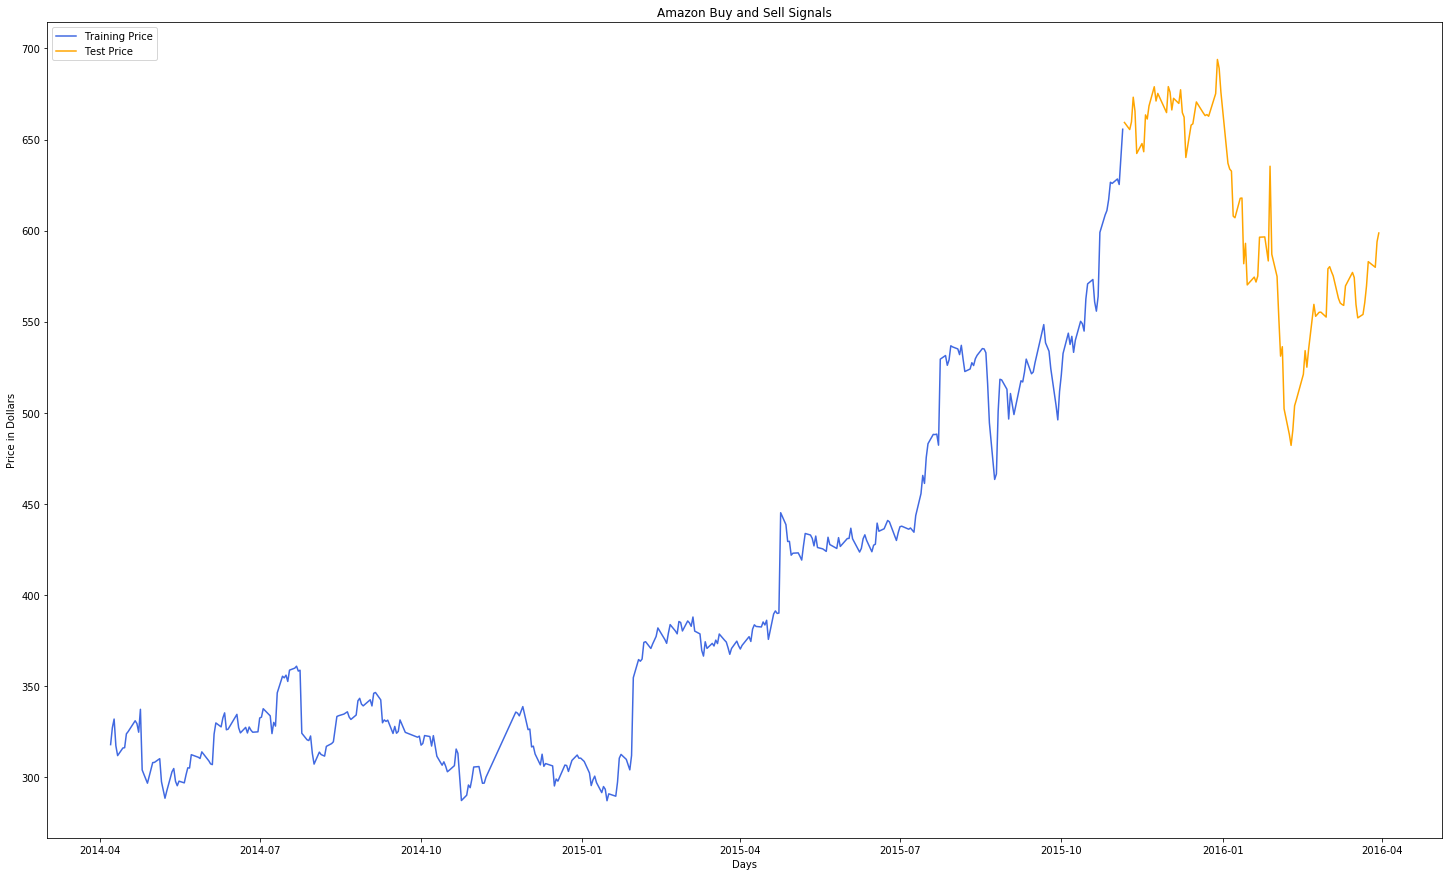

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 50)                11800     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 11,851
Trainable params: 11,851
Non-trainable params: 0
_________________________________________________________________
Train on 372 samples, validate on 93 samples
Epoch 1/50
 - 1s - loss: 0.0816 - mean_squared_error: 0.0816 - mean_absolute_error: 0.1997 - mean_absolute_percentage_error: 66310.1347 - val_loss: 0.3727 - val_mean_squared_error: 0.3727 - val_mean_absolute_error: 0.5975 - val_mean_absolute_percentage_error: 76.1001
Epoch 2/50
 - 0s - loss: 0.0390 - mean_squared_error: 0.0390 - mean

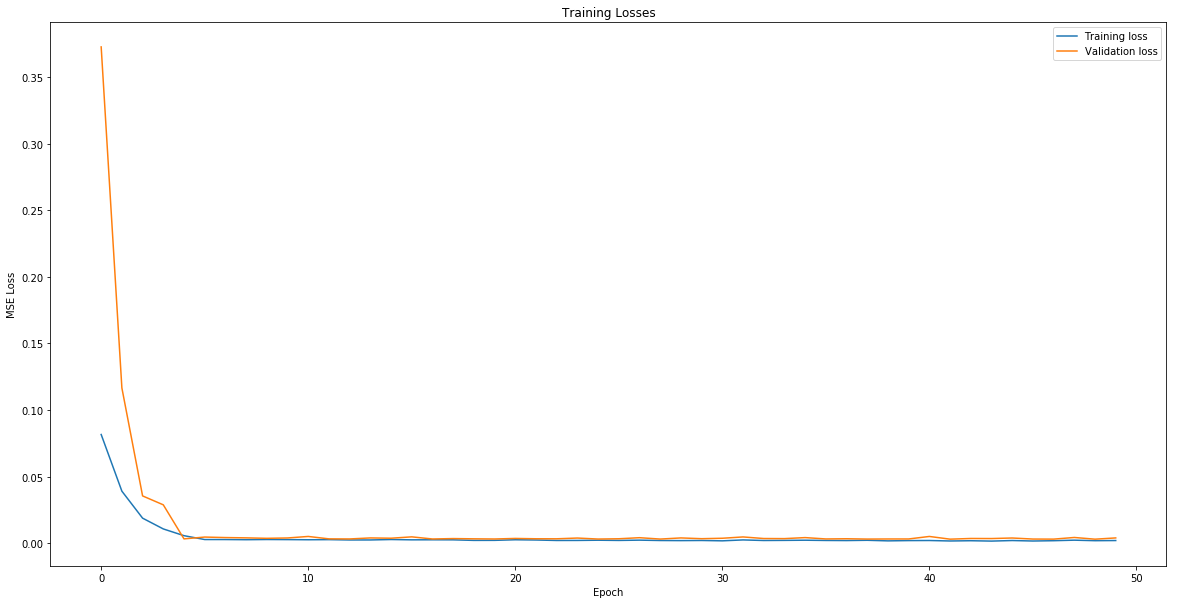

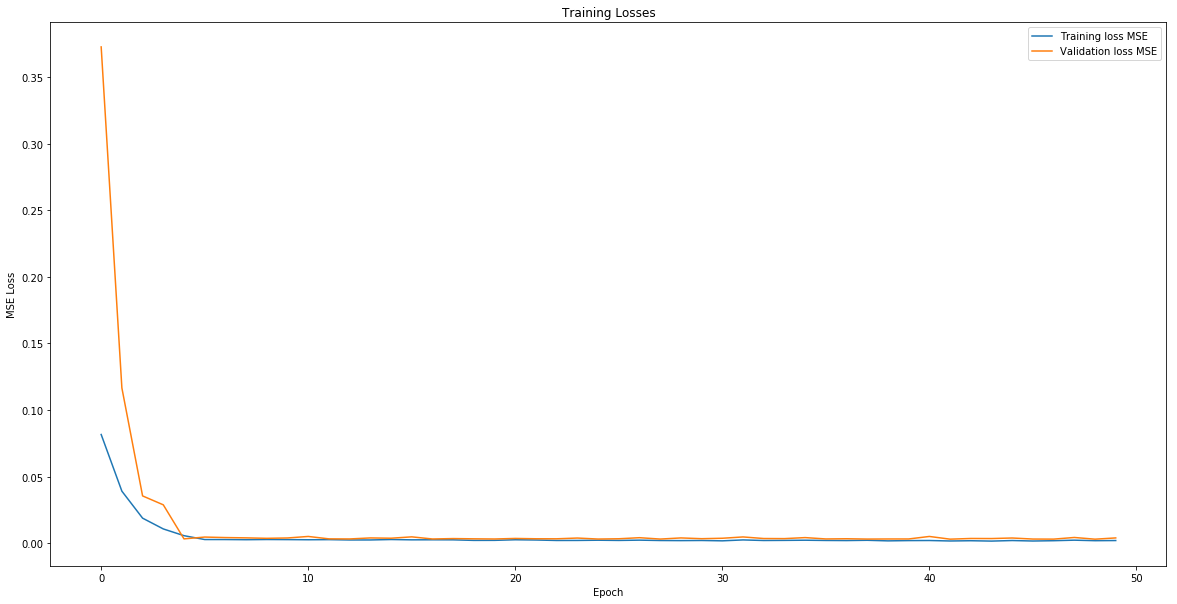

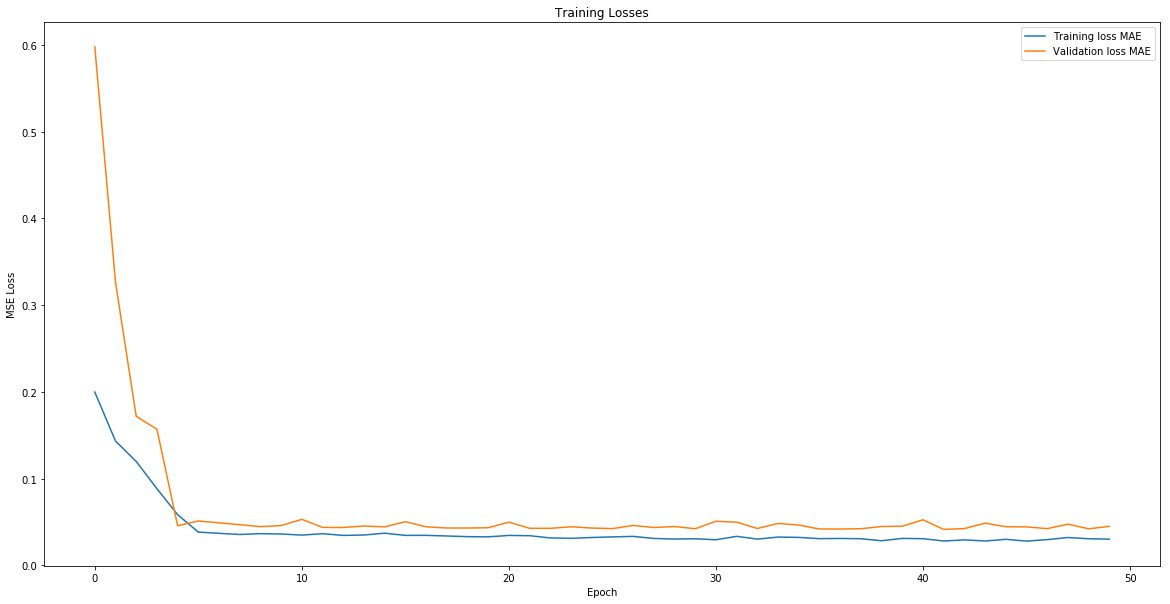

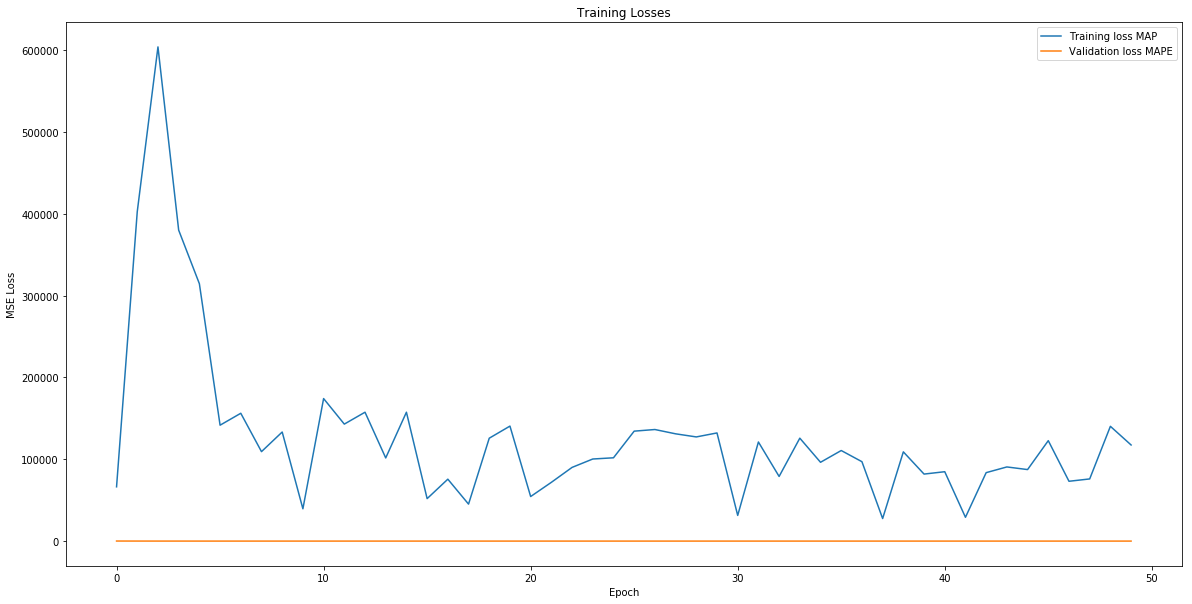

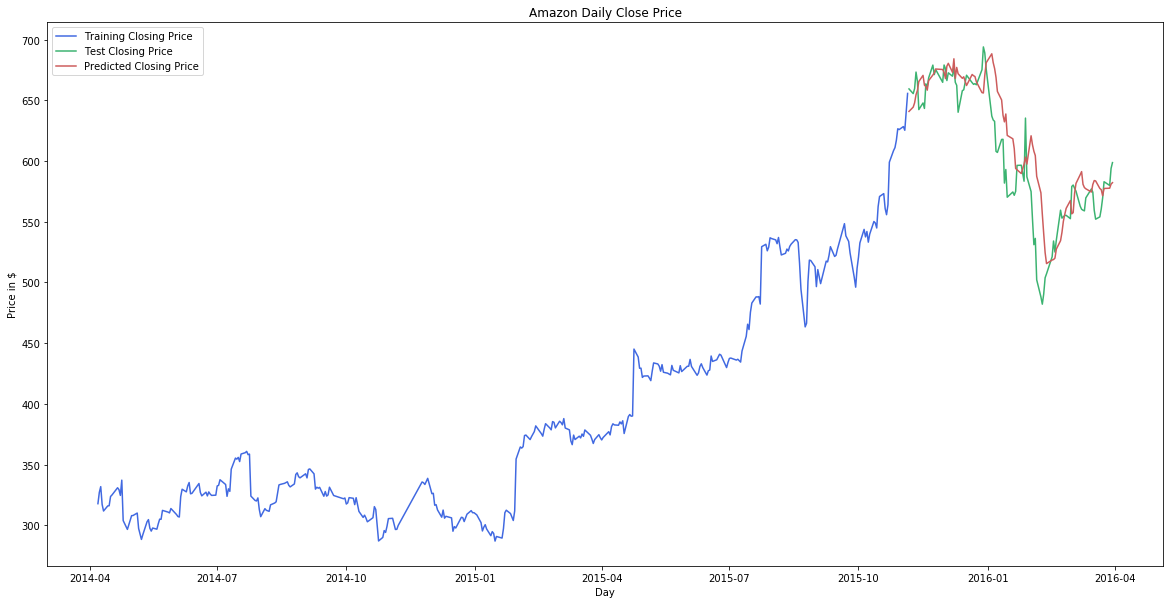

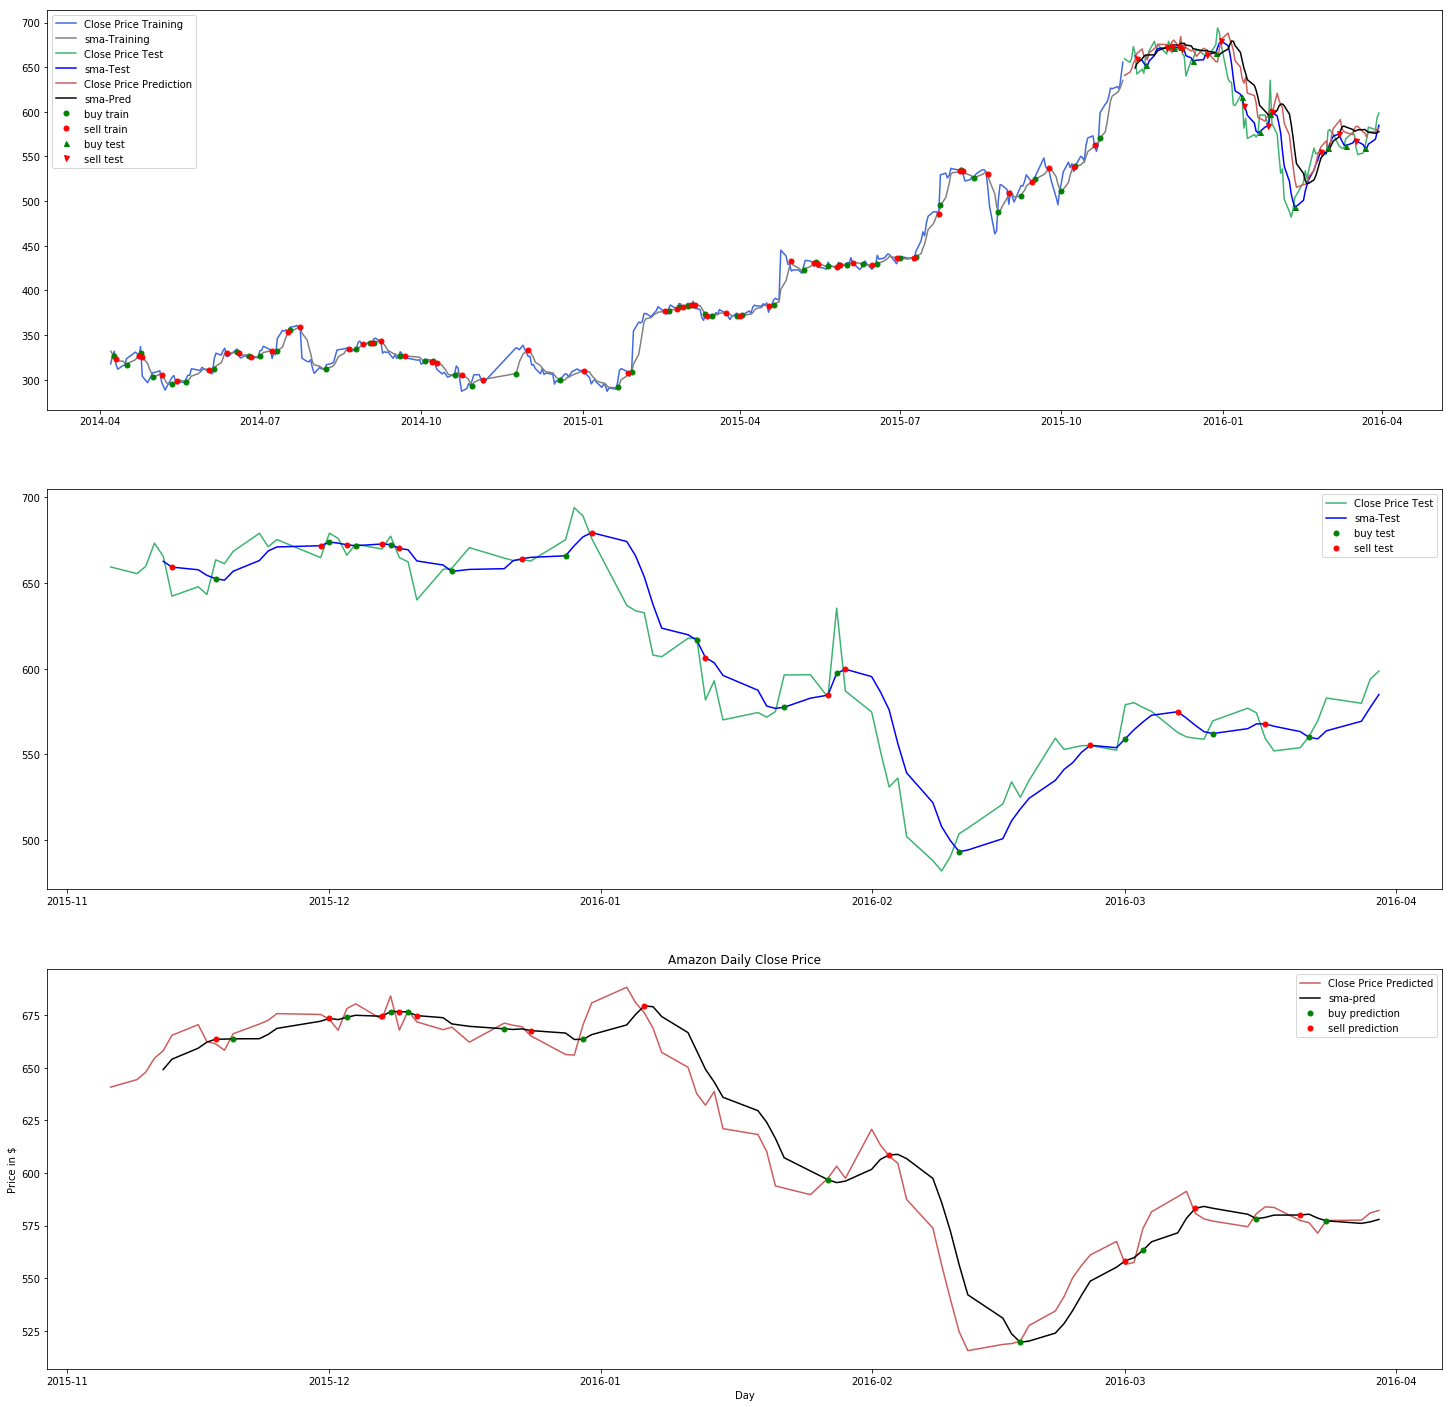

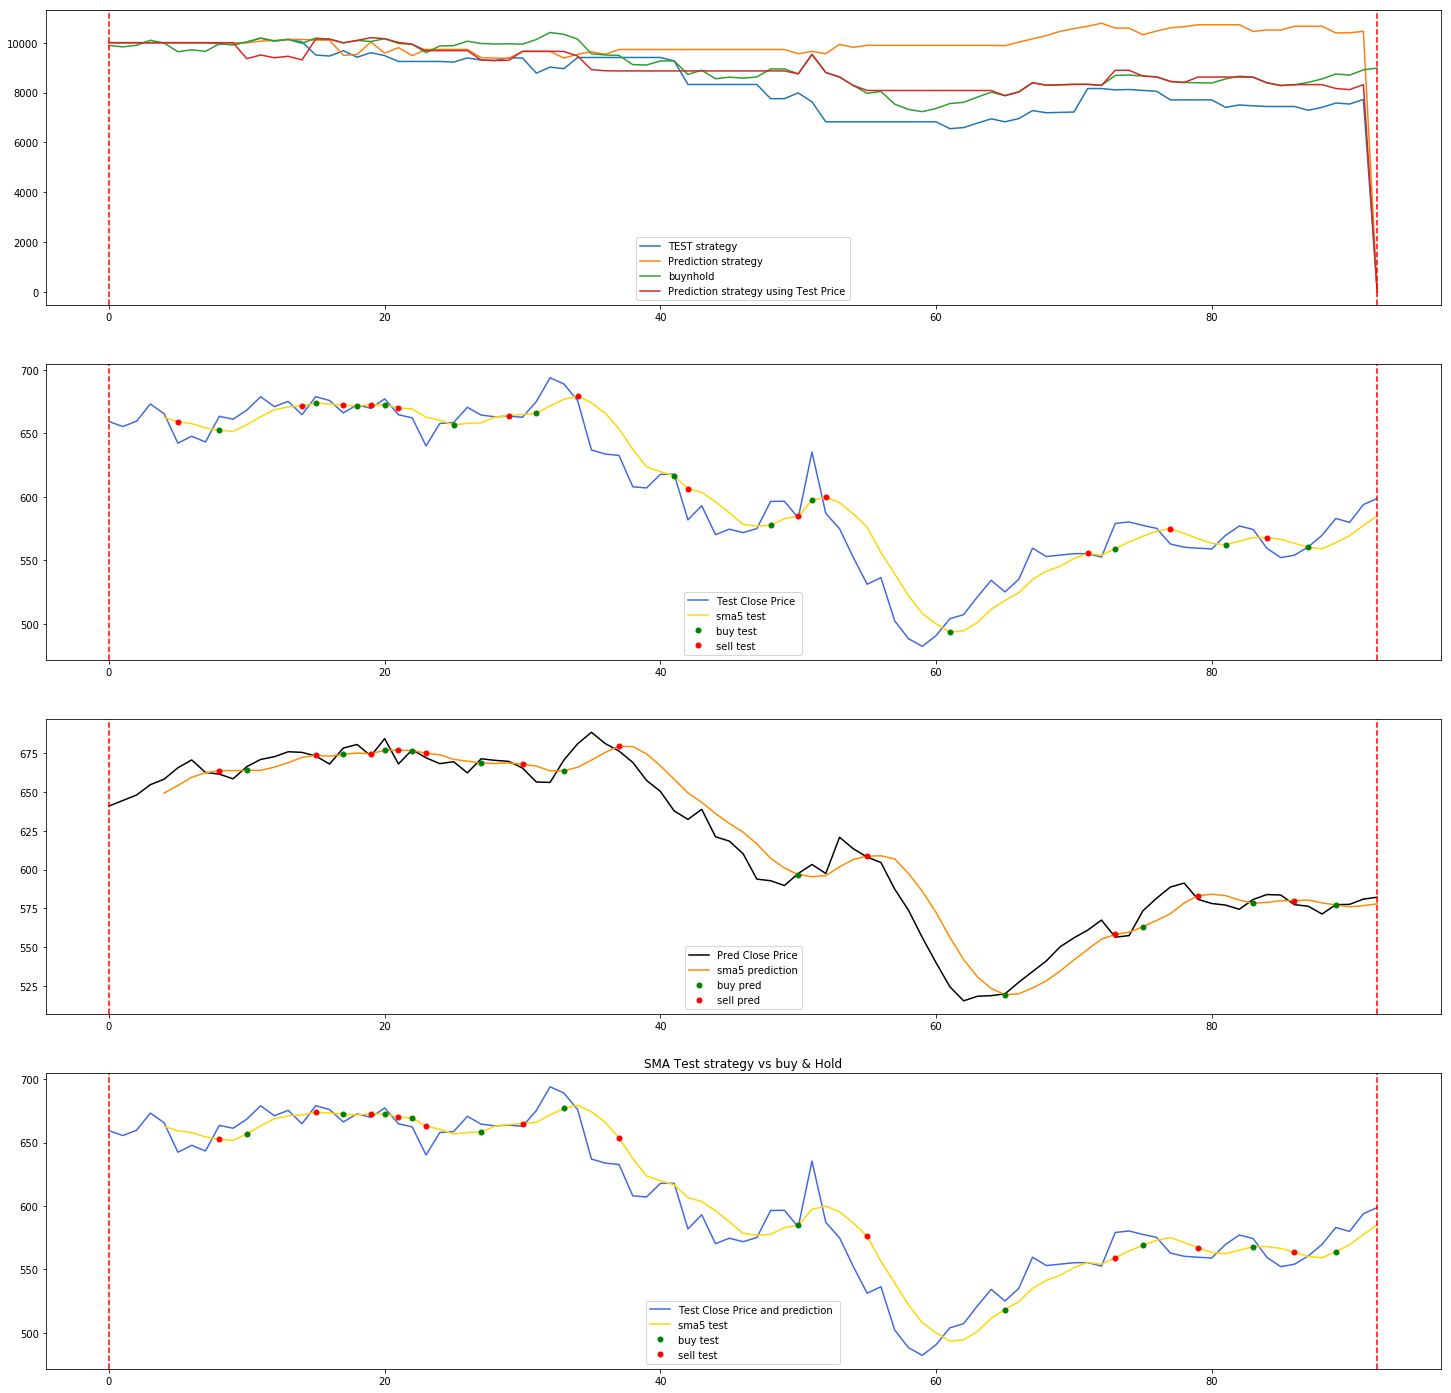

investing 10,000 pounds initially using test data


0                 1              2             3  \
0                            Inital Amount($)  Number Shares  Buy Price($)   
1             buy and hold             10,000             15        659.37   
2                                                                            
3                      test            10,000            NaN           NaN   
4                                                                            
5                prediction             10000            NaN           NaN   
6                                                                            
7  prediction on Test Price             10000            NaN           NaN   

               4                5                  6          7          8  
0  Sell Price($)  Price change($)  capital return($)  Profit($)  Return(%)  
1         598.69           -60.68            8980.35   -1019.65     -10.20  
2                                                                           
3            NaN              NaN               7720      -2280     -22.80  
4                                                                           
5            NaN              NaN           10457.28     457.28       4.57  
6                                                                           
7            NaN              NaN            8314.04   -1685.96     -16.86

In [16]:
def set_pandas_options() -> None:
    pd.options.display.max_columns = 1000
    pd.options.display.max_rows = 1000
    pd.options.display.max_colwidth = 199
    pd.options.display.width = None
    pd.options.display.precision = 2  # set as needed

set_pandas_options()

#get the columns we want
stock_df = sma5_df[['Date', 'Tweets', 'Adj. Open', 'Adj. High', 'Adj. Low', 'Adj. Close', 'Adj. Volume', 'Comp', 'sentiment', 'sma5', 'sma5sig']]

#get rid of tweets?? becasue we cannot scale them - or can we? need two Xshapes

df_5 = stock_df[['Adj. Open', 'Adj. Low', 'Adj. High', 'Adj. Volume', 'Comp', 'sma5', 'sma5sig', 'Adj. Close']]

df_5.dropna(inplace=True)

df5 = sma5_df[['Date', 'Adj. Open', 'Adj. Low', 'Adj. High', 'Adj. Volume', 'Comp', 'sma5', 'sma5sig', 'Adj. Close']]
df5.set_index('Date', inplace=True)


#*****

#take out next_decision
LS = df5.copy() #[['Adj. Open', 'Adj. Low', 'Adj. High', 'Adj. Close', 'Adj. Volume', 'Comp', 'ema205', 'ema5sig']]



#***
y = LS['Adj. Close']

#np.random.seed(7)

#***
scaler = preprocessing.MinMaxScaler()

LS['Adj. Open'] = scaler.fit_transform(LS['Adj. Open'].values.reshape(-1,1))
LS['Adj. Low'] = scaler.fit_transform(LS['Adj. Low'].values.reshape(-1,1))
LS['Adj. High'] = scaler.fit_transform(LS['Adj. High'].values.reshape(-1,1))
LS['Adj. Volume'] = scaler.fit_transform(LS['Adj. Volume'].values.reshape(-1,1))
LS['Comp'] = scaler.fit_transform(LS['Comp'].values.reshape(-1,1))
LS['sma5'] = scaler.fit_transform(LS['sma5'].values.reshape(-1,1))
LS['sma5sig'] = scaler.fit_transform(LS['sma5sig'].values.reshape(-1,1))
LS['Adj. Close'] = scaler.fit_transform(LS['Adj. Close'].values.reshape(-1,1))

#*******

data = LS.as_matrix()
print('data shape is: ', data.shape)
LS_df = []

window = 5 #days

for index in range(len(data) - window): 
    LS_df.append(data[index: index + window])
LS_df = np.array(LS_df)
print('LS_df is: ', LS_df.shape)

splitRow = round(0.8 * LS_df.shape[0])
no_features = len(LS.columns)

## Training (80%)
train = LS_df[:int(splitRow), :]

print('train.shape after 80/20 split:')      
print(train.shape)
print()      
X_train = train[:, :-1] # all data until day 4
y_train = train[:, -1][:,-1] # day 5 last column
print('Training set:', train.shape[0], 'observations')

## Test (20%)
test = LS_df[int(splitRow):, :]
      
   
X_test = test[:, :-1] # all data until day n-1
y_test = test[:, -1][:,-1] # day n of last column

trainEnd = train.shape[0] + (window)
testEnd = test.shape[0] + window + trainEnd

origTrain = df5.iloc[window:trainEnd]
origTest = df5.iloc[trainEnd:testEnd]

print('window:', window)
print('trainEnd:', trainEnd)
print('testEnd:', testEnd)
      
print('Original train shape is: ', origTrain.shape)
print()   
print('Original test shape is: ', origTest.shape)

fig, ax = plt.subplots(figsize=(25,15))

plt.title('{} Buy and Sell Signals'.format(ticker_name))
ax.plot(origTrain.index, origTrain['Adj. Close'], color='royalblue', label='Training Price')
ax.plot(origTest.index, origTest['Adj. Close'], color='orange', label='Test Price')

plt.xlabel('Days')
ax.legend(loc='upper left')
plt.ylabel('Price in Dollars')
plt.show()

#*****
           
def build_model(layers):

        d = 0.3 #dropout rate

        model = Sequential()
        model.add(LSTM(units = 50, input_shape=(layers[1], layers[0]), return_sequences=False)) #input shape is shape of training set
        model.add(Dropout(d))
        #model.add(LSTM(units = 25, input_shape=(layers[1], layers[0]), return_sequences=False)) #input shape is shape of training set
        #model.add(Dropout(d))
        #model.add(LSTM(units = 50, input_shape=(layers[1], layers[0]), return_sequences=False)) #input shape is shape of training set
        #model.add(Dropout(d))
        #model.add(LSTM(units = 50, input_shape=(layers[1], layers[0]), return_sequences=False)) #input shape is shape of training set
        #model.add(Dropout(d))
        
        model.add(Dense(1,kernel_initializer='uniform',activation='relu')) #output layer
        
        model.summary()       

        return model

#use this if you want to save model      
#model.save('/content/drive/My Drive/MScProject2019KamBansalColab/LSTM_model_amazon.h5')  # creates a HDF5 file 'my_model.h5'
#del model  # deletes the existing model
#model = load_model('/content/drive/My Drive/MScProject2019KamBansalColab/LSTM_model_amazon.h5')
#model.summary()

model = build_model([no_features, (window-1), 1])
model.compile(loss='mse',optimizer='adam',metrics=['mse', 'mae', 'mape'])


history = model.fit( X_train, y_train, batch_size= 32, epochs=50, validation_split=0.33, validation_data=(X_test, y_test), shuffle=True, verbose=2)

trainScore = model.evaluate(X_train, y_train, verbose=0)
print('Train Score: %.5f MSE (%.5f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))
print('Train Score: ', trainScore)

testScore = model.evaluate(X_test, y_test, verbose=0)
print('Test Score: %.5f MSE (%.5f RMSE)' % (testScore[0], math.sqrt(testScore[0])))
print('Test Score: ', testScore)
  
history_dict = history.history
history_dict.keys()

# plot loss and validation loss
fig, a = plt.subplots(figsize=(20,10))

a.plot(history.history['loss'], label='Training loss')
a.plot(history.history['val_loss'], label='Validation loss')
a.set_title('Training Losses')
a.set_xlabel('Epoch')
a.set_ylabel('MSE Loss')
plt.legend()
plt.show()

#*****
fig, a = plt.subplots(figsize=(20,10))

a.plot(history.history['mean_squared_error'], label='Training loss MSE')
a.plot(history.history['val_mean_squared_error'], label='Validation loss MSE')
a.set_title('Training Losses')
a.set_xlabel('Epoch')
a.set_ylabel('MSE Loss')
plt.legend()
plt.show()
#Results

fig, a = plt.subplots(figsize=(20,10))

a.plot(history.history['mean_absolute_error'], label='Training loss MAE')
a.plot(history.history['val_mean_absolute_error'], label='Validation loss MAE')
a.set_title('Training Losses')
a.set_xlabel('Epoch')
a.set_ylabel('MSE Loss')
plt.legend()
plt.show()
#Results

fig, a = plt.subplots(figsize=(20,10))

a.plot(history.history['mean_absolute_percentage_error'], label='Training loss MAP')
a.plot(history.history['val_mean_absolute_percentage_error'], label='Validation loss MAPE')
a.set_title('Training Losses')
a.set_xlabel('Epoch')
a.set_ylabel('MSE Loss')
plt.legend()
plt.show()
#Results

df5.head(), df5.shape, LS.head(), LS.shape, y_test.shape, X_test.shape

#*******

predict = model.predict(X_test)
prediction = scaler.inverse_transform(predict)

ytest = y_test.reshape(-1, 1)
ytest = scaler.inverse_transform(ytest)

ytest = [i[0] for i in ytest]
pred = [i[0] for i in prediction]

pred_df = origTest.copy()
pred_df['Adj. Close'] = pred


fig, ax = plt.subplots(figsize=(20,10))

ax.plot(origTrain.index, origTrain['Adj. Close'], color='royalblue', label='Training Closing Price')
ax.plot(origTest.index, origTest['Adj. Close'], color='mediumseagreen', label='Test Closing Price')
ax.plot(origTest.index, pred_df['Adj. Close'], color='indianred', label='Predicted Closing Price')
plt.xticks()

plt.legend(loc='upper left')
plt.title('{} Daily Close Price'.format(ticker_name))
plt.xlabel('Day')
plt.ylabel('Price in $')
plt.show()

#now merge datasets of prediction and test date so we can find out the ROI of 10000

pred = pred_df['Adj. Close']
test = origTest['Adj. Close']

test.columns = ['origTestPrice']
pred.columns = ['predPrice']

merge_df = pd.merge(test, pred, on='Date')
merge_df.columns = ['origTestPrice', 'predPrice']

merge_df_head = pd.DataFrame(merge_df.head())

merge_df = merge_df.reset_index()

merge_df_head = pd.DataFrame(merge_df.head())

merge_df = merge_df.set_index('Date')

#using sma5 because of data points not being enough with other indicators

merge_df['sma5pred'] = ta.SMA(np.asarray(merge_df['predPrice']), 5)
merge_df['sma5test'] = ta.SMA(np.asarray(merge_df['origTestPrice']), 5)

#Create training Signals with SMA5
#Initialise column

merge_df['sma5sigpred'] = 0
merge_df['sma5sigtest'] = 0

#test this against one day lag
sma5sigtest = 0
sma5sigpred = 0

merge_df['origTestPrice(-1)'] = merge_df['origTestPrice'].shift(1)
merge_df['sma5test(-1)'] = merge_df['sma5test'].shift(1)

merge_df['predPrice(-1)'] = merge_df['predPrice'].shift(1)
merge_df['sma5pred(-1)'] = merge_df['sma5pred'].shift(1)


# Generate Trading Signals (buy=1 , sell=-1, do nothing=0)
for i, r in enumerate(merge_df.iterrows()):
  if r[1]['predPrice(-1)'] < r[1]['sma5pred(-1)'] and r[1]['predPrice'] > r[1]['sma5pred']:
    sma5sigpred = 1
  elif r[1]['predPrice(-1)'] > r[1]['sma5pred(-1)'] and r[1]['predPrice'] < r[1]['sma5pred']:
    sma5sigpred = -1
  else:
    sma5sigpred = 0
  merge_df.iloc[i, 4] = sma5sigpred
  
  
for i, r in enumerate(merge_df.iterrows()):
  if r[1]['origTestPrice(-1)'] < r[1]['sma5test(-1)'] and r[1]['origTestPrice'] > r[1]['sma5test']:
    sma5sigtest = 1
  elif r[1]['origTestPrice(-1)'] > r[1]['sma5test(-1)'] and r[1]['origTestPrice'] < r[1]['sma5test']:
    sma5sigtest = -1
  else:
    sma5sigtest = 0
  merge_df.iloc[i, 5] = sma5sigtest
  
  
  
merge_df['sma5teststr'] = 0 # initially own the stock

sma5teststr = 0 # initialise all as 0

for i, r in enumerate(merge_df.iterrows()):
  
  #testPrev = 
  
  if r[1]['sma5sigtest'] == 1:
      sma5teststr = 1 #own the stock
  elif r[1]['sma5sigtest'] == -1:
      sma5teststr = 0 #don't own the stock
  else:
      sma5teststr = merge_df['sma5teststr'][i-1] # if dont have either of above, just  repeat previous period trading strategy
  
  merge_df.iloc[i, 10] = sma5teststr # continue to update 
    

merge_df['sma5predstr'] = 0 # initially own the stock

sma5predstr = 0 # initialise all as 0

for i, r in enumerate(merge_df.iterrows()):
    if r[1]['sma5sigpred'] == 1:
        sma5predstr = 1 #own the stock
    elif r[1]['sma5sigpred'] == -1:
        sma5predstr = 0 #don't own the stock
    else:
        sma5predstr = merge_df['sma5predstr'][i-1] # if dont have either of above, just  repeat previous period trading strategy
    merge_df.iloc[i, 11] = sma5predstr # continue to update     

    

#merge_df = merge_df['2015-11-05' : '2016-03-30']

merge_df_head = pd.DataFrame(merge_df.head())


#*******

merge_df = merge_df.reset_index()

merge_df_head = pd.DataFrame(merge_df.head())

#*****

#create
merge_df.set_index('Date', inplace = True)
merge_df = merge_df.round(2)


merge_df_head = pd.DataFrame(merge_df.head(10))


#******

fig, ax = plt.subplots(3, sharex=False, figsize=(25,25))

plt.title('{} Closing Prices and SMA 5')
ax[0].plot(origTrain.index, origTrain['Adj. Close'], color='royalblue', label='Close Price Training')
ax[0].plot(origTrain.index, origTrain['sma5'], color='grey', label='sma-Training')


ax[0].plot(merge_df.index, merge_df['origTestPrice'], color='mediumseagreen', label='Close Price Test')
ax[0].plot(merge_df.index, merge_df['sma5test'], color='blue', label='sma-Test')

ax[0].plot(merge_df.index, merge_df['predPrice'], color='indianred', label='Close Price Prediction')
ax[0].plot(merge_df.index, merge_df['sma5pred'], color='black', label='sma-Pred')

#Plot the buy signals train
ax[0].plot(origTrain.loc[origTrain['sma5sig'] == 1.0].index, 
         origTrain.sma5[origTrain['sma5sig'] == 1.0],
         'o', markersize=5, color='g', label='buy train')
         
# Plot the sell signals train
ax[0].plot(origTrain.loc[origTrain['sma5sig'] == -1.0].index, 
         origTrain.sma5[origTrain['sma5sig'] == -1.0],
         'o', markersize=5, color='r', label='sell train')


#Plot the buy signals test
ax[0].plot(merge_df.loc[merge_df['sma5sigtest'] == 1.0].index, 
         merge_df.sma5test[merge_df['sma5sigtest'] == 1.0],
         '^', markersize=5, color='g', label='buy test')
         
# Plot the sell signals
ax[0].plot(merge_df.loc[merge_df['sma5sigtest'] == -1.0].index, 
         merge_df.sma5test[merge_df['sma5sigtest'] == -1.0],
         'v', markersize=5, color='r', label='sell test')

ax[0].legend(loc='upper left')

#*************************


ax[1].plot(merge_df.index, merge_df['origTestPrice'], color='mediumseagreen', label='Close Price Test')
ax[1].plot(merge_df.index, merge_df['sma5test'], color='blue', label='sma-Test')

# Plot the buy signals
ax[1].plot(merge_df.loc[merge_df['sma5sigtest'] == 1.0].index, 
         merge_df.sma5test[merge_df['sma5sigtest'] == 1.0],
         'o', markersize=5, color='g', label='buy test')

# Plot the sell signals
ax[1].plot(merge_df.loc[merge_df['sma5sigtest'] == -1.0].index, 
         merge_df.sma5test[merge_df['sma5sigtest'] == -1.0],
         'o', markersize=5, color='r', label='sell test')

ax[1].legend(loc='best')

#*************************

ax[2].plot(merge_df.index, merge_df['predPrice'], color='indianred', label='Close Price Predicted')
ax[2].plot(merge_df.index, merge_df['sma5pred'], color='black', label='sma-pred')

# Plot the buy signals
ax[2].plot(merge_df.loc[merge_df['sma5sigpred'] == 1.0].index, 
         merge_df.sma5pred[merge_df['sma5sigpred'] == 1.0],
         'o', markersize=5, color='g', label='buy prediction')

# Plot the sell signals
ax[2].plot(merge_df.loc[merge_df['sma5sigpred'] == -1.0].index, 
         merge_df.sma5pred[merge_df['sma5sigpred'] == -1.0],
         'o', markersize=5, color='r', label='sell prediction')

ax[2].legend(loc='upper-right')

plt.title('{} Daily Close Price'.format(ticker_name))
plt.xlabel('Day')
plt.ylabel('Price in $')
plt.show()

#**********

merge_df = merge_df[['origTestPrice', 'origTestPrice(-1)', 'sma5test', 'sma5test(-1)', 'sma5sigtest', 'sma5teststr', 'predPrice', 'predPrice(-1)', 'sma5pred', 'sma5pred(-1)', 'sma5sigpred', 'sma5predstr']]
merge_df = merge_df.reset_index()

# Teesting against invested funds
investment = 10000

merge_df['capitalTest']= investment
merge_df['investedTest'] = 0
#merge_df['priceTest'] = merge_df['origTestPrice']
merge_df['pnlTest'] = 0 # initially own the stock
merge_df['sharesTest'] = int(investment / merge_df['origTestPrice'][0])
merge_df['buynholdTest'] = merge_df['sharesTest'] * merge_df['origTestPrice']


merge_df['capitalTest'] = merge_df['capitalTest'].astype('float64') 
merge_df['investedTest'] = merge_df['investedTest'].astype('float64')
#merge_df['pnlTest'] = merge_df['pnlTest'].astype('float64')
merge_df['sharesTest'] = merge_df['sharesTest'].astype('float64')
merge_df['buynholdTest'] = merge_df['buynholdTest'].astype('float64')

merge_df = merge_df.round(2)


for i in range(0,len(merge_df)-1):
  
  lasttest = len(merge_df)-1
  
  get_pricetest = merge_df['origTestPrice'].iloc[i]

  #initaltest = 0 
  #buy_pricetest =0
  #difference_pricetest =0
  sharesTest = 0
  #next_datetest = merge_df.Date.iloc[i+1]
  capital_1test = merge_df['capitalTest'].iloc[i-1]
  capitaltest = merge_df['capitalTest'].iloc[i]
  nominaltest = merge_df['pnlTest'].iloc[i]-1
  capital_investedtest = merge_df['origTestPrice'].iloc[i]
  invested_sharestest = int(merge_df['capitalTest'].iloc[i-1] / get_pricetest)
  #pnl = invested_shares * get_price

  get_pnltest = merge_df['pnlTest'].iloc[i-1]
  sma5strtest = merge_df['sma5teststr'].iloc[i]
  sma5str_1test = merge_df['sma5teststr'].iloc[i-1]
  invested_1test = merge_df['investedTest'].iloc[i-1]
  investedtest = merge_df['investedTest'].iloc[i]
  pnl_1test = merge_df['pnlTest'].iloc[i-1]
  
  if(sma5strtest) == 0 and i==0:
    #print('i=0')
    merge_df.at[i,'capitalTest'] = investment    
    merge_df.at[i,'investedTest'] = 0       
    merge_df.at[i,'pnlTest'] = investment     
  
  elif(sma5strtest) == 0 and sma5str_1test == 0 and capital_1test ==investment:
    merge_df.at[i,'investedTest'] = invested_1test  
    merge_df.at[i,'capitalTest'] = capital_1test
    merge_df.at[i, 'pnlTest'] = investment
    
  elif(sma5strtest) == 0 and sma5str_1test == 0 and capital_1test !=investment:
    merge_df.at[i,'investedTest'] = invested_1test  
    merge_df.at[i,'capitalTest'] = capital_1test
    merge_df.at[i, 'pnlTest'] = pnl_1test
     
 
  elif(sma5strtest) == 1 and sma5str_1test == 0:
    merge_df.at[i,'investedTest'] = int(capital_1test / get_pricetest)  
    merge_df.at[i,'capitalTest'] = int(capital_1test - ((merge_df['investedTest'].iloc[i] *get_pricetest)))
    merge_df.at[i, 'pnlTest'] = merge_df['investedTest'].iloc[i] * get_pricetest
    price_buytest = get_pricetest
 
  elif(sma5strtest) == 0 and sma5str_1test == 1 and capital_1test !=investment:
    #print('i=0')
    difference_pricetest = (get_pricetest - price_buytest) 
    merge_df.at[i,'capitalTest'] = capital_1test + (invested_1test * get_pricetest) + (difference_pricetest * invested_1test)    
    merge_df.at[i,'investedTest'] = 0       
    merge_df.at[i,'pnlTest'] = merge_df['capitalTest'].iloc[i]
    
        
  elif(i == lasttest):
    
    merge_df.at[i,'capitalTest'] = capitaltest_1     
    merge_df.at[i,'investedTest'] = invested_1test       
    merge_df.at[i,'pnlTest'] = pnl_1test  
  
  else:
    
    merge_df.at[i,'capitalTest'] = capital_1test    
    merge_df.at[i,'investedTest'] = invested_1test       
    merge_df.at[i,'pnlTest'] = merge_df['investedTest'].iloc[i] * get_pricetest

#****** prediciton

merge_df['capitalPred']= investment
merge_df['investedPred'] = 0
merge_df['pnlPred'] = 0 # initially own the stock
merge_df['sharesPred'] = investment / merge_df['predPrice'][0]
merge_df['buynholdPred'] = merge_df['sharesPred'] * merge_df['predPrice']


merge_df['capitalPred'] = merge_df['capitalPred'].astype('float64') 
merge_df['investedPred'] = merge_df['investedPred'].astype('float64')
merge_df['pnlPred'] = merge_df['pnlPred'].astype('float64')
merge_df['sharesPred'] = merge_df['sharesPred'].astype('float64')
merge_df['buynholdPred'] = merge_df['buynholdPred'].astype('float64')

merge_df = merge_df.round(2)

for i in range(0,len(merge_df)-1):
  
  lastpred = len(merge_df)-1
  
  get_pricepred = merge_df['predPrice'].iloc[i]

  capitalpred_1 = merge_df['capitalPred'].iloc[i-1]
  capitalpred = merge_df['capitalPred'].iloc[i]
  nominalpred = merge_df['pnlPred'].iloc[i]-1
  capital_investedpred = merge_df['predPrice'].iloc[i]
  invested_sharespred = int(merge_df['capitalPred'].iloc[i-1] / get_pricepred)
  sharesPred_1 = merge_df['sharesPred'].iloc[i-1]

  get_pnlpred = merge_df['pnlPred'].iloc[i-1]
  sma5predstr = merge_df['sma5predstr'].iloc[i]
  sma5predstr_1 = merge_df['sma5predstr'].iloc[i-1]
  invested_1pred = merge_df['investedPred'].iloc[i-1]
  investedpred = merge_df['investedPred'].iloc[i]
  pnl_1pred = merge_df['pnlPred'].iloc[i-1]
  
  if(sma5predstr) == 0 and i==0:
 
    merge_df.at[i,'capitalPred'] = investment    
    merge_df.at[i,'investedPred'] = 0       
    merge_df.at[i,'pnlPred'] = investment
    merge_df.at[i,'sharesPred'] = 0
    
  elif(i) == lastpred:
    
    merge_df.at[i,'capitalPred'] = capitalpred_1     
    merge_df.at[i,'investedPred'] = invested_1pred       
    merge_df.at[i,'pnlPred'] = pnl_1pred 
  
  elif(sma5predstr) == 0 and sma5predstr_1 == 0 and capitalpred_1 == investment:
    merge_df.at[i,'investedPred'] = invested_1pred  
    merge_df.at[i,'capitalPred'] = capitalpred_1
    merge_df.at[i, 'pnlPred'] = investment
    
  elif(sma5predstr) == 0 and sma5predstr_1 == 0 and capitalpred_1 !=investment:
    merge_df.at[i,'investedPred'] = invested_1pred  
    merge_df.at[i,'capitalPred'] = capitalpred_1
    merge_df.at[i, 'pnlPred'] = pnl_1pred
    
  elif(sma5predstr) == 1 and sma5predstr_1 == 0:
    merge_df.at[i,'investedPred'] = int(capitalpred_1/ get_pricepred)  
    merge_df.at[i,'capitalPred'] = int(capitalpred_1 - ((merge_df['investedPred'].iloc[i] *get_pricepred)))
    merge_df.at[i, 'pnlPred'] = merge_df['investedPred'].iloc[i] * get_pricepred
    price_buypred = get_pricepred
    
  elif(sma5predstr) == 0 and sma5predstr_1 == 1 and capitalpred_1 !=investment:
    
    difference_pricepred = (get_pricepred - price_buypred) 
    merge_df.at[i,'capitalPred'] = capitalpred_1 + (invested_1pred * get_pricepred)  
    merge_df.at[i,'investedPred'] = 0       
    merge_df.at[i,'pnlPred'] = merge_df['capitalPred'].iloc[i]
   
  else:
    
    merge_df.at[i,'capitalPred'] = capitalpred_1    
    merge_df.at[i,'investedPred'] = invested_1pred       
    merge_df.at[i,'pnlPred'] = merge_df['investedPred'].iloc[i] * get_pricepred
    
#****** prediciton onTest

merge_df['capitalPredonTest']= investment
merge_df['investedPredonTest'] = 0
merge_df['pnlPredonTest'] = 0 # initially own the stock
merge_df['sharesPredonTest'] = investment / merge_df['origTestPrice'][0]

merge_df['capitalPredonTest'] = merge_df['capitalPredonTest'].astype('float64') 
merge_df['investedPredonTest'] = merge_df['investedPredonTest'].astype('float64')
merge_df['pnlPredonTest'] = merge_df['pnlPredonTest'].astype('float64')
merge_df['sharesPredonTest'] = merge_df['sharesPredonTest'].astype('float64')

merge_df = merge_df.round(2)

for i in range(0,len(merge_df)-1):
  
  lastpred = len(merge_df)-1
  
  get_pricepredonTest = merge_df['origTestPrice'].iloc[i]

  capitalpred_1onTest = merge_df['capitalPredonTest'].iloc[i-1]
  capitalpredonTest = merge_df['capitalPredonTest'].iloc[i]
  nominalpredonTest = merge_df['pnlPredonTest'].iloc[i]-1
  capital_investedpredonTest = merge_df['origTestPrice'].iloc[i]
  invested_sharespredonTest = int(merge_df['capitalPredonTest'].iloc[i-1] / get_pricepred)
  sharesPred_1onTest = merge_df['sharesPredonTest'].iloc[i-1]

  get_pnlpredonTest = merge_df['pnlPredonTest'].iloc[i-1]
  sma5predstronTest = merge_df['sma5predstr'].iloc[i]
  sma5predstr_1onTest = merge_df['sma5predstr'].iloc[i-1]
  invested_1predonTest = merge_df['investedPredonTest'].iloc[i-1]
  investedpredonTest = merge_df['investedPredonTest'].iloc[i]
  pnl_1predonTest = merge_df['pnlPredonTest'].iloc[i-1]
  
  if(sma5predstronTest) == 0 and i==0:
 
    merge_df.at[i,'capitalPredonTest'] = investment    
    merge_df.at[i,'investedPredonTest'] = 0       
    merge_df.at[i,'pnlPredonTest'] = investment
    merge_df.at[i,'sharesPredonTest'] = 0
    
  elif(i) == lastpred:
    
    merge_df.at[i,'capitalPredonTest'] = capitalpred_1onTest     
    merge_df.at[i,'investedPredonTest'] = invested_1predonTest       
    merge_df.at[i,'pnlPredonTest'] = pnl_1predonTest 
  
  elif(sma5predstronTest) == 0 and sma5predstr_1onTest == 0 and capitalpred_1onTest == investment:
    merge_df.at[i,'investedPredonTest'] = invested_1predonTest  
    merge_df.at[i,'capitalPredonTest'] = capitalpred_1onTest
    merge_df.at[i, 'pnlPredonTest'] = investment
    
  elif(sma5predstronTest) == 0 and sma5predstr_1onTest == 0 and capitalpred_1onTest !=investment:
    merge_df.at[i,'investedPredonTest'] = invested_1predonTest  
    merge_df.at[i,'capitalPredonTest'] = capitalpred_1onTest
    merge_df.at[i, 'pnlPredonTest'] = pnl_1predonTest
    
  elif(sma5predstronTest) == 1 and sma5predstr_1onTest == 0:
    merge_df.at[i,'investedPredonTest'] = int(capitalpred_1onTest/ get_pricepredonTest)  
    merge_df.at[i,'capitalPredonTest'] = int(capitalpred_1onTest - ((merge_df['investedPredonTest'].iloc[i] *get_pricepredonTest)))
    merge_df.at[i, 'pnlPredonTest'] = merge_df['investedPredonTest'].iloc[i] * get_pricepredonTest
    price_buypredonTest = get_pricepredonTest
    
  elif(sma5predstronTest) == 0 and sma5predstr_1onTest == 1 and capitalpred_1onTest !=investment:
    
    difference_pricepredonTest = (get_pricepredonTest - price_buypredonTest) 
    merge_df.at[i,'capitalPredonTest'] = capitalpred_1onTest + (invested_1predonTest * get_pricepredonTest)   
    merge_df.at[i,'investedPredonTest'] = 0       
    merge_df.at[i,'pnlPredonTest'] = merge_df['capitalPredonTest'].iloc[i]
   
  else:
    
    merge_df.at[i,'capitalPredonTest'] = capitalpred_1onTest    
    merge_df.at[i,'investedPredonTest'] = invested_1predonTest       
    merge_df.at[i,'pnlPredonTest'] = merge_df['investedPredonTest'].iloc[i] * get_pricepredonTest
    
merge_df = merge_df[['Date', 'origTestPrice', 'sma5test','sma5sigtest','sma5teststr', 'capitalTest', 'investedTest', 'pnlTest', 'predPrice', 'sma5pred', 'sma5sigpred', 'sma5predstr', 
                     'capitalPred','investedPred','pnlPred', 'capitalPredonTest','investedPredonTest','pnlPredonTest', 'buynholdTest']]

#draw chart
fig, ax = plt.subplots(4, figsize=(25, 25))

ax[0].plot(merge_df['pnlTest'], label = 'TEST strategy' )
ax[0].plot(merge_df['pnlPred'], label = 'Prediction strategy' )
ax[0].plot(merge_df['buynholdTest'], label = 'buynhold' )
ax[0].plot(merge_df['pnlPredonTest'], label = 'Prediction strategy using Test Price' )

ax[0].axvline(merge_df.index[0], color='r', ls='--')
ax[0].axvline(merge_df.index[-1], color='r', ls='--')

ax[0].legend(loc='bottom lower')

# Plot the buy signals
ax[1].plot(merge_df['origTestPrice'], label='Test Close Price ', color = 'royalblue')
ax[1].plot(merge_df['sma5test'], label='sma5 test', color = 'gold')

ax[1].plot(merge_df.loc[merge_df['sma5sigtest'] == 1.0].index, 
         merge_df.sma5test[merge_df['sma5sigtest'] == 1.0],
         'o', markersize=5, color='g', label='buy test')
         
# Plot the sell signals
ax[1].plot(merge_df.loc[merge_df['sma5sigtest'] == -1.0].index, 
         merge_df.sma5test[merge_df['sma5sigtest'] == -1.0],
         'o', markersize=5, color='r', label='sell test')

ax[1].legend(loc='best')

ax[1].axvline(merge_df.index[0], color='r', ls='--')
ax[1].axvline(merge_df.index[-1], color='r', ls='--')

# Plot the buy signals
ax[2].plot(merge_df['predPrice'], label='Pred Close Price', color = 'black')
ax[2].plot(merge_df['sma5pred'], label='sma5 prediction', color = 'darkorange')

ax[2].plot(merge_df.loc[merge_df['sma5sigpred'] == 1.0].index, 
         merge_df.sma5pred[merge_df['sma5sigpred'] == 1.0],
         'o', markersize=5, color='g', label='buy pred')
         
# Plot the sell signals
ax[2].plot(merge_df.loc[merge_df['sma5sigpred'] == -1.0].index, 
         merge_df.sma5pred[merge_df['sma5sigpred'] == -1.0],
         'o', markersize=5, color='r', label='sell pred')

ax[2].legend(loc='best')

ax[2].axvline(merge_df.index[0], color='r', ls='--')
ax[2].axvline(merge_df.index[-1], color='r', ls='--')


# Plot the buy signals
ax[3].plot(merge_df['origTestPrice'], label='Test Close Price and prediction ', color = 'royalblue')
ax[3].plot(merge_df['sma5test'], label='sma5 test', color = 'gold')

ax[3].plot(merge_df.loc[merge_df['sma5sigpred'] == 1.0].index, 
         merge_df.sma5test[merge_df['sma5sigpred'] == 1.0],
         'o', markersize=5, color='g', label='buy test')
         
# Plot the sell signals
ax[3].plot(merge_df.loc[merge_df['sma5sigpred'] == -1.0].index, 
         merge_df.sma5test[merge_df['sma5sigpred'] == -1.0],
         'o', markersize=5, color='r', label='sell test')

ax[3].legend(loc='best')

ax[3].axvline(merge_df.index[0], color='r', ls='--')
ax[3].axvline(merge_df.index[-1], color='r', ls='--')


plt.title('SMA Test strategy vs buy & Hold')
plt.legend()
plt.show()
 
pd.set_option('display.max_columns', None)
pd.options.display.max_seq_items = None
#buynhold
bhBuyPricetest = merge_df['origTestPrice'].iloc[0]
bhSellPricetest = merge_df['origTestPrice'].iloc[lasttest]

#buy and hold profit 
initial  = 10000

bhshares_invested_test = int(initial / bhBuyPricetest)

bhPrice_change_test = (bhSellPricetest - bhBuyPricetest)

bhcapitalReturn_test = merge_df['buynholdTest'].iloc[-1]
bhProfit_test = bhcapitalReturn_test - initial

bhReturn_test = ((bhProfit_test/initial)*100).round(2)


#test
buyTestIndex = 9
sellTestIndex = merge_df.index[-2]

buy_first_test = merge_df['origTestPrice'][buyTestIndex] #64.20
sell_last_price = merge_df['origTestPrice'][sellTestIndex] #62.71
test_price_change = sell_last_price - buy_first_test
capital_return_test = merge_df['pnlTest'][sellTestIndex]
capitalprofit_test = (capital_return_test - initial).round(2)
return_test = ((capitalprofit_test/initial)*100).round(2)

#Prediction

buyPredIndex = 12
sellPredIndex = merge_df.index[-2]

buy_first_pred = merge_df['predPrice'][buyPredIndex] #float(122.81)
sell_last_price_pred = merge_df['predPrice'][sellPredIndex] #118.96
price_change_pred = sell_last_price_pred - buy_first_pred
capital_return_pred = merge_df['pnlPred'][sellPredIndex]
capitalprofit_pred = (capital_return_pred - initial).round(2)
return_pred = ((capitalprofit_pred/initial)*100).round(2)

#Prediction on Test Price

buyPredIndex = 12
sellPredIndex = merge_df.index[-2]

buy_first_predonTest = merge_df['origTestPrice'][buyPredIndex] #float(122.81)
sell_last_price_predonTest = merge_df['origTestPrice'][sellPredIndex] #118.96
price_change_predonTest = sell_last_price_predonTest - buy_first_predonTest
capital_return_predonTest = merge_df['pnlPredonTest'][sellPredIndex]
capitalprofit_predonTest = (capital_return_predonTest - initial).round(2)
return_predonTest = ((capitalprofit_predonTest/initial)*100).round(2)


print('investing 10,000 pounds initially using test data')

# Summary Results Data Table
testvspreddata = [{'0': '', '1': 'Inital Amount($)', '2': 'Number Shares', '3': 'Buy Price($)', '4': 'Sell Price($)', '5': 'Price change($)', '6': 'capital return($)', '7': 'Profit($)', '8': 'Return(%)'},
        {'0': 'buy and hold ', '1': '10,000', '2': bhshares_invested_test, '3': bhBuyPricetest, '4': bhSellPricetest, '5': bhPrice_change_test,  '6': bhcapitalReturn_test, '7': bhProfit_test, '8': bhReturn_test},  
       
        {'0': '', '1':'' , '2': '', '3': '', '4': '', '5': '', '6': '', '7': '', '8': ''},
        
        {'0': 'test', '1': '10,000', '2': 'NaN', '3': 'NaN', '4': 'NaN', '5': 'NaN',  '6': capital_return_test, '7': capitalprofit_test, '8': return_test},
                       {'0': '', '1':'' , '2': '', '3': '', '4': '', '5': '', '6': '', '7': '', '8': ''},
          {'0': 'prediction', '1': initial, '2': 'NaN', '3': 'NaN', '4': 'NaN', '5': 'NaN',  '6': capital_return_pred, '7': capitalprofit_pred, '8': return_pred},
                   {'0': '', '1':'' , '2': '', '3': '', '4': '', '5': '', '6': '', '7': '', '8': ''},
          {'0': 'prediction on Test Price', '1': initial, '2': 'NaN', '3': 'NaN', '4': 'NaN', '5': 'NaN',  '6': capital_return_predonTest, '7': capitalprofit_predonTest, '8': return_predonTest}]
                  

pd.options.display.float_format = '{:.2f}'.format
table = pd.DataFrame(testvspreddata)

table   



In [0]:
#**************end***********************

# LSTM Amazon n days window with sma5 *split 20/80

LS_df is: (465, 5, 8)
first split is:  93
second split is:  372
(93, 5, 8) (372, 5, 8)

Training set: 372 observations
Training set observations:

Original testStart is:  (93, 8)
Original train shape is:  (372, 8)


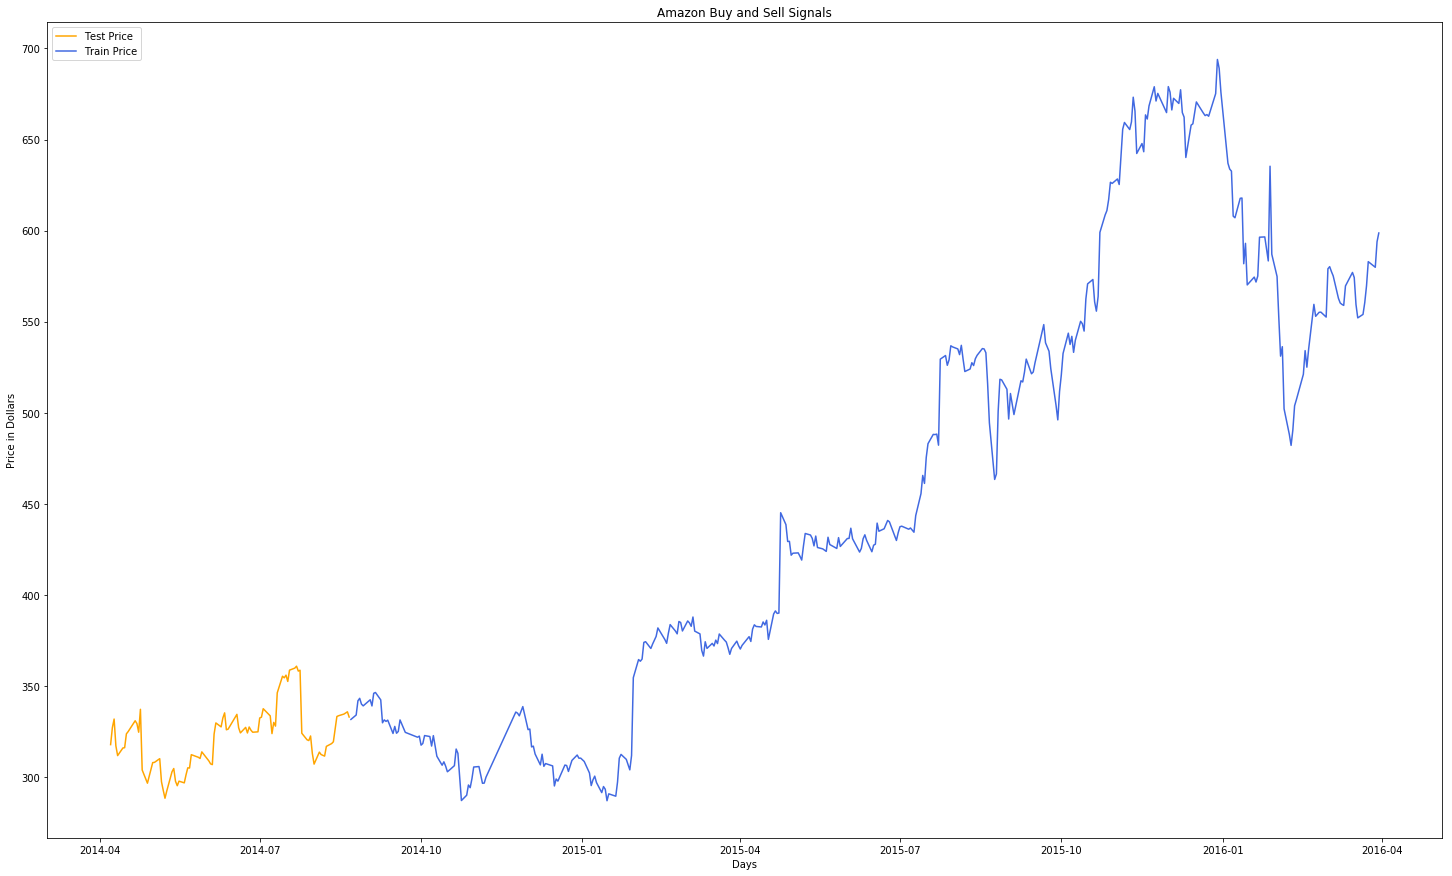

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 50)                11800     
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 11,851
Trainable params: 11,851
Non-trainable params: 0
_________________________________________________________________
Train on 372 samples, validate on 93 samples
Epoch 1/55
 - 1s - loss: 0.1953 - acc: 0.0027 - val_loss: 0.0016 - val_acc: 0.0000e+00
Epoch 2/55
 - 0s - loss: 0.0882 - acc: 0.0027 - val_loss: 0.0188 - val_acc: 0.0000e+00
Epoch 3/55
 - 0s - loss: 0.0289 - acc: 0.0054 - val_loss: 0.0572 - val_acc: 0.0000e+00
Epoch 4/55
 - 0s - loss: 0.0223 - acc: 0.0054 - val_loss: 0.0247 - val_acc

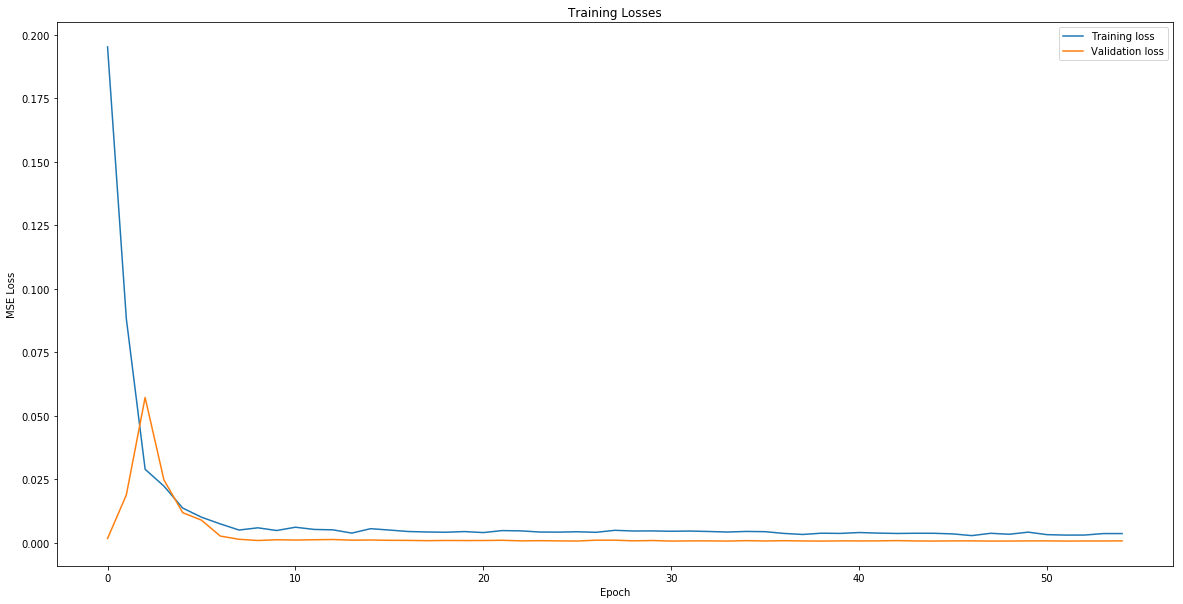

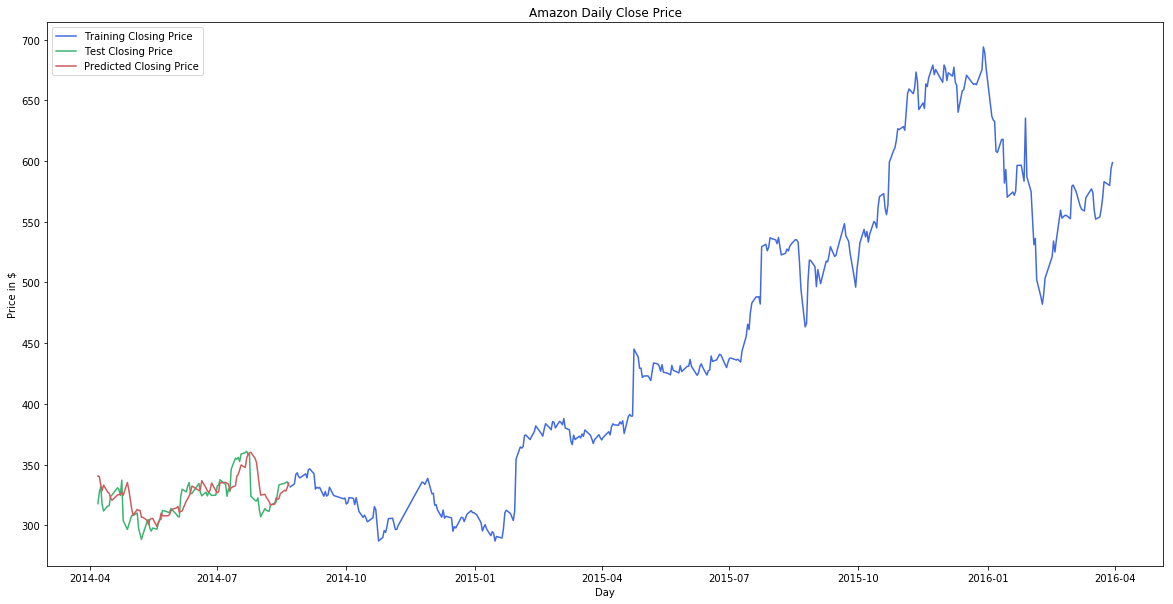

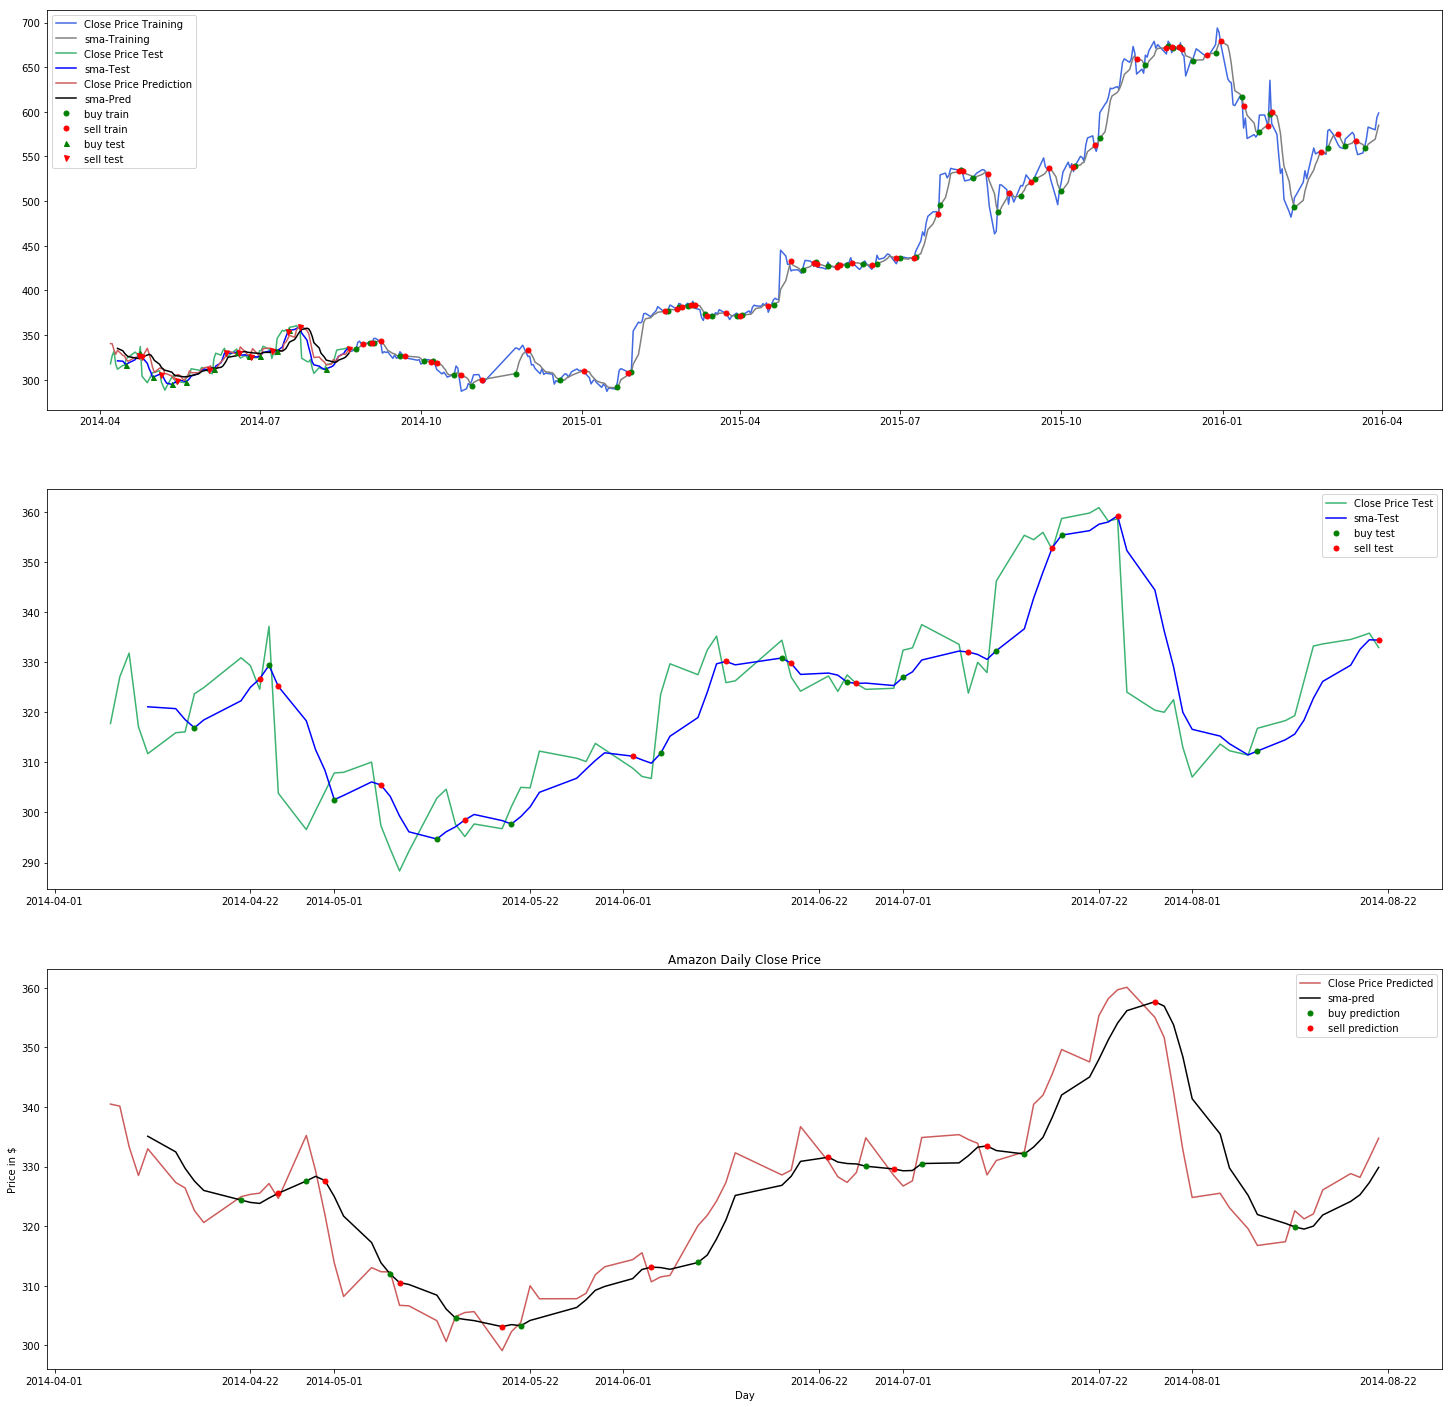

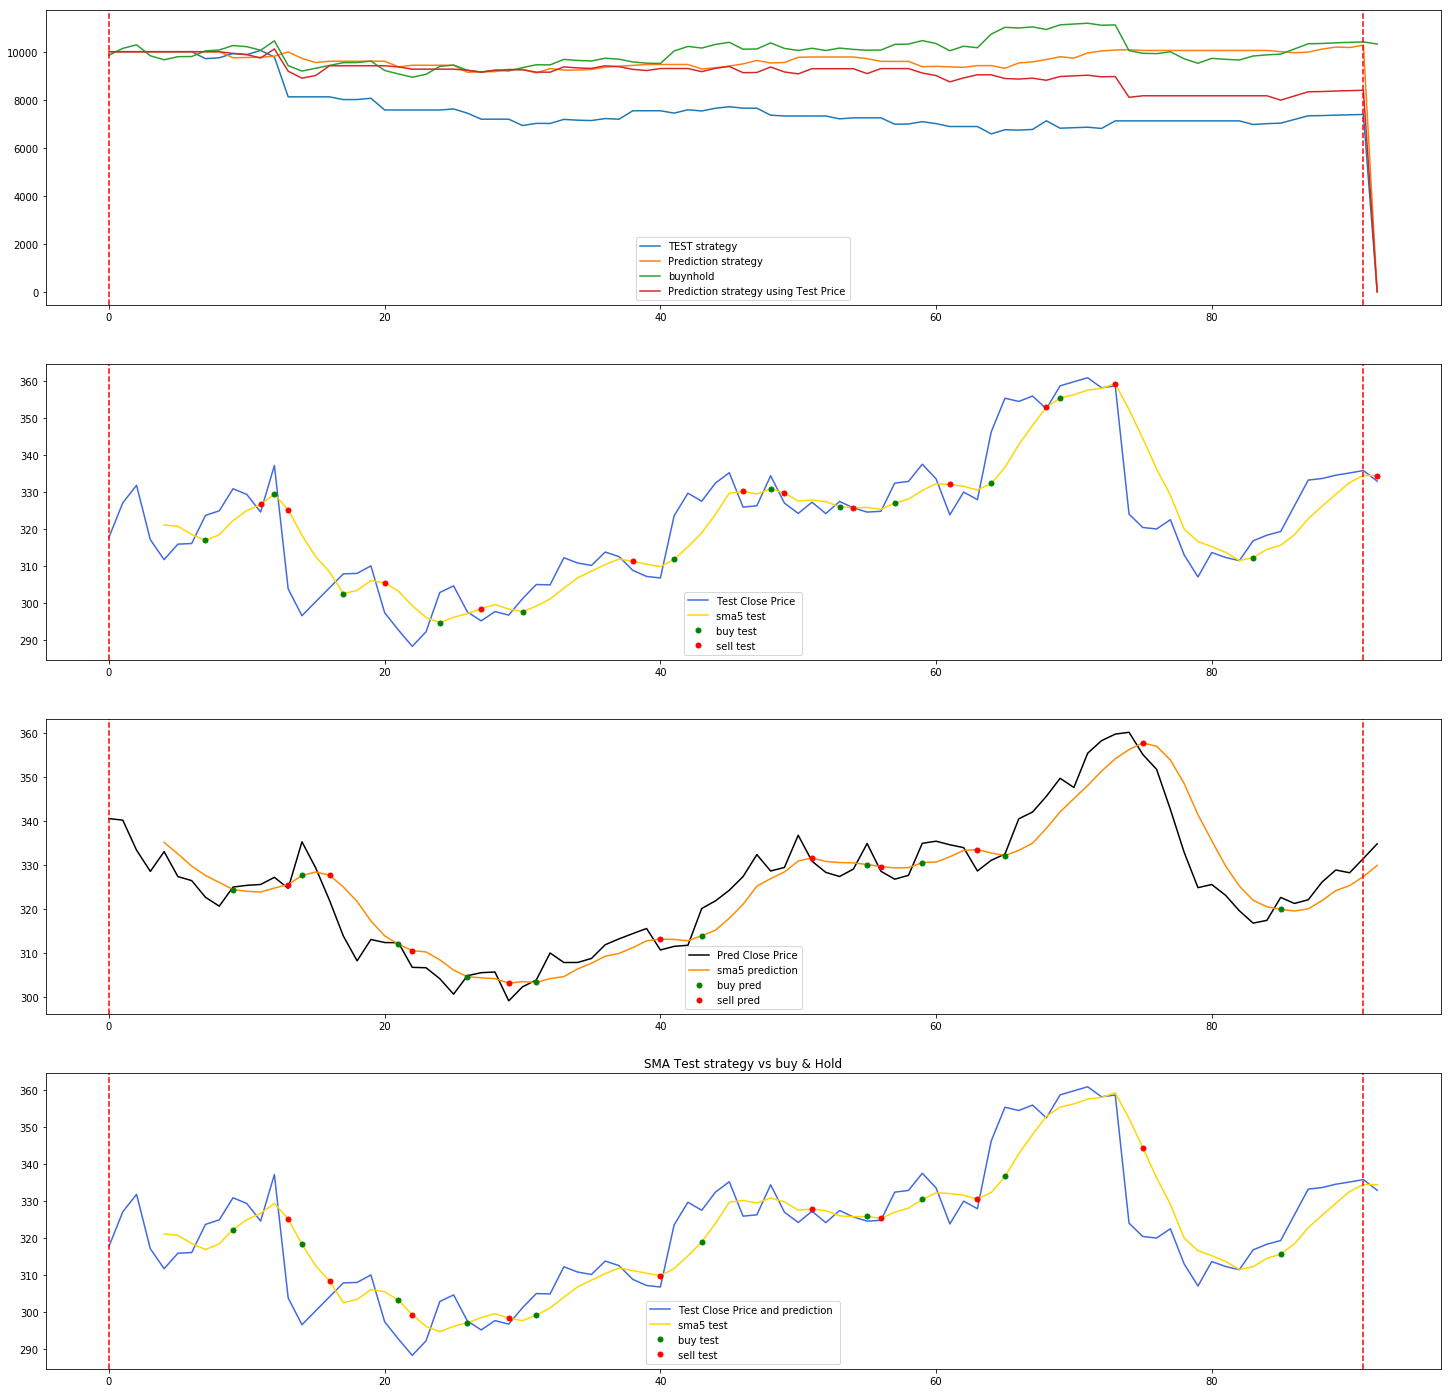

investing 10,000 pounds initially using test data


0                 1              2             3  \
0                            Inital Amount($)  Number Shares  Buy Price($)   
1             buy and hold             10,000             31        317.76   
2                                                                            
3                      test            10,000            NaN           NaN   
4                                                                            
5                prediction             10000            NaN           NaN   
6                                                                            
7  prediction on Test Price             10000            NaN           NaN   

               4                5                  6          7          8  
0  Sell Price($)  Price change($)  capital return($)  Profit($)  Return(%)  
1         332.91            15.15           10320.21     320.21       3.20  
2                                                                           
3            NaN              NaN               7387      -2613     -26.13  
4                                                                           
5            NaN              NaN           10274.33     274.33       2.74  
6                                                                           
7            NaN              NaN            8394.50   -1605.50     -16.06

In [17]:
def set_pandas_options() -> None:
    pd.options.display.max_columns = 1000
    pd.options.display.max_rows = 1000
    pd.options.display.max_colwidth = 199
    pd.options.display.width = None
    pd.options.display.precision = 2  # set as needed

set_pandas_options()

#get the columns we want
stock_df = sma5_df[['Date', 'Tweets', 'Adj. Open', 'Adj. High', 'Adj. Low', 'Adj. Close', 'Adj. Volume', 'Comp', 'sentiment', 'sma5', 'sma5sig']]

#get rid of tweets?? becasue we cannot scale them - or can we? need two Xshapes

df_5 = stock_df[['Adj. Open', 'Adj. Low', 'Adj. High', 'Adj. Volume', 'Comp', 'sma5', 'sma5sig', 'Adj. Close']]

df_5.dropna(inplace=True)

df5 = sma5_df[['Date', 'Adj. Open', 'Adj. Low', 'Adj. High', 'Adj. Volume', 'Comp', 'sma5', 'sma5sig', 'Adj. Close']]
df5.set_index('Date', inplace=True)


#*****

#take out next_decision
LS = df5.copy() #[['Adj. Open', 'Adj. Low', 'Adj. High', 'Adj. Close', 'Adj. Volume', 'Comp', 'ema205', 'ema5sig']]

#***
y = LS['Adj. Close']

#np.random.seed(7)

#***
scaler = preprocessing.MinMaxScaler()

LS['Adj. Open'] = scaler.fit_transform(LS['Adj. Open'].values.reshape(-1,1))
LS['Adj. Low'] = scaler.fit_transform(LS['Adj. Low'].values.reshape(-1,1))
LS['Adj. High'] = scaler.fit_transform(LS['Adj. High'].values.reshape(-1,1))
LS['Adj. Volume'] = scaler.fit_transform(LS['Adj. Volume'].values.reshape(-1,1))
LS['Comp'] = scaler.fit_transform(LS['Comp'].values.reshape(-1,1))
LS['sma5'] = scaler.fit_transform(LS['sma5'].values.reshape(-1,1))
LS['sma5sig'] = scaler.fit_transform(LS['sma5sig'].values.reshape(-1,1))
LS['Adj. Close'] = scaler.fit_transform(LS['Adj. Close'].values.reshape(-1,1))

#*******

data = LS.as_matrix()
LS_df = []

window = 5 #days

for index in range(len(data) - window): 
    LS_df.append(data[index: index + window])
LS_df = np.array(LS_df)

print('LS_df is:', LS_df.shape)

smallSplit = 0.20
largeSplit = 0.80

splitRowStart = int(smallSplit * LS_df.shape[0])
splitRowEnd = int(largeSplit * LS_df.shape[0])
print('first split is: ', splitRowStart) 
print('second split is: ', splitRowEnd) 

no_features = len(LS.columns)

test = LS_df[:splitRowStart]
train = LS_df[splitRowStart :]

print(test.shape, train.shape)
X_train = train[:, :-1] # all data until day 4
y_train = train[:, -1][:,-1] # day 5 last column
print()
print('Training set:', train.shape[0], 'observations')
X_train.shape, y_train.shape

X_test = test[:, :-1] # all data until day n-1
y_test = test[:, -1][:,-1] # day n of last column
      
print('Training set observations:')
X_test.shape, y_test.shape
print()

testEnd = test.shape[0] + window
trainEnd = (train.shape[0]) + window + test.shape[0]

testEnd, trainEnd

origTest = df5.iloc[window:testEnd]
origTrain = df5.iloc[testEnd:trainEnd]
      
print('Original testStart is: ', origTest.shape) 
print('Original train shape is: ', origTrain.shape)
  

fig, ax = plt.subplots(figsize=(25,15))
plt.title('{} Buy and Sell Signals'.format(ticker_name))
ax.plot(origTest.index, origTest['Adj. Close'], color='orange', label='Test Price')
ax.plot(origTrain.index, origTrain['Adj. Close'], color='royalblue', label='Train Price')

plt.xlabel('Days')
ax.legend(loc='upper left')
plt.ylabel('Price in Dollars')
plt.show()

#*****


def build_model(layers):
        d = 0.3 #dropout rate
   #use one layer with 50 for good fit 
        model = Sequential()
        model.add(LSTM(50, input_shape=(layers[1], layers[0]), return_sequences=False)) #input shape is shape of training set
        model.add(Dropout(d))
        #model.add(LSTM(50, input_shape=(layers[1], layers[0]), return_sequences=False)) #input shape is shape of training set
        #model.add(Dropout(d))
        #model.add(LSTM(64, input_shape=(layers[1], layers[0]), return_sequences=False)) #input shape is shape of training set
        #model.add(Dropout(d))
        #
           
        model.add(Dense(1,kernel_initializer='uniform',activation='relu')) #output layer
        
        model.summary()        
        
        return model

model.save('/content/drive/My Drive/MScProject2019KamBansalColab/LSTM_model_split_amazon_new.h5') 
del model  # deletes the existing model
model = load_model('/content/drive/My Drive/MScProject2019KamBansalColab/LSTM_model_split_amazon_new.h5')

model = build_model([no_features, (window-1), 1])
model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])

history = model.fit( X_train, y_train, batch_size= 32, epochs=55, validation_split=0.33, validation_data=(X_test, y_test), shuffle=True, verbose=2)

trainScore = model.evaluate(X_train, y_train, verbose=0)
print('Train Score: %.5f MSE (%.5f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

testScore = model.evaluate(X_test, y_test, verbose=0)
print('Test Score: %.5f MSE (%.5f RMSE)' % (testScore[0], math.sqrt(testScore[0])))

history_dict = history.history
history_dict.keys()

# plot loss and validation loss
fig, a = plt.subplots(figsize=(20,10))

a.plot(history.history['loss'], label='Training loss')
a.plot(history.history['val_loss'], label='Validation loss')
a.set_title('Training Losses')
a.set_xlabel('Epoch')
a.set_ylabel('MSE Loss')
plt.legend()
plt.show()


df5.head(), df5.shape, LS.head(), LS.shape, y_test.shape, X_test.shape

#*******

predict = model.predict(X_test)
prediction = scaler.inverse_transform(predict)

ytest = y_test.reshape(-1, 1)
ytest = scaler.inverse_transform(ytest)

ytest = [i[0] for i in ytest]
pred = [i[0] for i in prediction]

pred_df = origTest.copy()
pred_df['Adj. Close'] = pred


fig, ax = plt.subplots(figsize=(20,10))

ax.plot(origTrain.index, origTrain['Adj. Close'], color='royalblue', label='Training Closing Price')
ax.plot(origTest.index, origTest['Adj. Close'], color='mediumseagreen', label='Test Closing Price')
ax.plot(origTest.index, pred_df['Adj. Close'], color='indianred', label='Predicted Closing Price')
plt.xticks()

plt.legend(loc='upper left')
plt.title('{} Daily Close Price'.format(ticker_name))
plt.xlabel('Day')
plt.ylabel('Price in $')
plt.show()

#now merge datasets of prediction and test date so we can find out the ROI of 10000

pred = pred_df['Adj. Close']
test = origTest['Adj. Close']

test.columns = ['origTestPrice']
pred.columns = ['predPrice']

merge_df = pd.merge(test, pred, on='Date')
merge_df.columns = ['origTestPrice', 'predPrice']

merge_df_head = pd.DataFrame(merge_df.head())

merge_df = merge_df.reset_index()

merge_df_head = pd.DataFrame(merge_df.head())

merge_df = merge_df.set_index('Date')

#using sma5 because of data points not being enough with other indicators

merge_df['sma5pred'] = ta.SMA(np.asarray(merge_df['predPrice']), 5)
merge_df['sma5test'] = ta.SMA(np.asarray(merge_df['origTestPrice']), 5)

#Create training Signals with SMA5
#Initialise column

merge_df['sma5sigpred'] = 0
merge_df['sma5sigtest'] = 0

#test this against one day lag
sma5sigtest = 0
sma5sigpred = 0

merge_df['origTestPrice(-1)'] = merge_df['origTestPrice'].shift(1)
merge_df['sma5test(-1)'] = merge_df['sma5test'].shift(1)

merge_df['predPrice(-1)'] = merge_df['predPrice'].shift(1)
merge_df['sma5pred(-1)'] = merge_df['sma5pred'].shift(1)


# Generate Trading Signals (buy=1 , sell=-1, do nothing=0)
for i, r in enumerate(merge_df.iterrows()):
  if r[1]['predPrice(-1)'] < r[1]['sma5pred(-1)'] and r[1]['predPrice'] > r[1]['sma5pred']:
    sma5sigpred = 1
  elif r[1]['predPrice(-1)'] > r[1]['sma5pred(-1)'] and r[1]['predPrice'] < r[1]['sma5pred']:
    sma5sigpred = -1
  else:
    sma5sigpred = 0
  merge_df.iloc[i, 4] = sma5sigpred
  
  
for i, r in enumerate(merge_df.iterrows()):
  if r[1]['origTestPrice(-1)'] < r[1]['sma5test(-1)'] and r[1]['origTestPrice'] > r[1]['sma5test']:
    sma5sigtest = 1
  elif r[1]['origTestPrice(-1)'] > r[1]['sma5test(-1)'] and r[1]['origTestPrice'] < r[1]['sma5test']:
    sma5sigtest = -1
  else:
    sma5sigtest = 0
  merge_df.iloc[i, 5] = sma5sigtest
  
  
  
merge_df['sma5teststr'] = 0 # initially own the stock

sma5teststr = 0 # initialise all as 0

for i, r in enumerate(merge_df.iterrows()):
  
  #testPrev = 
  
  if r[1]['sma5sigtest'] == 1:
      sma5teststr = 1 #own the stock
  elif r[1]['sma5sigtest'] == -1:
      sma5teststr = 0 #don't own the stock
  else:
      sma5teststr = merge_df['sma5teststr'][i-1] # if dont have either of above, just  repeat previous period trading strategy
  
  merge_df.iloc[i, 10] = sma5teststr # continue to update 
    

merge_df['sma5predstr'] = 0 # initially own the stock

sma5predstr = 0 # initialise all as 0

for i, r in enumerate(merge_df.iterrows()):
    if r[1]['sma5sigpred'] == 1:
        sma5predstr = 1 #own the stock
    elif r[1]['sma5sigpred'] == -1:
        sma5predstr = 0 #don't own the stock
    else:
        sma5predstr = merge_df['sma5predstr'][i-1] # if dont have either of above, just  repeat previous period trading strategy
    merge_df.iloc[i, 11] = sma5predstr # continue to update     

    

#merge_df = merge_df['2015-11-05' : '2016-03-30']

merge_df_head = pd.DataFrame(merge_df.head())


#*******

merge_df = merge_df.reset_index()

merge_df_head = pd.DataFrame(merge_df.head())

#*****

#create
merge_df.set_index('Date', inplace = True)
merge_df = merge_df.round(2)


merge_df_head = pd.DataFrame(merge_df.head(10))


#******

fig, ax = plt.subplots(3, sharex=False, figsize=(25,25))

plt.title('{} Closing Prices and SMA 5')
ax[0].plot(origTrain.index, origTrain['Adj. Close'], color='royalblue', label='Close Price Training')
ax[0].plot(origTrain.index, origTrain['sma5'], color='grey', label='sma-Training')


ax[0].plot(merge_df.index, merge_df['origTestPrice'], color='mediumseagreen', label='Close Price Test')
ax[0].plot(merge_df.index, merge_df['sma5test'], color='blue', label='sma-Test')

ax[0].plot(merge_df.index, merge_df['predPrice'], color='indianred', label='Close Price Prediction')
ax[0].plot(merge_df.index, merge_df['sma5pred'], color='black', label='sma-Pred')

#Plot the buy signals train
ax[0].plot(origTrain.loc[origTrain['sma5sig'] == 1.0].index, 
         origTrain.sma5[origTrain['sma5sig'] == 1.0],
         'o', markersize=5, color='g', label='buy train')
         
# Plot the sell signals train
ax[0].plot(origTrain.loc[origTrain['sma5sig'] == -1.0].index, 
         origTrain.sma5[origTrain['sma5sig'] == -1.0],
         'o', markersize=5, color='r', label='sell train')


#Plot the buy signals test
ax[0].plot(merge_df.loc[merge_df['sma5sigtest'] == 1.0].index, 
         merge_df.sma5test[merge_df['sma5sigtest'] == 1.0],
         '^', markersize=5, color='g', label='buy test')
         
# Plot the sell signals
ax[0].plot(merge_df.loc[merge_df['sma5sigtest'] == -1.0].index, 
         merge_df.sma5test[merge_df['sma5sigtest'] == -1.0],
         'v', markersize=5, color='r', label='sell test')

ax[0].legend(loc='upper left')

#*************************


ax[1].plot(merge_df.index, merge_df['origTestPrice'], color='mediumseagreen', label='Close Price Test')
ax[1].plot(merge_df.index, merge_df['sma5test'], color='blue', label='sma-Test')

# Plot the buy signals
ax[1].plot(merge_df.loc[merge_df['sma5sigtest'] == 1.0].index, 
         merge_df.sma5test[merge_df['sma5sigtest'] == 1.0],
         'o', markersize=5, color='g', label='buy test')

# Plot the sell signals
ax[1].plot(merge_df.loc[merge_df['sma5sigtest'] == -1.0].index, 
         merge_df.sma5test[merge_df['sma5sigtest'] == -1.0],
         'o', markersize=5, color='r', label='sell test')

ax[1].legend(loc='best')

#*************************

ax[2].plot(merge_df.index, merge_df['predPrice'], color='indianred', label='Close Price Predicted')
ax[2].plot(merge_df.index, merge_df['sma5pred'], color='black', label='sma-pred')

# Plot the buy signals
ax[2].plot(merge_df.loc[merge_df['sma5sigpred'] == 1.0].index, 
         merge_df.sma5pred[merge_df['sma5sigpred'] == 1.0],
         'o', markersize=5, color='g', label='buy prediction')

# Plot the sell signals
ax[2].plot(merge_df.loc[merge_df['sma5sigpred'] == -1.0].index, 
         merge_df.sma5pred[merge_df['sma5sigpred'] == -1.0],
         'o', markersize=5, color='r', label='sell prediction')

ax[2].legend(loc='upper-right')

plt.title('{} Daily Close Price'.format(ticker_name))
plt.xlabel('Day')
plt.ylabel('Price in $')
plt.show()

#**********

merge_df = merge_df[['origTestPrice', 'origTestPrice(-1)', 'sma5test', 'sma5test(-1)', 'sma5sigtest', 'sma5teststr', 'predPrice', 'predPrice(-1)', 'sma5pred', 'sma5pred(-1)', 'sma5sigpred', 'sma5predstr']]
merge_df = merge_df.reset_index()

# Teesting against invested funds
investment = 10000

merge_df['capitalTest']= investment
merge_df['investedTest'] = 0
#merge_df['priceTest'] = merge_df['origTestPrice']
merge_df['pnlTest'] = 0 # initially own the stock
merge_df['sharesTest'] = int(investment / merge_df['origTestPrice'][0])
merge_df['buynholdTest'] = merge_df['sharesTest'] * merge_df['origTestPrice']


merge_df['capitalTest'] = merge_df['capitalTest'].astype('float64') 
merge_df['investedTest'] = merge_df['investedTest'].astype('float64')
#merge_df['pnlTest'] = merge_df['pnlTest'].astype('float64')
merge_df['sharesTest'] = merge_df['sharesTest'].astype('float64')
merge_df['buynholdTest'] = merge_df['buynholdTest'].astype('float64')

merge_df = merge_df.round(2)


for i in range(0,len(merge_df)-1):
  
  lasttest = len(merge_df)-1
  
  get_pricetest = merge_df['origTestPrice'].iloc[i]

  #initaltest = 0 
  #buy_pricetest =0
  #difference_pricetest =0
  sharesTest = 0
  #next_datetest = merge_df.Date.iloc[i+1]
  capital_1test = merge_df['capitalTest'].iloc[i-1]
  capitaltest = merge_df['capitalTest'].iloc[i]
  nominaltest = merge_df['pnlTest'].iloc[i]-1
  capital_investedtest = merge_df['origTestPrice'].iloc[i]
  invested_sharestest = int(merge_df['capitalTest'].iloc[i-1] / get_pricetest)
  #pnl = invested_shares * get_price

  get_pnltest = merge_df['pnlTest'].iloc[i-1]
  sma5strtest = merge_df['sma5teststr'].iloc[i]
  sma5str_1test = merge_df['sma5teststr'].iloc[i-1]
  invested_1test = merge_df['investedTest'].iloc[i-1]
  investedtest = merge_df['investedTest'].iloc[i]
  pnl_1test = merge_df['pnlTest'].iloc[i-1]
  
  if(sma5strtest) == 0 and i==0:
    #print('i=0')
    merge_df.at[i,'capitalTest'] = investment    
    merge_df.at[i,'investedTest'] = 0       
    merge_df.at[i,'pnlTest'] = investment     
  
  elif(sma5strtest) == 0 and sma5str_1test == 0 and capital_1test ==investment:
    merge_df.at[i,'investedTest'] = invested_1test  
    merge_df.at[i,'capitalTest'] = capital_1test
    merge_df.at[i, 'pnlTest'] = investment
    
  elif(sma5strtest) == 0 and sma5str_1test == 0 and capital_1test !=investment:
    merge_df.at[i,'investedTest'] = invested_1test  
    merge_df.at[i,'capitalTest'] = capital_1test
    merge_df.at[i, 'pnlTest'] = pnl_1test
     
 
  elif(sma5strtest) == 1 and sma5str_1test == 0:
    merge_df.at[i,'investedTest'] = int(capital_1test / get_pricetest)  
    merge_df.at[i,'capitalTest'] = int(capital_1test - ((merge_df['investedTest'].iloc[i] *get_pricetest)))
    merge_df.at[i, 'pnlTest'] = merge_df['investedTest'].iloc[i] * get_pricetest
    price_buytest = get_pricetest
 
  elif(sma5strtest) == 0 and sma5str_1test == 1 and capital_1test !=investment:
    #print('i=0')
    difference_pricetest = (get_pricetest - price_buytest) 
    merge_df.at[i,'capitalTest'] = capital_1test + (invested_1test * get_pricetest) + (difference_pricetest * invested_1test)    
    merge_df.at[i,'investedTest'] = 0       
    merge_df.at[i,'pnlTest'] = merge_df['capitalTest'].iloc[i]
    
        
  elif(i == lasttest):
    
    merge_df.at[i,'capitalTest'] = capitaltest_1     
    merge_df.at[i,'investedTest'] = invested_1test       
    merge_df.at[i,'pnlTest'] = pnl_1test  
  
  else:
    
    merge_df.at[i,'capitalTest'] = capital_1test    
    merge_df.at[i,'investedTest'] = invested_1test       
    merge_df.at[i,'pnlTest'] = merge_df['investedTest'].iloc[i] * get_pricetest

#****** prediciton

merge_df['capitalPred']= investment
merge_df['investedPred'] = 0
merge_df['pnlPred'] = 0 # initially own the stock
merge_df['sharesPred'] = investment / merge_df['predPrice'][0]
merge_df['buynholdPred'] = merge_df['sharesPred'] * merge_df['predPrice']


merge_df['capitalPred'] = merge_df['capitalPred'].astype('float64') 
merge_df['investedPred'] = merge_df['investedPred'].astype('float64')
merge_df['pnlPred'] = merge_df['pnlPred'].astype('float64')
merge_df['sharesPred'] = merge_df['sharesPred'].astype('float64')
merge_df['buynholdPred'] = merge_df['buynholdPred'].astype('float64')

merge_df = merge_df.round(2)

for i in range(0,len(merge_df)-1):
  
  lastpred = len(merge_df)-1
  
  get_pricepred = merge_df['predPrice'].iloc[i]

  capitalpred_1 = merge_df['capitalPred'].iloc[i-1]
  capitalpred = merge_df['capitalPred'].iloc[i]
  nominalpred = merge_df['pnlPred'].iloc[i]-1
  capital_investedpred = merge_df['predPrice'].iloc[i]
  invested_sharespred = int(merge_df['capitalPred'].iloc[i-1] / get_pricepred)
  sharesPred_1 = merge_df['sharesPred'].iloc[i-1]

  get_pnlpred = merge_df['pnlPred'].iloc[i-1]
  sma5predstr = merge_df['sma5predstr'].iloc[i]
  sma5predstr_1 = merge_df['sma5predstr'].iloc[i-1]
  invested_1pred = merge_df['investedPred'].iloc[i-1]
  investedpred = merge_df['investedPred'].iloc[i]
  pnl_1pred = merge_df['pnlPred'].iloc[i-1]
  
  if(sma5predstr) == 0 and i==0:
 
    merge_df.at[i,'capitalPred'] = investment    
    merge_df.at[i,'investedPred'] = 0       
    merge_df.at[i,'pnlPred'] = investment
    merge_df.at[i,'sharesPred'] = 0
    
  elif(i) == lastpred:
    
    merge_df.at[i,'capitalPred'] = capitalpred_1     
    merge_df.at[i,'investedPred'] = invested_1pred       
    merge_df.at[i,'pnlPred'] = pnl_1pred 
  
  elif(sma5predstr) == 0 and sma5predstr_1 == 0 and capitalpred_1 == investment:
    merge_df.at[i,'investedPred'] = invested_1pred  
    merge_df.at[i,'capitalPred'] = capitalpred_1
    merge_df.at[i, 'pnlPred'] = investment
    
  elif(sma5predstr) == 0 and sma5predstr_1 == 0 and capitalpred_1 !=investment:
    merge_df.at[i,'investedPred'] = invested_1pred  
    merge_df.at[i,'capitalPred'] = capitalpred_1
    merge_df.at[i, 'pnlPred'] = pnl_1pred
    
  elif(sma5predstr) == 1 and sma5predstr_1 == 0:
    merge_df.at[i,'investedPred'] = int(capitalpred_1/ get_pricepred)  
    merge_df.at[i,'capitalPred'] = int(capitalpred_1 - ((merge_df['investedPred'].iloc[i] *get_pricepred)))
    merge_df.at[i, 'pnlPred'] = merge_df['investedPred'].iloc[i] * get_pricepred
    price_buypred = get_pricepred
    
  elif(sma5predstr) == 0 and sma5predstr_1 == 1 and capitalpred_1 !=investment:
    
    difference_pricepred = (get_pricepred - price_buypred) 
    merge_df.at[i,'capitalPred'] = capitalpred_1 + (invested_1pred * get_pricepred)
    merge_df.at[i,'investedPred'] = 0       
    merge_df.at[i,'pnlPred'] = merge_df['capitalPred'].iloc[i]
   
  else:
    
    merge_df.at[i,'capitalPred'] = capitalpred_1    
    merge_df.at[i,'investedPred'] = invested_1pred       
    merge_df.at[i,'pnlPred'] = merge_df['investedPred'].iloc[i] * get_pricepred
    
#****** prediciton onTest

merge_df['capitalPredonTest']= investment
merge_df['investedPredonTest'] = 0
merge_df['pnlPredonTest'] = 0 # initially own the stock
merge_df['sharesPredonTest'] = investment / merge_df['origTestPrice'][0]

merge_df['capitalPredonTest'] = merge_df['capitalPredonTest'].astype('float64') 
merge_df['investedPredonTest'] = merge_df['investedPredonTest'].astype('float64')
merge_df['pnlPredonTest'] = merge_df['pnlPredonTest'].astype('float64')
merge_df['sharesPredonTest'] = merge_df['sharesPredonTest'].astype('float64')

merge_df = merge_df.round(2)

for i in range(0,len(merge_df)-1):
  
  lastpred = len(merge_df)-1
  
  get_pricepredonTest = merge_df['origTestPrice'].iloc[i]

  capitalpred_1onTest = merge_df['capitalPredonTest'].iloc[i-1]
  capitalpredonTest = merge_df['capitalPredonTest'].iloc[i]
  nominalpredonTest = merge_df['pnlPredonTest'].iloc[i]-1
  capital_investedpredonTest = merge_df['origTestPrice'].iloc[i]
  invested_sharespredonTest = int(merge_df['capitalPredonTest'].iloc[i-1] / get_pricepred)
  sharesPred_1onTest = merge_df['sharesPredonTest'].iloc[i-1]

  get_pnlpredonTest = merge_df['pnlPredonTest'].iloc[i-1]
  sma5predstronTest = merge_df['sma5predstr'].iloc[i]
  sma5predstr_1onTest = merge_df['sma5predstr'].iloc[i-1]
  invested_1predonTest = merge_df['investedPredonTest'].iloc[i-1]
  investedpredonTest = merge_df['investedPredonTest'].iloc[i]
  pnl_1predonTest = merge_df['pnlPredonTest'].iloc[i-1]
  
  if(sma5predstronTest) == 0 and i==0:
 
    merge_df.at[i,'capitalPredonTest'] = investment    
    merge_df.at[i,'investedPredonTest'] = 0       
    merge_df.at[i,'pnlPredonTest'] = investment
    merge_df.at[i,'sharesPredonTest'] = 0
    
  elif(i) == lastpred:
    
    merge_df.at[i,'capitalPredonTest'] = capitalpred_1onTest     
    merge_df.at[i,'investedPredonTest'] = invested_1predonTest       
    merge_df.at[i,'pnlPredonTest'] = pnl_1predonTest 
  
  elif(sma5predstronTest) == 0 and sma5predstr_1onTest == 0 and capitalpred_1onTest == investment:
    merge_df.at[i,'investedPredonTest'] = invested_1predonTest  
    merge_df.at[i,'capitalPredonTest'] = capitalpred_1onTest
    merge_df.at[i, 'pnlPredonTest'] = investment
    
  elif(sma5predstronTest) == 0 and sma5predstr_1onTest == 0 and capitalpred_1onTest !=investment:
    merge_df.at[i,'investedPredonTest'] = invested_1predonTest  
    merge_df.at[i,'capitalPredonTest'] = capitalpred_1onTest
    merge_df.at[i, 'pnlPredonTest'] = pnl_1predonTest
    
  elif(sma5predstronTest) == 1 and sma5predstr_1onTest == 0:
    merge_df.at[i,'investedPredonTest'] = int(capitalpred_1onTest/ get_pricepredonTest)  
    merge_df.at[i,'capitalPredonTest'] = int(capitalpred_1onTest - ((merge_df['investedPredonTest'].iloc[i] *get_pricepredonTest)))
    merge_df.at[i, 'pnlPredonTest'] = merge_df['investedPredonTest'].iloc[i] * get_pricepredonTest
    price_buypredonTest = get_pricepredonTest
    
  elif(sma5predstronTest) == 0 and sma5predstr_1onTest == 1 and capitalpred_1onTest !=investment:
    
    difference_pricepredonTest = (get_pricepredonTest - price_buypredonTest) 
    merge_df.at[i,'capitalPredonTest'] = capitalpred_1onTest + (invested_1predonTest * get_pricepredonTest)  
    merge_df.at[i,'investedPredonTest'] = 0       
    merge_df.at[i,'pnlPredonTest'] = merge_df['capitalPredonTest'].iloc[i]
   
  else:
    
    merge_df.at[i,'capitalPredonTest'] = capitalpred_1onTest    
    merge_df.at[i,'investedPredonTest'] = invested_1predonTest       
    merge_df.at[i,'pnlPredonTest'] = merge_df['investedPredonTest'].iloc[i] * get_pricepredonTest
    
merge_df = merge_df[['Date', 'origTestPrice', 'sma5test','sma5sigtest','sma5teststr', 'capitalTest', 'investedTest', 'pnlTest', 'predPrice', 'sma5pred', 'sma5sigpred', 'sma5predstr', 
                     'capitalPred','investedPred','pnlPred', 'capitalPredonTest','investedPredonTest','pnlPredonTest', 'buynholdTest']]

#draw chart
fig, ax = plt.subplots(4, figsize=(25, 25))

ax[0].plot(merge_df['pnlTest'], label = 'TEST strategy' )
ax[0].plot(merge_df['pnlPred'], label = 'Prediction strategy' )
ax[0].plot(merge_df['buynholdTest'], label = 'buynhold' )
ax[0].plot(merge_df['pnlPredonTest'], label = 'Prediction strategy using Test Price' )

ax[0].axvline(merge_df.index[0], color='r', ls='--')
ax[0].axvline(merge_df.index[-2], color='r', ls='--')

ax[0].legend(loc='bottom lower')

# Plot the buy signals
ax[1].plot(merge_df['origTestPrice'], label='Test Close Price ', color = 'royalblue')
ax[1].plot(merge_df['sma5test'], label='sma5 test', color = 'gold')

ax[1].plot(merge_df.loc[merge_df['sma5sigtest'] == 1.0].index, 
         merge_df.sma5test[merge_df['sma5sigtest'] == 1.0],
         'o', markersize=5, color='g', label='buy test')
         
# Plot the sell signals
ax[1].plot(merge_df.loc[merge_df['sma5sigtest'] == -1.0].index, 
         merge_df.sma5test[merge_df['sma5sigtest'] == -1.0],
         'o', markersize=5, color='r', label='sell test')

ax[1].legend(loc='best')

ax[1].axvline(merge_df.index[0], color='r', ls='--')
ax[1].axvline(merge_df.index[-2], color='r', ls='--')

# Plot the buy signals
ax[2].plot(merge_df['predPrice'], label='Pred Close Price', color = 'black')
ax[2].plot(merge_df['sma5pred'], label='sma5 prediction', color = 'darkorange')

ax[2].plot(merge_df.loc[merge_df['sma5sigpred'] == 1.0].index, 
         merge_df.sma5pred[merge_df['sma5sigpred'] == 1.0],
         'o', markersize=5, color='g', label='buy pred')
         
# Plot the sell signals
ax[2].plot(merge_df.loc[merge_df['sma5sigpred'] == -1.0].index, 
         merge_df.sma5pred[merge_df['sma5sigpred'] == -1.0],
         'o', markersize=5, color='r', label='sell pred')

ax[2].legend(loc='best')

ax[2].axvline(merge_df.index[0], color='r', ls='--')
ax[2].axvline(merge_df.index[-2], color='r', ls='--')


# Plot the buy signals
ax[3].plot(merge_df['origTestPrice'], label='Test Close Price and prediction ', color = 'royalblue')
ax[3].plot(merge_df['sma5test'], label='sma5 test', color = 'gold')

ax[3].plot(merge_df.loc[merge_df['sma5sigpred'] == 1.0].index, 
         merge_df.sma5test[merge_df['sma5sigpred'] == 1.0],
         'o', markersize=5, color='g', label='buy test')
         
# Plot the sell signals
ax[3].plot(merge_df.loc[merge_df['sma5sigpred'] == -1.0].index, 
         merge_df.sma5test[merge_df['sma5sigpred'] == -1.0],
         'o', markersize=5, color='r', label='sell test')

ax[3].legend(loc='best')

ax[3].axvline(merge_df.index[0], color='r', ls='--')
ax[3].axvline(merge_df.index[-2], color='r', ls='--')


plt.title('SMA Test strategy vs buy & Hold')
plt.legend()
plt.show()
 
pd.set_option('display.max_columns', None)
pd.options.display.max_seq_items = None
#buynhold
bhBuyPricetest = merge_df['origTestPrice'].iloc[0]
bhSellPricetest = merge_df['origTestPrice'].iloc[lasttest]

#buy and hold profit 
initial  = 10000

bhshares_invested_test = int(initial / bhBuyPricetest)

bhPrice_change_test = (bhSellPricetest - bhBuyPricetest)

bhcapitalReturn_test = merge_df['buynholdTest'].iloc[-1]
bhProfit_test = bhcapitalReturn_test - initial

bhReturn_test = ((bhProfit_test/initial)*100).round(2)


#test
buyTestIndex = 9
sellTestIndex = merge_df.index[-2]

buy_first_test = merge_df['origTestPrice'][buyTestIndex] #64.20
sell_last_price = merge_df['origTestPrice'][sellTestIndex] #62.71
test_price_change = sell_last_price - buy_first_test
capital_return_test = merge_df['pnlTest'][sellTestIndex]
capitalprofit_test = (capital_return_test - initial).round(2)
return_test = ((capitalprofit_test/initial)*100).round(2)

#Prediction

buyPredIndex = 12
sellPredIndex = merge_df.index[-2]

buy_first_pred = merge_df['predPrice'][buyPredIndex] #float(122.81)
sell_last_price_pred = merge_df['predPrice'][sellPredIndex] #118.96
price_change_pred = sell_last_price_pred - buy_first_pred
capital_return_pred = merge_df['pnlPred'][sellPredIndex]
capitalprofit_pred = (capital_return_pred - initial).round(2)
return_pred = ((capitalprofit_pred/initial)*100).round(2)

#Prediction on Test Price

buyPredIndex = 12
sellPredIndex = merge_df.index[-2]

buy_first_predonTest = merge_df['origTestPrice'][buyPredIndex] #float(122.81)
sell_last_price_predonTest = merge_df['origTestPrice'][sellPredIndex] #118.96
price_change_predonTest = sell_last_price_predonTest - buy_first_predonTest
capital_return_predonTest = merge_df['pnlPredonTest'][sellPredIndex]
capitalprofit_predonTest = (capital_return_predonTest - initial).round(2)
return_predonTest = ((capitalprofit_predonTest/initial)*100).round(2)


print('investing 10,000 pounds initially using test data')

# Summary Results Data Table
testvspreddata = [{'0': '', '1': 'Inital Amount($)', '2': 'Number Shares', '3': 'Buy Price($)', '4': 'Sell Price($)', '5': 'Price change($)', '6': 'capital return($)', '7': 'Profit($)', '8': 'Return(%)'},
        {'0': 'buy and hold ', '1': '10,000', '2': bhshares_invested_test, '3': bhBuyPricetest, '4': bhSellPricetest, '5': bhPrice_change_test,  '6': bhcapitalReturn_test, '7': bhProfit_test, '8': bhReturn_test},  
       
        {'0': '', '1':'' , '2': '', '3': '', '4': '', '5': '', '6': '', '7': '', '8': ''},
        
        {'0': 'test', '1': '10,000', '2': 'NaN', '3': 'NaN', '4': 'NaN', '5': 'NaN',  '6': capital_return_test, '7': capitalprofit_test, '8': return_test},
                       {'0': '', '1':'' , '2': '', '3': '', '4': '', '5': '', '6': '', '7': '', '8': ''},
          {'0': 'prediction', '1': initial, '2': 'NaN', '3': 'NaN', '4': 'NaN', '5': 'NaN',  '6': capital_return_pred, '7': capitalprofit_pred, '8': return_pred},
                   {'0': '', '1':'' , '2': '', '3': '', '4': '', '5': '', '6': '', '7': '', '8': ''},
          {'0': 'prediction on Test Price', '1': initial, '2': 'NaN', '3': 'NaN', '4': 'NaN', '5': 'NaN',  '6': capital_return_predonTest, '7': capitalprofit_predonTest, '8': return_predonTest}]
                  

pd.options.display.float_format = '{:.2f}'.format
table = pd.DataFrame(testvspreddata)

table
       

In [0]:
#**************end***********************